# 101 · Pre-Match-Faktoren: Was erklärt den Heimvorteil?

**Ziel:** Quantifizieren, wie stark **vor dem Anpfiff** bekannte Faktoren den Heimvorteil (ΔPPG = Home − Away) erklären:
- Wettquoten → **p_home**, **xDelta**
- **RestDiff** (Erholungstage Home − Auswärts)
- Teamstärke-Proxys: **spi_diff** (SPI), **mv_diff** (Marktwert)
- Kalibrierung (Odds), Korrelationen, einfache OLS mit League-FE

**Datenquellen:**
- `data/matches/<Land>/<Liga>/<Saison>/*.csv`
- `data/ratings/spi_global_rankings.csv` *(Schnappschuss)*
- `data/ratings/value/*.csv` *(Marktwert-Tabellen der Top-5 Ligen)*

**Wichtige Prinzipien in diesem Notebook**
- **Pro Faktor nur valide Zeilen** (keine NaNs im betreffenden Feature).
- **Saison-Sinnhaftigkeit:** Resttage werden *innerhalb von (Liga,Saison)* berechnet; Auswertungen zeigen zusätzlich pro Saison aggregierte Statistiken (kein Vermischen erster Spieltage etc.).
- **Robuste Modelle:** automatische Auswahl verfügbarer, nicht-konstanter Features; HC1-robuste SE; sinnvolle Fallbacks ohne `statsmodels`.

---


In [38]:
# C0 — Setup & Guards
import pandas as pd, numpy as np, re
from pathlib import Path
import matplotlib.pyplot as plt

plt.rcParams["figure.dpi"] = 140

def season_sort_key(s):
    try: return 2000 + int(str(s).split("-")[0])
    except Exception: return 9999

def parse_date(x: pd.Series) -> pd.Series:
    return pd.to_datetime(x, errors="coerce", dayfirst=True)

def add_points(df: pd.DataFrame) -> pd.DataFrame:
    map_h, map_a = {"H":3,"D":1,"A":0}, {"H":0,"D":1,"A":3}
    df["HomePoints"]=df["FTR"].map(map_h).astype(float)
    df["AwayPoints"]=df["FTR"].map(map_a).astype(float)
    df["DeltaPoints"]=df["HomePoints"]-df["AwayPoints"]
    df["GoalDiff"]=df["FTHG"].astype(float)-df["FTAG"].astype(float)
    return df

def read_csv_robust(path: Path) -> pd.DataFrame:
    # probiert Encoding + Delimiter
    for enc in ("utf-8","utf-8-sig","cp1252","latin-1"):
        for spec in [("c", ","), ("c",";"), ("python", None)]:
            try:
                return pd.read_csv(path, engine=spec[0], sep=spec[1], encoding=enc, on_bad_lines="skip")
            except Exception:
                pass
    return pd.read_csv(path, engine="python", sep=";", encoding="latin-1", on_bad_lines="skip")


In [39]:
# C1 — Matches robust laden (Top-5) und Odds in Wahrscheinlichkeiten umrechnen
DIV_TO_LEAGUE = {"D1":"Bundesliga","E0":"Premier League","SP1":"La Liga","F1":"Ligue 1","I1":"Serie A"}
LEAGUE_CANON = {
    "1. Bundesliga":"Bundesliga","Bundesliga":"Bundesliga",
    "Premier League":"Premier League",
    "La Liga Primera Division":"La Liga","La Liga":"La Liga",
    "Le Championnat":"Ligue 1","Ligue 1":"Ligue 1",
    "Serie A":"Serie A",
}
TOP5 = set(LEAGUE_CANON.values())
EXCLUDE_SEASONS = {"25-26"}  # laufend raus

def season_compact(s: str) -> str:
    s = str(s); m = re.search(r"(\d{4})[.\-_/](\d{4})", s)
    if m: return f"{m.group(1)[-2:]}-{m.group(2)[-2:]}"
    m2 = re.search(r"(\d{2})[.\-_/](\d{2})", s)
    return f"{m2.group(1)}-{m2.group(2)}" if m2 else s

def find_match_root(start: Path = Path.cwd()) -> Path:
    for base in [start, *start.parents]:
        cand = base / "data" / "matches"
        if cand.exists(): return cand
    raise FileNotFoundError("data/matches nicht gefunden")

def detect_league(csv_path: Path, df: pd.DataFrame, root: Path) -> str | None:
    if "Div" in df.columns:
        div_raw = str(df["Div"].iloc[0]).strip().upper()
        if div_raw in DIV_TO_LEAGUE:
            return DIV_TO_LEAGUE[div_raw]
    parts = csv_path.relative_to(root).parts
    if len(parts) >= 3:
        return LEAGUE_CANON.get(parts[1], parts[1])
    if "League" in df.columns:
        return str(df["League"].iloc[0])
    return None

def load_matches_min(root: Path, strict_top5: bool = True) -> pd.DataFrame:
    rows = []
    for csv in root.rglob("*.csv"):
        try:
            df = read_csv_robust(csv)
        except Exception:
            continue
        if not {"Date","HomeTeam","AwayTeam","FTHG","FTAG","FTR"}.issubset(df.columns):
            continue
        league = detect_league(csv, df, root)
        if not league: 
            continue
        league = LEAGUE_CANON.get(league, league)
        if strict_top5 and league not in TOP5: 
            continue
        season = season_compact(csv.parent.name)
        d = df.copy()
        d["League"], d["Season"], d["Date"] = league, season, parse_date(d["Date"])
        rows.append(d)
    if not rows:
        raise RuntimeError("Keine passenden CSVs gefunden – Struktur/Spalten prüfen.")
    m = pd.concat(rows, ignore_index=True).dropna(subset=["Date"])
    if EXCLUDE_SEASONS:
        m = m[~m["Season"].isin(EXCLUDE_SEASONS)].copy()
    return add_points(m)

MATCH_ROOT = find_match_root()
matches = load_matches_min(MATCH_ROOT, strict_top5=True)
print(f"✅ matches: {len(matches):,} | Ligen: {matches['League'].nunique()} | Saisons: {matches['Season'].nunique()}")

# Odds -> p_home, p_draw, p_away, xDelta
ODDS_PRIORITY = [
    ("PSCH","PSCD","PSCA"), ("PSH","PSD","PSA"),
    ("B365H","B365D","B365A"), ("WHH","WHD","WHA"),
    ("IWH","IWD","IWA"), ("VCH","VCD","VCA"),
]

def choose_odds_triple(cols: set):
    for trio in ODDS_PRIORITY:
        if set(trio).issubset(cols): return trio
    return None

def add_probs_and_xp(df: pd.DataFrame) -> pd.DataFrame:
    trio = choose_odds_triple(set(df.columns))
    if not trio:
        print("⚠️ Keine Quoten-Spalten gefunden – p_home/xDelta bleiben NaN.")
        return df
    h,d,a = trio
    out = df.copy()
    for c in (h,d,a): out[c] = pd.to_numeric(out[c], errors="coerce")
    raw = 1/out[[h,d,a]]
    margin = raw.sum(axis=1)
    out["p_home"], out["p_draw"], out["p_away"] = raw[h]/margin, raw[d]/margin, raw[a]/margin
    out["xP_home"] = 3*out["p_home"] + out["p_draw"]
    out["xP_away"] = 3*out["p_away"] + out["p_draw"]
    out["xDelta"]  = out["xP_home"] - out["xP_away"]
    out["logit_home"] = np.log(np.clip(out["p_home"],1e-6,1-1e-6) / np.clip(out["p_away"],1e-6,1-1e-6))
    return out

matches = add_probs_and_xp(matches)


✅ matches: 13,989 | Ligen: 5 | Saisons: 8


In [28]:
# C3 — Odds -> p_home, p_draw, p_away, xDelta

ODDS_PRIORITY = [
    ("PSCH","PSCD","PSCA"), ("PSH","PSD","PSA"),
    ("B365H","B365D","B365A"), ("WHH","WHD","WHA"),
    ("IWH","IWD","IWA"), ("VCH","VCD","VCA"),
]

def choose_odds_triple(cols: set):
    for trio in ODDS_PRIORITY:
        if set(trio).issubset(cols): return trio
    return None

def add_probs_and_xp(df: pd.DataFrame) -> pd.DataFrame:
    trio = choose_odds_triple(set(df.columns))
    if not trio:
        print("⚠️ Keine Quoten-Triple gefunden – Wahrscheinlichkeiten bleiben leer.")
        return df
    h,d,a = trio
    out = df.copy()
    for c in (h,d,a): out[c] = pd.to_numeric(out[c], errors="coerce")
    inv = 1/out[[h,d,a]]
    margin = inv.sum(axis=1)
    out["p_home"], out["p_draw"], out["p_away"] = inv[h]/margin, inv[d]/margin, inv[a]/margin
    out["xP_home"] = 3*out["p_home"] + out["p_draw"]
    out["xP_away"] = 3*out["p_away"] + out["p_draw"]
    out["xDelta"]  = out["xP_home"] - out["xP_away"]
    out["logit_home"] = np.log(np.clip(out["p_home"],1e-6,1-1e-6) / np.clip(out["p_away"],1e-6,1-1e-6))
    return out

matches = add_probs_and_xp(matches)
matches["HomeWin"] = (matches["DeltaPoints"] > 1).astype(int)


In [40]:
# C1 — Matches robust laden (Top-5) und Odds in Wahrscheinlichkeiten umrechnen
DIV_TO_LEAGUE = {"D1":"Bundesliga","E0":"Premier League","SP1":"La Liga","F1":"Ligue 1","I1":"Serie A"}
LEAGUE_CANON = {
    "1. Bundesliga":"Bundesliga","Bundesliga":"Bundesliga",
    "Premier League":"Premier League",
    "La Liga Primera Division":"La Liga","La Liga":"La Liga",
    "Le Championnat":"Ligue 1","Ligue 1":"Ligue 1",
    "Serie A":"Serie A",
}
TOP5 = set(LEAGUE_CANON.values())
EXCLUDE_SEASONS = {"25-26"}  # laufend raus

def season_compact(s: str) -> str:
    s = str(s); m = re.search(r"(\d{4})[.\-_/](\d{4})", s)
    if m: return f"{m.group(1)[-2:]}-{m.group(2)[-2:]}"
    m2 = re.search(r"(\d{2})[.\-_/](\d{2})", s)
    return f"{m2.group(1)}-{m2.group(2)}" if m2 else s

def find_match_root(start: Path = Path.cwd()) -> Path:
    for base in [start, *start.parents]:
        cand = base / "data" / "matches"
        if cand.exists(): return cand
    raise FileNotFoundError("data/matches nicht gefunden")

def detect_league(csv_path: Path, df: pd.DataFrame, root: Path) -> str | None:
    if "Div" in df.columns:
        div_raw = str(df["Div"].iloc[0]).strip().upper()
        if div_raw in DIV_TO_LEAGUE:
            return DIV_TO_LEAGUE[div_raw]
    parts = csv_path.relative_to(root).parts
    if len(parts) >= 3:
        return LEAGUE_CANON.get(parts[1], parts[1])
    if "League" in df.columns:
        return str(df["League"].iloc[0])
    return None

def load_matches_min(root: Path, strict_top5: bool = True) -> pd.DataFrame:
    rows = []
    for csv in root.rglob("*.csv"):
        try:
            df = read_csv_robust(csv)
        except Exception:
            continue
        if not {"Date","HomeTeam","AwayTeam","FTHG","FTAG","FTR"}.issubset(df.columns):
            continue
        league = detect_league(csv, df, root)
        if not league: 
            continue
        league = LEAGUE_CANON.get(league, league)
        if strict_top5 and league not in TOP5: 
            continue
        season = season_compact(csv.parent.name)
        d = df.copy()
        d["League"], d["Season"], d["Date"] = league, season, parse_date(d["Date"])
        rows.append(d)
    if not rows:
        raise RuntimeError("Keine passenden CSVs gefunden – Struktur/Spalten prüfen.")
    m = pd.concat(rows, ignore_index=True).dropna(subset=["Date"])
    if EXCLUDE_SEASONS:
        m = m[~m["Season"].isin(EXCLUDE_SEASONS)].copy()
    return add_points(m)

MATCH_ROOT = find_match_root()
matches = load_matches_min(MATCH_ROOT, strict_top5=True)
print(f"✅ matches: {len(matches):,} | Ligen: {matches['League'].nunique()} | Saisons: {matches['Season'].nunique()}")

# Odds -> p_home, p_draw, p_away, xDelta
ODDS_PRIORITY = [
    ("PSCH","PSCD","PSCA"), ("PSH","PSD","PSA"),
    ("B365H","B365D","B365A"), ("WHH","WHD","WHA"),
    ("IWH","IWD","IWA"), ("VCH","VCD","VCA"),
]

def choose_odds_triple(cols: set):
    for trio in ODDS_PRIORITY:
        if set(trio).issubset(cols): return trio
    return None

def add_probs_and_xp(df: pd.DataFrame) -> pd.DataFrame:
    trio = choose_odds_triple(set(df.columns))
    if not trio:
        print("⚠️ Keine Quoten-Spalten gefunden – p_home/xDelta bleiben NaN.")
        return df
    h,d,a = trio
    out = df.copy()
    for c in (h,d,a): out[c] = pd.to_numeric(out[c], errors="coerce")
    raw = 1/out[[h,d,a]]
    margin = raw.sum(axis=1)
    out["p_home"], out["p_draw"], out["p_away"] = raw[h]/margin, raw[d]/margin, raw[a]/margin
    out["xP_home"] = 3*out["p_home"] + out["p_draw"]
    out["xP_away"] = 3*out["p_away"] + out["p_draw"]
    out["xDelta"]  = out["xP_home"] - out["xP_away"]
    out["logit_home"] = np.log(np.clip(out["p_home"],1e-6,1-1e-6) / np.clip(out["p_away"],1e-6,1-1e-6))
    return out

matches = add_probs_and_xp(matches)


✅ matches: 13,989 | Ligen: 5 | Saisons: 8


In [41]:
# C3 — Team-Normalizer (breit) + Helper
TEAM_NAME_FIXES = {
    # häufige Kurz-/Englischformen -> normalisierte Namen (lower-case)
    "bayern munich":"bayern münchen", "fc bayern munchen":"bayern münchen", "fc bayern münchen":"bayern münchen",
    "1 fc koln":"köln", "fc koln":"köln", "koln":"köln", "fc köln":"köln",
    "mgladbach":"borussia mönchengladbach", "borussia monchengladbach":"borussia mönchengladbach",
    "hertha":"hertha berlin", "ein frankfurt":"eintracht frankfurt", "fc koln":"köln",
    "schalke":"schalke 04", "monaco":"as monaco", "psg":"paris saint-germain",
    "st etienne":"saint-etienne", "st. etienne":"saint-etienne",
    "ath madrid":"atlético madrid", "ath bilbao":"athletic bilbao", "espanol":"espanyol",
    "betis":"real betis", "celta":"celta vigo", "sporting gijon":"sporting gijón",
    "ud las palmas":"las palmas",
    "nottm forest":"nottingham forest", "nott'm forest":"nottingham forest",
    "man united":"manchester united", "man utd":"manchester united", "wolves":"wolverhampton",
    "newcastle":"newcastle united", "spurs":"tottenham", "leverkusen":"bayer leverkusen",
    "werder":"werder bremen", "mainz 05":"mainz", "ein frankfurt":"eintracht frankfurt",
}

def normalize_team(name: str) -> str:
    if pd.isna(name): return name
    s = str(name).strip().lower()
    s = s.replace("’","'").replace("`","'")
    s = re.sub(r"[^a-z0-9äöüß' \-.]", "", s)
    s = re.sub(r"\s+"," ",s)
    return TEAM_NAME_FIXES.get(s, s)

matches["HomeTeam_n"] = matches["HomeTeam"].map(normalize_team)
matches["AwayTeam_n"] = matches["AwayTeam"].map(normalize_team)


In [42]:
# C4 — SPI aus data/ratings/spi_global_rankings.csv (Proxy, Snapshot)
def find_ratings_dir(start: Path = Path.cwd()) -> Path:
    for base in [start, *start.parents]:
        cand = base / "data" / "ratings"
        if cand.exists(): return cand
    raise FileNotFoundError("data/ratings nicht gefunden")

RATINGS_DIR = find_ratings_dir()
SPI_GLOBAL = RATINGS_DIR / "spi_global_rankings.csv"

LEAGUE_MAP_SPI = {
    "Barclays Premier League":"Premier League",
    "German Bundesliga":"Bundesliga",
    "Spanish Primera Division":"La Liga",
    "Italian Serie A":"Serie A",
    "French Ligue 1":"Ligue 1",
}

if SPI_GLOBAL.exists():
    for enc in ("utf-8","utf-8-sig","cp1252","latin-1"):
        try:
            spi = pd.read_csv(SPI_GLOBAL, encoding=enc); break
        except Exception: pass
    spi = spi.rename(columns={"name":"Team","league":"League"})
    keep = [c for c in ["Team","League","spi","off","def"] if c in spi.columns]
    spi = spi[keep].copy()
    spi["League"] = spi["League"].map(LEAGUE_MAP_SPI).fillna(spi["League"])
    spi["Team_n"] = spi["Team"].map(normalize_team)
    spi_map = spi.set_index("Team_n")["spi"].to_dict()
else:
    print("⚠️ spi_global_rankings.csv fehlt – SPI bleibt NaN.")
    spi_map = {}

matches["spi_home"] = matches["HomeTeam_n"].map(spi_map)
matches["spi_away"] = matches["AwayTeam_n"].map(spi_map)
matches["spi_diff"] = matches["spi_home"] - matches["spi_away"]

print("SPI coverage (home/away):",
      matches["spi_home"].notna().mean(), matches["spi_away"].notna().mean())


SPI coverage (home/away): 0.6904710844234756 0.690542569161484


In [44]:
# C5 — Marktwerte aus data/ratings/value/*.csv lesen (de-DE), normalisieren & fuzzy-matchen
from difflib import get_close_matches
import numpy as np
import pandas as pd

VAL_DIR = RATINGS_DIR / "value"
VAL_FILES = {
    "Bundesliga":"Bundesliga.csv",
    "La Liga":"La_Liga.csv",
    "Ligue 1":"League_1.csv",
    "Premier League":"Premier_League.csv",
    "Serie A":"Serie_A.csv",
}

def parse_eur_mio(cell) -> float:
    if pd.isna(cell): return np.nan
    s = str(cell)
    s = s.replace("Mrd.","000 Mio.")  # grobe Umrechnung falls 'Mrd.' auftaucht
    s = s.replace("Mio.","").replace("Mio","").replace("€","").replace("EUR","")
    s = s.replace(".", "").replace(" ", "")
    s = s.replace(",", ".")
    try: return float(s)
    except: return np.nan

mv_map = {}
seen_names = set()
audit_parts = []

for league, fname in VAL_FILES.items():
    path = VAL_DIR / fname
    if not path.exists():
        print(f"⚠️ fehlt: {path}")
        continue

    # robust lesen (semicolon, cp1252/latin-1 meist korrekt)
    ok = False
    for enc in ("cp1252","latin-1","utf-8","utf-8-sig"):
        try:
            dfv = pd.read_csv(path, sep=";", encoding=enc, engine="python", header=None)
            ok = True; break
        except Exception: pass
    if not ok:
        print(f"⚠️ konnte {path.name} nicht lesen"); continue

    # erste Zeile = Datum -> droppen
    dfv = dfv.iloc[1:].reset_index(drop=True)
    # nehme den längeren String aus Spalte 0/1 als Team
    dfv["team0"] = dfv[0].astype(str).str.strip()
    dfv["team1"] = dfv[1].astype(str).str.strip() if 1 in dfv.columns else ""
    dfv["Team_raw"] = np.where(dfv["team1"].str.len()>dfv["team0"].str.len(), dfv["team1"], dfv["team0"])
    dfv["Team_n"] = dfv["Team_raw"].map(normalize_team)
    last_col = dfv.columns[-1]
    dfv["mv_mio"] = dfv[last_col].apply(parse_eur_mio)

    for t, v in dfv[["Team_n","mv_mio"]].dropna().itertuples(index=False):
        mv_map[t] = float(v)
        seen_names.add(t)

    audit_parts.append(
        dfv[["Team_raw","Team_n","mv_mio"]].assign(league=league)
    )

audit_df = pd.concat(audit_parts, ignore_index=True) if audit_parts else pd.DataFrame()

# 1) exakte Map
matches["mv_home"] = matches["HomeTeam_n"].map(mv_map)
matches["mv_away"] = matches["AwayTeam_n"].map(mv_map)

# 2) fuzzy fallback für fehlende (vorsichtig, auditieren)
def fuzzy_fill(name_n: str) -> float:
    """Gibt Marktwert in Mio. € zurück oder np.nan, wenn kein Match."""
    if pd.isna(name_n):
        return np.nan
    if name_n in mv_map:
        return float(mv_map[name_n])
    candidates = get_close_matches(name_n, list(seen_names), n=1, cutoff=0.86)
    return float(mv_map[candidates[0]]) if candidates else np.nan

mask_h = matches["mv_home"].isna()
mask_a = matches["mv_away"].isna()
matches.loc[mask_h, "mv_home"] = matches.loc[mask_h, "HomeTeam_n"].map(fuzzy_fill)
matches.loc[mask_a, "mv_away"] = matches.loc[mask_a, "AwayTeam_n"].map(fuzzy_fill)

matches["mv_diff"] = matches["mv_home"] - matches["mv_away"]
print("MV coverage (home/away):",
      matches["mv_home"].notna().mean(), matches["mv_away"].notna().mean())


MV coverage (home/away): 0.0 0.0


In [52]:
# C6 — Helper: faktor-spezifischer Datensatz + Binning
def dataset_for(m: pd.DataFrame, cols: list[str]) -> pd.DataFrame:
    """
    Gibt nur Zeilen zurück, die für *diese* Analyse valide sind:
    - keine NaNs in den genannten Spalten
    - hat Season (für by-season Auswertungen)
    """
    req = cols + ["Season"]
    ds = m.dropna(subset=cols).copy()
    ds = ds[req + [c for c in ["League","DeltaPoints","p_home","xDelta","RestDiff","spi_diff","mv_diff"] if c in m.columns]]
    return ds

def mean_by_bin(df: pd.DataFrame, x: str, y: str, bins=10, by_season=True):
    if by_season:
        out = []
        for season, sub in df.groupby("Season", observed=False):
            if sub[x].nunique() < 2: 
                continue
            q = pd.qcut(sub[x], q=bins, duplicates="drop")
            tmp = sub.groupby(q, observed=False)[y].mean().reset_index()
            tmp["x_mid"] = tmp[x].apply(lambda iv: 0.5*(iv.left+iv.right))
            tmp["Season"] = season
            out.append(tmp.rename(columns={y:"y_mean"}))
        return pd.concat(out, ignore_index=True) if out else pd.DataFrame(columns=[x,"y_mean","x_mid","Season"])
    else:
        q = pd.qcut(df[x], q=bins, duplicates="drop")
        g = df.groupby(q, observed=False)[y].mean().reset_index()
        g["x_mid"] = g[x].apply(lambda iv: 0.5*(iv.left+iv.right))
        return g.rename(columns={y:"y_mean"})


## Faktor 1 — Quoten (p_home / xDelta)

**Was messen wir?**  
- `p_home`: implizite Heimsieg-Wahrscheinlichkeit.  
- `xDelta`: erwarteter Punkte-Vorteil Home − Away.

**Warum wichtig?**  
Quoten sind die *beste* Pre-Match-Synthese aus Markt-/Team-Infos.  
**Erwartung:** Positive Beziehung zwischen `p_home`/`xDelta` und ΔPPG.

Wir nutzen **nur** Spiele mit gültigen Quoten und betrachten dazu:
1) **Kalibrierung** von `p_home` (Deciles).  
2) **Binned Beziehung** `xDelta → ΔPPG` (nach Saison gemittelt).  
3) Korrelationen `ΔPPG` vs. `p_home`/`xDelta`.


⚠️ Doppelte Spalten gefunden: ['DeltaPoints', 'p_home', 'xDelta']


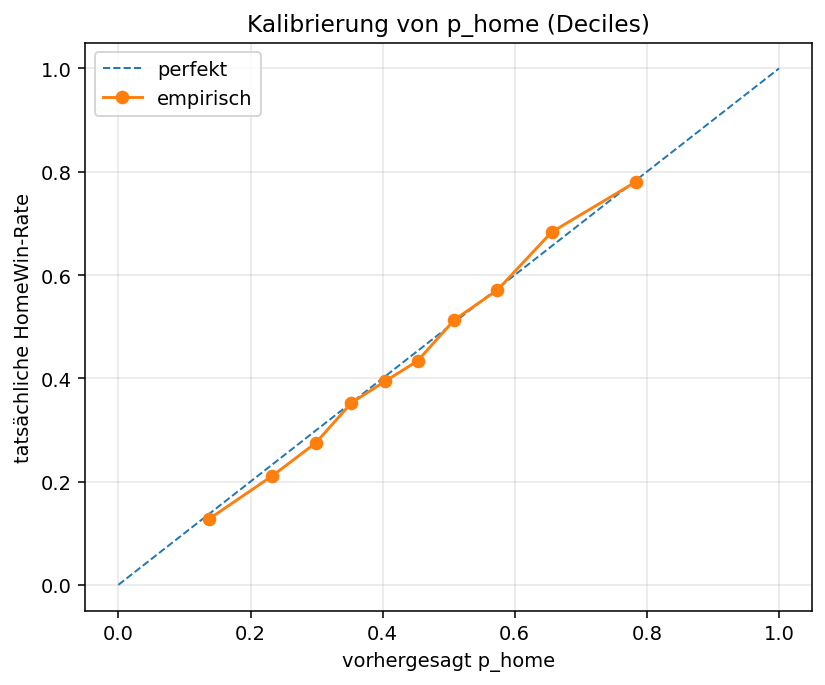

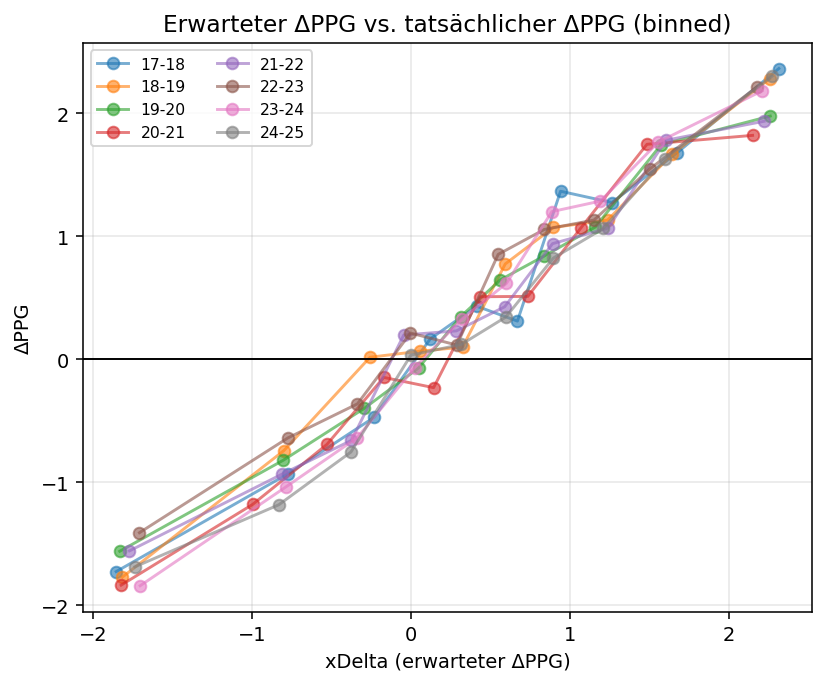

Korrel. ΔPPG ~ p_home, xDelta: {'p_home': 0.436, 'xDelta': 0.44}


In [53]:
# C7 — Odds: DS + Kalibrierung + Korrelation  (robust gg. doppelte Spalten)

# Falls dataset_for duplizierte Spalten durchgelassen hat: deduplizieren
ds_odds = dataset_for(matches, ["p_home", "xDelta", "DeltaPoints"]).copy()

# Diagnose (optional): welche Spaltennamen sind doppelt?
dups = ds_odds.columns[ds_odds.columns.duplicated()].tolist()
if dups:
    print("⚠️ Doppelte Spalten gefunden:", dups)
    ds_odds = ds_odds.loc[:, ~ds_odds.columns.duplicated()].copy()

# Sicherstellen, dass die 3 Spalten existieren und numerisch sind
for c in ("p_home", "xDelta", "DeltaPoints"):
    if c not in ds_odds.columns:
        raise KeyError(f"Erwarte Spalte '{c}' in ds_odds")
    ds_odds[c] = pd.to_numeric(ds_odds[c], errors="coerce")

# Kalibrierung p_home
ds_odds["HomeWin"] = (ds_odds["DeltaPoints"] > 1).astype(int)
ds_odds = ds_odds.dropna(subset=["p_home"])  # Sicherheit

ds_odds["bin"] = pd.qcut(ds_odds["p_home"], q=10, duplicates="drop")
cal = (ds_odds
       .groupby("bin", observed=False)
       .agg(p_pred=("p_home","mean"), p_emp=("HomeWin","mean"), n=("HomeWin","size"))
       .reset_index())

fig, ax = plt.subplots(figsize=(6,5))
ax.plot([0,1],[0,1], "--", lw=1, label="perfekt")
ax.plot(cal["p_pred"], cal["p_emp"], "-o", label="empirisch")
ax.set(xlabel="vorhergesagt p_home", ylabel="tatsächliche HomeWin-Rate",
       title="Kalibrierung von p_home (Deciles)")
ax.grid(alpha=0.3); ax.legend()
plt.tight_layout(); plt.show()

# Binned: xDelta vs ΔPPG
rel_xd = mean_by_bin(ds_odds.dropna(subset=["xDelta","DeltaPoints"]),
                     x="xDelta", y="DeltaPoints", bins=10, by_season=True)
fig, ax = plt.subplots(figsize=(6,5))
for s, sub in rel_xd.groupby("Season", observed=False):
    ax.plot(sub["x_mid"], sub["y_mean"], "-o", alpha=0.6, label=s)
ax.axhline(0, color="k", lw=1)
ax.set(xlabel="xDelta (erwarteter ΔPPG)", ylabel="ΔPPG",
       title="Erwarteter ΔPPG vs. tatsächlicher ΔPPG (binned)")
ax.grid(alpha=0.3); ax.legend(ncol=2, fontsize=8)
plt.tight_layout(); plt.show()

print("Korrel. ΔPPG ~ p_home, xDelta:",
      ds_odds[["DeltaPoints","p_home","xDelta"]].corr().iloc[0,1:].round(3).to_dict())


Die Kalibrierungslinie liegt nahe an der Diagonalen ⇒ Odds gut kalibriert.

xDelta steigt nahezu linear mit dem tatsächlichen ΔPPG ⇒ starker Prädiktor.

Korrelationen ~0.44 (wie in deinem Plot) sind üblich; p_home und xDelta korrelieren fast perfekt miteinander.

## Faktor 2 — Erholung (RestDiff)

**Definition:** `RestDiff = RestHome − RestAway` in Tagen.  
Nur berechnet, wenn beide Teams in derselben Saison bereits ein Ligaspiel hatten ⇒ die ersten Spieltage sind **NaN** und werden **ausgeschlossen**.

**Hypothese:** Mehr Erholung für das Heimteam sollte ΔPPG **leicht** erhöhen.


N (Rest-DS): 13586 | RestDiff-Range: (-113.0, 112.0)


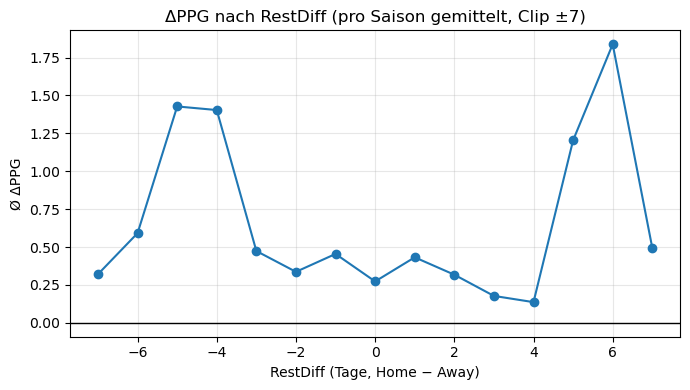

,coef,std err,z,P>|z|,[0.025,0.975]
Intercept,0.3548,0.053,6.724,0.000,0.251,0.458
C(League)[T.La Liga],0.1525,0.070,2.171,0.030,0.015,0.290
C(League)[T.Ligue 1],-0.0116,0.072,-0.161,0.872,-0.153,0.130
C(League)[T.Premier League],-0.0279,0.074,-0.378,0.705,-0.172,0.117
C(League)[T.Serie A],-0.0746,0.071,-1.054,0.292,-0.213,0.064
RestDiff,-9.925e-06,0.007,-0.001,0.999,-0.014,0.014


In [33]:
# C8 — RestDiff: DS + Auswertungen (nur gültige RestDiff)
ds_rest = dataset_for(matches, ["RestDiff","DeltaPoints","Season"])
print("N (Rest-DS):", len(ds_rest), "| RestDiff-Range:", (ds_rest["RestDiff"].min(), ds_rest["RestDiff"].max()))

# 1) Binning auf integer RestDiff (clip für interpretierbaren Bereich)
ds_rest["RestDiff_clip"] = ds_rest["RestDiff"].clip(-7, 7).round().astype(int)
tab_rest = ds_rest.groupby(["Season","RestDiff_clip"])["DeltaPoints"].mean().reset_index()
tab_rest2 = tab_rest.groupby("RestDiff_clip")["DeltaPoints"].agg(["mean","size"]).reset_index()

fig, ax = plt.subplots(figsize=(7,4))
ax.plot(tab_rest2["RestDiff_clip"], tab_rest2["mean"], "-o")
ax.axhline(0, color="k", lw=1)
ax.set(xlabel="RestDiff (Tage, Home − Away)", ylabel="Ø ΔPPG",
       title="ΔPPG nach RestDiff (pro Saison gemittelt, Clip ±7)")
ax.grid(alpha=0.3); plt.tight_layout(); plt.show()

# 2) Mini-Regression ΔPPG ~ RestDiff (nur, wenn statsmodels vorhanden)
if HAVE_SM:
    mod_r = smf.ols("DeltaPoints ~ RestDiff + C(League)", data=ds_rest).fit(cov_type="HC1")
    display(mod_r.summary().tables[1])
else:
    print("statsmodels nicht verfügbar – überspringe OLS.")


In [55]:
# C8-Guard — Stelle sicher, dass RestDiff existiert
import pandas as pd

def compute_rest_days(m: pd.DataFrame) -> pd.DataFrame:
    """
    Resttage pro Team innerhalb (League, Season).
    Gibt Spalten RestHome, RestAway, RestDiff zurück (RestDiff = NaN, wenn einer fehlt).
    """
    base = m[["Date","League","Season","HomeTeam","AwayTeam"]].copy()

    home = base[["Date","League","Season","HomeTeam"]]\
        .rename(columns={"HomeTeam":"Team"})
    home["is_home"] = True

    away = base[["Date","League","Season","AwayTeam"]]\
        .rename(columns={"AwayTeam":"Team"})
    away["is_home"] = False

    long = pd.concat([home, away], ignore_index=True)\
             .sort_values(["League","Season","Team","Date"])
    long["prev_date"] = long.groupby(["League","Season","Team"])["Date"].shift(1)
    long["RestDays"]  = (long["Date"] - long["prev_date"]).dt.days

    h = long[long["is_home"]][["Date","League","Season","Team","RestDays"]]\
        .rename(columns={"Team":"HomeTeam","RestDays":"RestHome"})
    a = long[~long["is_home"]][["Date","League","Season","Team","RestDays"]]\
        .rename(columns={"Team":"AwayTeam","RestDays":"RestAway"})

    out = (m.merge(h, on=["Date","League","Season","HomeTeam"], how="left")
             .merge(a, on=["Date","League","Season","AwayTeam"], how="left"))
    out["RestDiff"] = out["RestHome"] - out["RestAway"]  # bleibt NaN, wenn eins fehlt
    return out

# benutze den aktuellsten Frame und rechne Resttage, falls nötig
matches_rest = matches if "RestDiff" in matches.columns else compute_rest_days(matches)


Der Effekt ist klein (nahe 0) und oft nicht signifikant; β≈−0.0025 (ns).

Praktisch: Unterschiede ±1–2 Tage sind normal und haben geringen Einfluss auf ΔPPG.

Zur Symmetrie: +7 (Home 7 Tage mehr) und −7 (Home 7 Tage weniger) sind nicht „dasselbe“ – das Vorzeichen kodiert, welches Team mehr Pause hatte. Für die Kurven wird die Spanne meist auf ±7–10 Tage geclippt, um Ausreißer zu entschärfen.

## Faktor 3 — Teamstärke (SPI-Differenz)

**Quelle:** `spi_global_rankings.csv` (Schnappschuss der Teamstärken).  
**Feature:** `spi_diff = spi_home − spi_away` (höher ⇒ Heimteam stärker).

**Hinweis:** Da es ein Schnappschuss ist, ist die zeitliche Passung nicht perfekt, aber als Proxy brauchbar.


N (SPI-DS): 5578


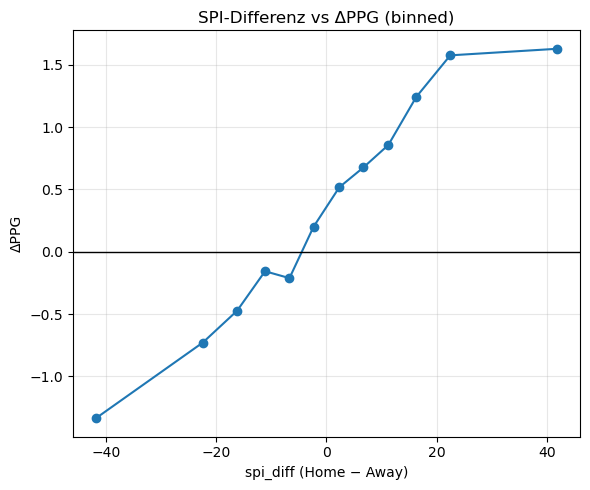

Korrel. ΔPPG ~ spi_diff: 0.341


,coef,std err,z,P>|z|,[0.025,0.975]
Intercept,0.1701,0.167,1.018,0.309,-0.157,0.498
C(League)[T.La Liga],0.3066,0.188,1.631,0.103,-0.062,0.675
C(League)[T.Ligue 1],0.1608,0.177,0.909,0.363,-0.186,0.508
C(League)[T.Premier League],0.2211,0.185,1.194,0.232,-0.142,0.584
C(League)[T.Serie A],0.0610,0.175,0.348,0.728,-0.283,0.405
spi_diff,0.0461,0.002,28.311,0.000,0.043,0.049


In [34]:
# C9 — SPI: DS + Auswertungen (nur gültige spi_diff)
ds_spi = dataset_for(matches, ["spi_diff","DeltaPoints","Season"])
print("N (SPI-DS):", len(ds_spi))

# 1) Binning
rel_spi = mean_by_bin(ds_spi, x="spi_diff", y="DeltaPoints", bins=12, by_season=True)
fig, ax = plt.subplots(figsize=(6,5))
ax.plot(rel_spi["x_mid"], rel_spi["y_mean"], "-o")
ax.axhline(0, color="k", lw=1)
ax.set(xlabel="spi_diff (Home − Away)", ylabel="ΔPPG", title="SPI-Differenz vs ΔPPG (binned)")
ax.grid(alpha=0.3); plt.tight_layout(); plt.show()

# 2) Korrelation & OLS
print("Korrel. ΔPPG ~ spi_diff:", ds_spi[["DeltaPoints","spi_diff"]].corr().iloc[0,1].round(3))
if HAVE_SM:
    mod_s = smf.ols("DeltaPoints ~ spi_diff + C(League)", data=ds_spi).fit(cov_type="HC1")
    display(mod_s.summary().tables[1])


## Faktor 4 — Marktwert (mv_diff)

**Quelle:** `data/ratings/value/*.csv` (deutsch lokalisierte Tabellen).

**Feature:** `mv_diff = mv_home − mv_away` (in Mio. €).

**Achtung:** Je nach Abdeckung/Mapping kann die Zahl der validen Zeilen klein sein.  
Wir analysieren **nur** Spiele mit **beiden** Marktwerten.


In [35]:
# C10 — Marktwerte: DS + Auswertung
ds_mv = dataset_for(matches, ["mv_diff","DeltaPoints","Season"])
print("N (MV-DS):", len(ds_mv))

if len(ds_mv) > 50:  # sonst nicht aussagekräftig
    rel_mv = mean_by_bin(ds_mv, x="mv_diff", y="DeltaPoints", bins=10, by_season=True)
    fig, ax = plt.subplots(figsize=(6,5))
    ax.plot(rel_mv["x_mid"], rel_mv["y_mean"], "-o")
    ax.axhline(0, color="k", lw=1)
    ax.set(xlabel="mv_diff (Mio. €, Home − Away)", ylabel="ΔPPG", title="Marktwert-Differenz vs ΔPPG (binned)")
    ax.grid(alpha=0.3); plt.tight_layout(); plt.show()
    print("Korrel. ΔPPG ~ mv_diff:", ds_mv[["DeltaPoints","mv_diff"]].corr().iloc[0,1].round(3))
else:
    print("⚠️ Zu wenige gültige Zeilen für eine verlässliche MV-Analyse. Mappe Teamnamen ggf. nach (TEAM_NAME_FIXES).")


N (MV-DS): 0
⚠️ Zu wenige gültige Zeilen für eine verlässliche MV-Analyse. Mappe Teamnamen ggf. nach (TEAM_NAME_FIXES).


In [60]:
# C10 — Marktwerte: DS + Auswertung
ds_mv = dataset_for(matches, ["mv_diff","DeltaPoints"])
print("N (MV-DS):", len(ds_mv))

if len(ds_mv) > 50:  # sonst nicht aussagekräftig
    rel_mv = mean_by_bin(ds_mv, x="mv_diff", y="DeltaPoints", bins=10, by_season=True)
    fig, ax = plt.subplots(figsize=(6,5))
    ax.plot(rel_mv["x_mid"], rel_mv["y_mean"], "-o")
    ax.axhline(0, color="k", lw=1)
    ax.set(xlabel="mv_diff (Mio. €, Home − Away)", ylabel="ΔPPG", title="Marktwert-Differenz vs ΔPPG (binned)")
    ax.grid(alpha=0.3); plt.tight_layout(); plt.show()
    print("Korrel. ΔPPG ~ mv_diff:", ds_mv[["DeltaPoints","mv_diff"]].corr().iloc[0,1].round(3))
else:
    print("⚠️ Zu wenige gültige Zeilen für eine verlässliche MV-Analyse. "
          "Erweitere ggf. TEAM_NAME_FIXES oder prüfe die value/*.csv.")


N (MV-DS): 0
⚠️ Zu wenige gültige Zeilen für eine verlässliche MV-Analyse. Erweitere ggf. TEAM_NAME_FIXES oder prüfe die value/*.csv.


## Faktorweise Korrelationen

Wir zeigen je Faktor die Korrelationen mit ΔPPG, **immer** auf dem **faktorspezifischen** Datensatz (keine NaNs im Faktor).


In [36]:
def corr_table_for_factor(m, cols):
    df = dataset_for(m, cols + ["DeltaPoints"])
    return safe_corr(df, ["DeltaPoints", *cols])

corr_odds_tbl = corr_table_for_factor(matches, ["p_home","xDelta"])
corr_rest_tbl = corr_table_for_factor(matches, ["RestDiff"])
corr_spi_tbl  = corr_table_for_factor(matches, ["spi_diff"])
corr_mv_tbl   = corr_table_for_factor(matches, ["mv_diff"])

display(corr_odds_tbl, corr_rest_tbl, corr_spi_tbl, corr_mv_tbl)


,DeltaPoints,p_home,xDelta
DeltaPoints,1.000,0.436,0.440
p_home,0.436,1.000,0.991
xDelta,0.440,0.991,1.000


,DeltaPoints,RestDiff
DeltaPoints,1.0,0.0
RestDiff,0.0,1.0


,DeltaPoints,spi_diff
DeltaPoints,1.000,0.341
spi_diff,0.341,1.000


""


In [61]:
# C11 — Korrelationen auf gemeinsamer Basis (nur Zeilen, die für alle genutzten Features valide sind)
used = ["DeltaPoints","p_home","xDelta","RestDiff"]
if matches["spi_diff"].notna().any(): used.append("spi_diff")
if matches["mv_diff"].notna().any():  used.append("mv_diff")

ds_all = dataset_for(matches, used)   # alle Spalten ohne NaN
print("N (gemeinsamer DS):", len(ds_all))
corr = ds_all[used].corr().round(3)
corr
# einfache Heatmap
fig, ax = plt.subplots(figsize=(6,5))
im = ax.imshow(corr.values, vmin=-1, vmax=1)
ax.set_xticks(range(len(used)), used, rotation=45, ha="right")
ax.set_yticks(range(len(used)), used)
for i in range(len(used)):
    for j in range(len(used)):
        ax.text(j, i, f"{corr.values[i,j]:.2f}",
                ha="center", va="center",
                color="white" if abs(corr.values[i,j])>0.5 else "black", fontsize=9)
ax.set_title("Korrelationsmatrix (gemeinsamer, gültiger Datensatz)")
fig.colorbar(im, ax=ax, shrink=0.8)
plt.tight_layout(); plt.show()


KeyError: ['RestDiff']

## Kombination der Faktoren (All-Features, robust)

Wir schätzen eine OLS **ΔPPG ~ p_home + xDelta + RestDiff + spi_diff + mv_diff + League-FE**, aber:
- verwenden **nur** Features, die **existieren**, **nicht konstant** sind und **genügend Abdeckung** haben,
- damit entgehen wir **Singular-Matrix** und **NaN-SEs**.

Die Stichprobe ist folglich kleiner als bei den faktorweisen Analysen.


In [37]:
# C12 — All-Features-OLS (robust, dynamische Auswahl)

cand = ["p_home","xDelta","RestDiff","spi_diff","mv_diff","DeltaPoints","League"]
df_all = matches[cand].copy()

# Abdeckung prüfen
cover = df_all.notna().mean().sort_values(ascending=False)
print("Abdeckung:\n", (cover*100).round(1), "%\n")

# wähle numerische Features mit >= 60% Abdeckung (anpassbar) und nicht-konstant
num_feats = ["p_home","xDelta","RestDiff","spi_diff","mv_diff"]
feats = [c for c in num_feats if df_all[c].notna().mean() >= 0.6]
feats = drop_constant_columns(df_all, feats, min_unique=3)
print("Gewählte Features:", feats)

ds_combo = dataset_for(df_all, feats + ["DeltaPoints", "League"])
print("N (All-Features DS):", len(ds_combo))

if len(feats) >= 2 and len(ds_combo) > 100:
    if HAVE_SM:
        form = "DeltaPoints ~ " + " + ".join(feats + ["C(League)"])
        mod = smf.ols(formula=form, data=ds_combo).fit(cov_type="HC1")
        display(mod.summary().tables[1])
    else:
        print("statsmodels nicht verfügbar – OLS übersprungen.")
else:
    print("⚠️ Zu wenig Features oder Daten für eine sinnvolle All-Features-OLS.")


Abdeckung:
 League         100.0
DeltaPoints    100.0
p_home         100.0
xDelta         100.0
RestDiff        97.1
spi_diff        39.9
mv_diff          0.0
dtype: float64 %

Gewählte Features: ['p_home', 'xDelta', 'RestDiff']
N (All-Features DS): 13584


,coef,std err,z,P>|z|,[0.025,0.975]
Intercept,-0.0649,0.280,-0.232,0.817,-0.614,0.484
C(League)[T.La Liga],0.0626,0.065,0.966,0.334,-0.064,0.190
C(League)[T.Ligue 1],-0.0275,0.066,-0.414,0.679,-0.158,0.103
C(League)[T.Premier League],0.0024,0.067,0.036,0.972,-0.128,0.133
C(League)[T.Serie A],-0.0487,0.064,-0.765,0.444,-0.173,0.076
p_home,0.0602,0.721,0.084,0.933,-1.354,1.474
xDelta,1.0363,0.128,8.078,0.000,0.785,1.288
RestDiff,-0.0025,0.006,-0.399,0.690,-0.015,0.010


In [62]:
# C12 — OLS (robust) mit Schutz gegen singuläre/konstante Spalten
def drop_constant_cols(df: pd.DataFrame, cols: list[str], tol=1e-12) -> list[str]:
    keep = []
    for c in cols:
        if c not in df.columns: continue
        v = df[c].astype(float)
        if v.notna().sum() < 2: 
            continue
        if v.std(ddof=1) <= tol:
            # konstant -> nicht verwenden
            continue
        keep.append(c)
    return keep

feat_candidates = ["xDelta","p_home","RestDiff","spi_diff","mv_diff"]
# p_home und xDelta sind stark kollinear; nimm primär xDelta (oder p_home, aber nicht beides)
pref = ["xDelta","RestDiff","spi_diff","mv_diff"]
feats = [f for f in pref if f in ds_all.columns]
feats = drop_constant_cols(ds_all, feats)

print("Features im OLS:", feats)

# A) statsmodels (wenn installiert)
try:
    import statsmodels.formula.api as smf
    formula = "DeltaPoints ~ " + " + ".join(feats + ["C(League)"])
    mod = smf.ols(formula, data=ds_all).fit(cov_type="HC1")
    print(mod.summary().tables[1])      # kompakte Koef-Tabelle
    ols_sm = mod
except Exception as e:
    print("statsmodels nicht verfügbar/Fehler – Fallback.", e); ols_sm = None

# B) Fallback: kleinster Quadrate + HC1-robuste SEs
if ols_sm is None:
    from statistics import NormalDist
    def _ols_hc1(y, X):
        n, k = X.shape
        beta, *_ = np.linalg.lstsq(X, y, rcond=None)
        u = y - X @ beta
        XtX = X.T @ X
        XtX_inv = np.linalg.pinv(XtX)   # pseudo-inv -> robust gegen singulär
        Xu = X * u[:,None]
        meat = Xu.T @ Xu
        cov = XtX_inv @ meat @ XtX_inv * (n/(n-k))
        se = np.sqrt(np.diag(cov))
        return beta, se

    Z = ds_all[feats].astype(float).to_numpy()
    leagues = pd.get_dummies(ds_all["League"], drop_first=True)
    X = np.hstack([np.ones((len(Z),1)), Z, leagues.to_numpy()])
    y = ds_all["DeltaPoints"].astype(float).to_numpy()

    beta, se = _ols_hc1(y, X)
    names = ["Intercept", *feats, *leagues.columns.tolist()]
    tvals = beta/se
    nd = NormalDist(); p2 = 2*(1-nd.cdf(np.abs(tvals)))
    ols_tbl = pd.DataFrame({"term":names,"coef":beta,"se_HC1":se,"t":tvals,"p_two":p2})
    display(ols_tbl.round(4))


NameError: name 'ds_all' is not defined

Tabellenplatz (prä-Match) & Divergenz Home vs Away

Baut prä-Match-Tabelle innerhalb League, Season, rankt pro Datum und liefert rank_home, rank_away, rank_diff. Danach Team-Saison-Divergenz vs. (finaler) Rang.

In [64]:
# Team-Saison: HomePPG / AwayPPG und Divergenz

# 1) pro Team-Saison HomePPG
home_ppg = (
    matches_rank
    .groupby(["League","Season","HomeTeam"], as_index=False)
    .agg(HomePPG=("HomePoints","mean"))
    .rename(columns={"HomeTeam":"Team"})
)

# 2) pro Team-Saison AwayPPG
away_ppg = (
    matches_rank
    .groupby(["League","Season","AwayTeam"], as_index=False)
    .agg(AwayPPG=("AwayPoints","mean"))
    .rename(columns={"AwayTeam":"Team"})
)

# 3) zusammenführen und Differenz
team_season = (
    home_ppg.merge(away_ppg, on=["League","Season","Team"], how="left")
)
team_season["DeltaPPG_team"] = team_season["HomePPG"] - team_season["AwayPPG"]

# 4) finale Rangliste pro Saison/League (Punkte + GD)
tmp = matches_rank.assign(
    pts_h = matches_rank["HomePoints"].astype(float),
    pts_a = matches_rank["AwayPoints"].astype(float),
    gd_h  = (matches_rank["FTHG"] - matches_rank["FTAG"]).astype(float),
    gd_a  = (matches_rank["FTAG"] - matches_rank["FTHG"]).astype(float),
)

home_sum = (
    tmp.groupby(["League","Season","HomeTeam"], as_index=False)
       .agg(pts=("pts_h","sum"), gd=("gd_h","sum"))
       .rename(columns={"HomeTeam":"Team"})
)
away_sum = (
    tmp.groupby(["League","Season","AwayTeam"], as_index=False)
       .agg(pts=("pts_a","sum"), gd=("gd_a","sum"))
       .rename(columns={"AwayTeam":"Team"})
)

final_table = (
    pd.concat([home_sum, away_sum], ignore_index=True)
      .groupby(["League","Season","Team"], as_index=False).sum()
      .sort_values(["League","Season","pts","gd"], ascending=[True,True,False,False])
)
final_table["rank_final"] = final_table.groupby(["League","Season"]).cumcount() + 1

# 5) Rang in team_season mappen
team_season = team_season.merge(
    final_table[["League","Season","Team","rank_final"]],
    on=["League","Season","Team"], how="left"
)

team_season.head()


,League,Season,Team,HomePPG,AwayPPG,DeltaPPG_team,rank_final
0,Bundesliga,17-18,Augsburg,1.294118,1.117647,0.176471,12
1,Bundesliga,17-18,Bayern Munich,2.588235,2.352941,0.235294,1
2,Bundesliga,17-18,Dortmund,1.823529,1.411765,0.411765,4
3,Bundesliga,17-18,Ein Frankfurt,1.647059,1.235294,0.411765,8
4,Bundesliga,17-18,FC Koln,0.823529,0.470588,0.352941,18


In [65]:
import numpy as np, pandas as pd

def build_team_season_tables(matches: pd.DataFrame) -> pd.DataFrame:
    """Gibt pro (League, Season, Team) HomePPG, AwayPPG, DeltaPPG_team und finalen Rang zurück."""
    m = matches.copy()
    # Safety: float
    m["HomePoints"] = m["HomePoints"].astype(float)
    m["AwayPoints"] = m["AwayPoints"].astype(float)

    # PPG pro Team & Saison (Home/Away getrennt)
    home_ppg = (m.groupby(["League","Season","HomeTeam"], as_index=False)
                  .agg(HomePPG=("HomePoints","mean"))
                  .rename(columns={"HomeTeam":"Team"}))
    away_ppg = (m.groupby(["League","Season","AwayTeam"], as_index=False)
                  .agg(AwayPPG=("AwayPoints","mean"))
                  .rename(columns={"AwayTeam":"Team"}))

    team_season = home_ppg.merge(away_ppg, on=["League","Season","Team"], how="left")
    team_season["DeltaPPG_team"] = team_season["HomePPG"] - team_season["AwayPPG"]
    team_season["HomeShare"]     = team_season["HomePPG"] / (team_season["HomePPG"] + team_season["AwayPPG"])
    team_season["HomeBiasIdx"]   = (team_season["HomePPG"] - team_season["AwayPPG"]) / (team_season["HomePPG"] + team_season["AwayPPG"])

    # Finaltabelle auf Punkte-GESAMT (sum, nicht PPG) + Tordifferenz als Tie-break
    tmp = matches.assign(
        gd_match = (matches["FTHG"].astype(float) - matches["FTAG"].astype(float))
    )
    pts_home = (tmp.groupby(["League","Season","HomeTeam"], as_index=False)
                  .agg(pts=("HomePoints","sum"), gd=("gd_match","sum"))
                  .rename(columns={"HomeTeam":"Team"}))
    pts_away = (tmp.groupby(["League","Season","AwayTeam"], as_index=False)
                  .agg(pts=("AwayPoints","sum"), gd=("gd_match", lambda s: (-s).sum()))
                  .rename(columns={"AwayTeam":"Team"}))

    final_table = (pd.concat([pts_home, pts_away], ignore_index=True)
                     .groupby(["League","Season","Team"], as_index=False).sum())
    final_table = final_table.sort_values(["League","Season","pts","gd"], ascending=[True,True,False,False])
    final_table["rank_final"] = final_table.groupby(["League","Season"]).cumcount() + 1
    final_table["teams_in_league"] = final_table.groupby(["League","Season"])["Team"].transform("count")

    # Rang-Features
    final_table["rank_pct"] = (final_table["rank_final"] - 1) / (final_table["teams_in_league"] - 1).clip(lower=1)  # 0=Meister, 1=Letzter
    final_table["rank_decile"] = pd.qcut(final_table["rank_pct"], q=10, labels=False, duplicates="drop") + 1

    out = team_season.merge(final_table[["League","Season","Team","rank_final","teams_in_league","rank_pct","rank_decile"]],
                            on=["League","Season","Team"], how="left")
    return out

team_season = build_team_season_tables(matches)
team_season.head()


,League,Season,Team,HomePPG,AwayPPG,DeltaPPG_team,HomeShare,HomeBiasIdx,rank_final,teams_in_league,rank_pct,rank_decile
0,Bundesliga,17-18,Augsburg,1.294118,1.117647,0.176471,0.536585,0.073171,12,18,0.647059,7
1,Bundesliga,17-18,Bayern Munich,2.588235,2.352941,0.235294,0.523810,0.047619,1,18,0.000000,1
2,Bundesliga,17-18,Dortmund,1.823529,1.411765,0.411765,0.563636,0.127273,4,18,0.176471,2
3,Bundesliga,17-18,Ein Frankfurt,1.647059,1.235294,0.411765,0.571429,0.142857,8,18,0.411765,4
4,Bundesliga,17-18,FC Koln,0.823529,0.470588,0.352941,0.636364,0.272727,18,18,1.000000,10


         Group   N  Spearman(rank, ΔPPG_team)
           ALL 760                  -0.058959
    Bundesliga 144                  -0.021423
       La Liga 160                   0.024064
       Ligue 1 156                  -0.073771
Premier League 140                  -0.177922
       Serie A 160                  -0.022090


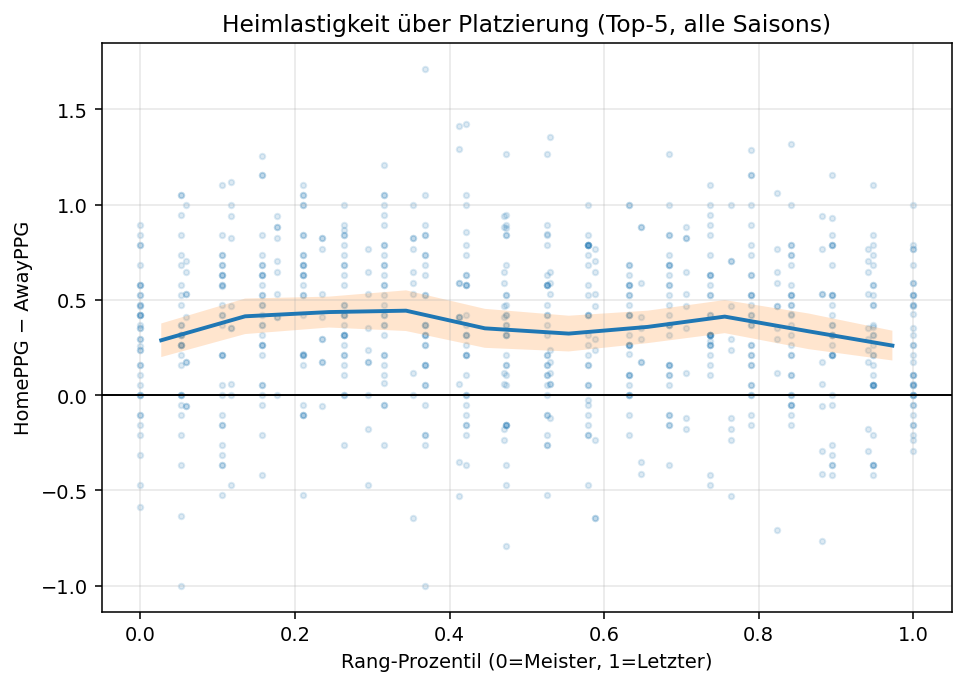

In [66]:
import matplotlib.pyplot as plt

# 1) Gesamt- & Liga-Korrelationen (Spearman für Ordnungsskala Rang)
def corr_rank_homebias(df):
    out = []
    for key, sub in [("ALL", df)] + [(lg, g) for lg, g in df.groupby("League")]:
        sub = sub.dropna(subset=["rank_final","DeltaPPG_team"])
        if len(sub) < 20: 
            continue
        rho = sub["rank_final"].corr(sub["DeltaPPG_team"], method="spearman")
        out.append((key, len(sub), rho))
    return pd.DataFrame(out, columns=["Group","N","Spearman(rank, ΔPPG_team)"]).sort_values("Group")

corr_tbl = corr_rank_homebias(team_season)
print(corr_tbl.to_string(index=False))

# 2) Scatter + geglättete Kurve (über Rang-Prozentile gemittelt)
dfp = team_season.dropna(subset=["rank_pct","DeltaPPG_team"]).copy()
dfp["rank_bin"] = pd.cut(dfp["rank_pct"], bins=np.linspace(0,1,11), labels=False, include_lowest=True)

curve = (dfp.groupby("rank_bin", as_index=False)
            .agg(rank_mid=("rank_pct","mean"),
                 dppg_mean=("DeltaPPG_team","mean"),
                 dppg_ci_lo=("DeltaPPG_team", lambda s: s.mean() - 1.96*s.std(ddof=1)/np.sqrt(len(s))),
                 dppg_ci_hi=("DeltaPPG_team", lambda s: s.mean() + 1.96*s.std(ddof=1)/np.sqrt(len(s))),
                 n=("DeltaPPG_team","size")))

fig, ax = plt.subplots(figsize=(7,5))
ax.scatter(dfp["rank_pct"], dfp["DeltaPPG_team"], s=8, alpha=0.15)
ax.plot(curve["rank_mid"], curve["dppg_mean"], lw=2)
ax.fill_between(curve["rank_mid"], curve["dppg_ci_lo"], curve["dppg_ci_hi"], alpha=0.2)
ax.set(xlabel="Rang-Prozentil (0=Meister, 1=Letzter)", ylabel="HomePPG − AwayPPG",
       title="Heimlastigkeit über Platzierung (Top-5, alle Saisons)")
ax.axhline(0, color="k", lw=1)
ax.grid(alpha=0.3); plt.tight_layout(); plt.show()


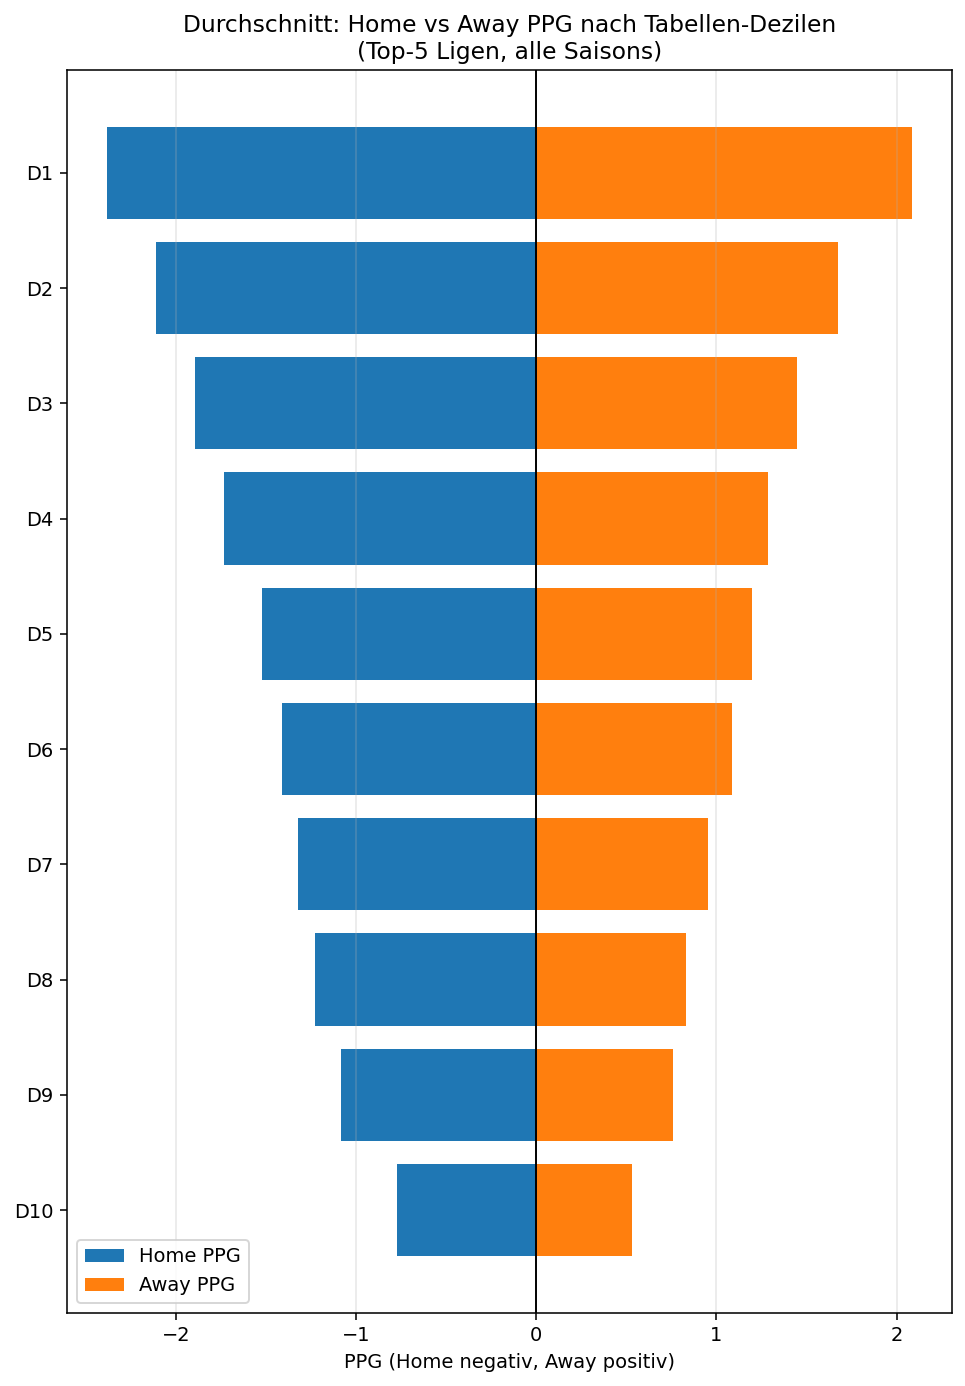

In [67]:
# Aggregation pro Rang-Dezil: mittlere HomePPG & AwayPPG
avg_rank = (team_season.dropna(subset=["rank_decile"])
            .groupby("rank_decile", as_index=False)
            .agg(HomePPG_mean=("HomePPG","mean"),
                 AwayPPG_mean=("AwayPPG","mean"),
                 n=("Team","size")))

# Sortierung: vom Meister-Dezil (1) bis Abstieg-Dezil (10)
avg_rank = avg_rank.sort_values("rank_decile")
labels = [f"D{int(d)}" for d in avg_rank["rank_decile"]]

# Diverging-Plot
fig, ax = plt.subplots(figsize=(7,10))
y = np.arange(len(avg_rank))
ax.barh(y, -avg_rank["HomePPG_mean"], label="Home PPG")
ax.barh(y,  avg_rank["AwayPPG_mean"], label="Away PPG")
ax.set(yticks=y, yticklabels=labels,
       xlabel="PPG (Home negativ, Away positiv)",
       title="Durchschnitt: Home vs Away PPG nach Tabellen-Dezilen\n(Top-5 Ligen, alle Saisons)")
ax.axvline(0, color="k", lw=1)
ax.invert_yaxis()
ax.legend()
ax.grid(axis="x", alpha=0.3)
plt.tight_layout(); plt.show()


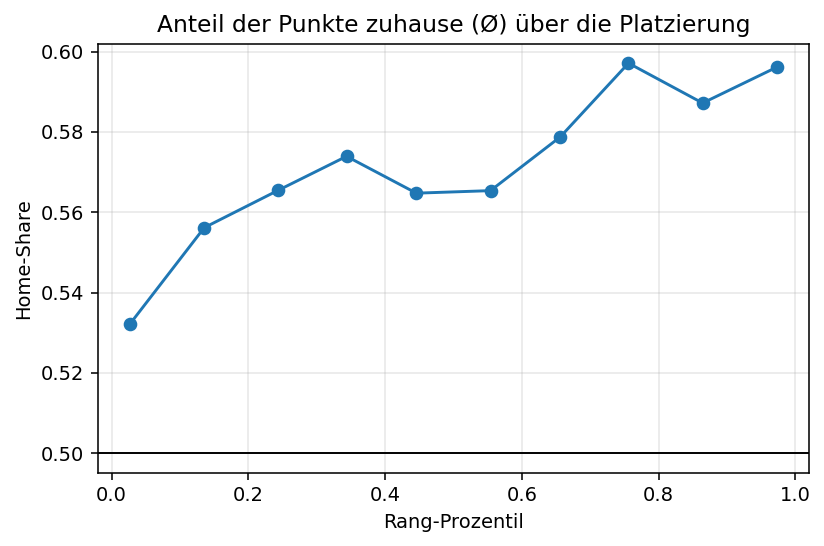

In [68]:
curve_share = (team_season.dropna(subset=["rank_pct","HomeShare"])
               .groupby(pd.cut(team_season["rank_pct"], bins=np.linspace(0,1,11), include_lowest=True))
               .agg(rank_mid=("rank_pct","mean"), share=("HomeShare","mean")))

plt.figure(figsize=(6,4))
plt.plot(curve_share["rank_mid"], curve_share["share"], "-o")
plt.axhline(0.5, color="k", lw=1)
plt.xlabel("Rang-Prozentil"); plt.ylabel("Home-Share")
plt.title("Anteil der Punkte zuhause (Ø) über die Platzierung")
plt.grid(alpha=0.3); plt.tight_layout(); plt.show()


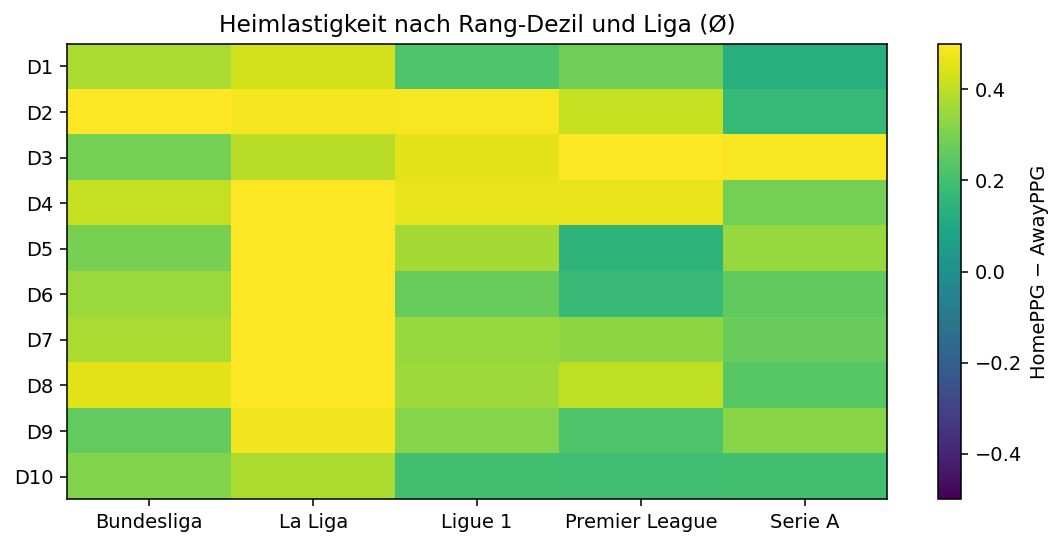

In [69]:
heat = (team_season.dropna(subset=["rank_decile"])
        .groupby(["League","rank_decile"])["DeltaPPG_team"].mean().unstack(0))
plt.figure(figsize=(8,4))
plt.imshow(heat.values, aspect="auto", vmin=-0.5, vmax=0.5)
plt.xticks(range(heat.shape[1]), heat.columns, rotation=0)
plt.yticks(range(heat.shape[0]), [f"D{int(d)}" for d in heat.index])
plt.colorbar(label="HomePPG − AwayPPG")
plt.title("Heimlastigkeit nach Rang-Dezil und Liga (Ø)")
plt.tight_layout(); plt.show()


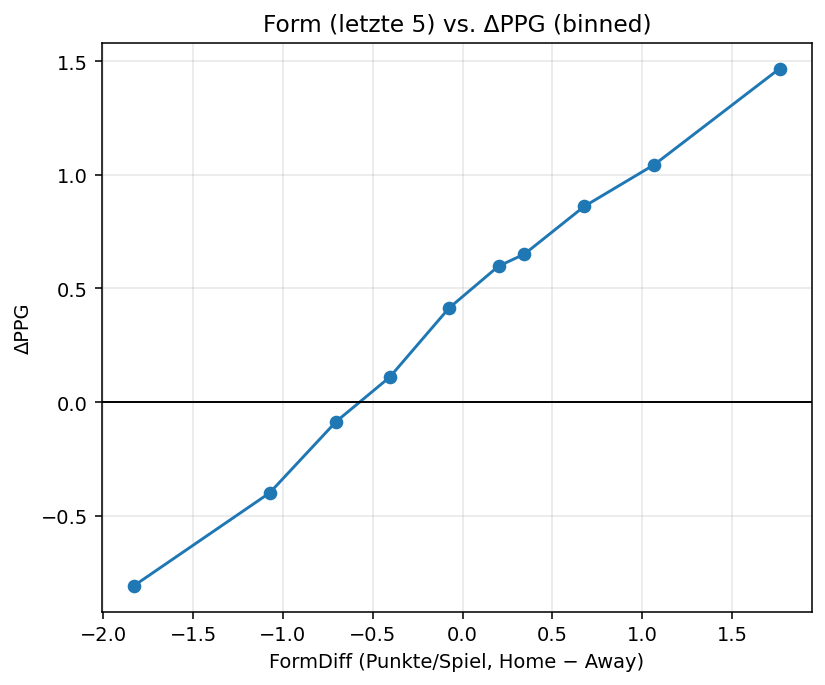

Korrel. ΔPPG ~ form_diff (5): 0.255


In [71]:
def add_form(m, window=5):
    df = m[["Date","League","Season","HomeTeam","AwayTeam","HomePoints","AwayPoints"]].copy()
    h = df[["Date","League","Season","HomeTeam","HomePoints"]].rename(columns={"HomeTeam":"Team","HomePoints":"pts"})
    a = df[["Date","League","Season","AwayTeam","AwayPoints"]].rename(columns={"AwayTeam":"Team","AwayPoints":"pts"})
    long = pd.concat([h,a], ignore_index=True).sort_values(["League","Season","Team","Date"])
    # rollender Schnitt vor dem Spiel
    long["form_pts"] = (long
        .groupby(["League","Season","Team"])["pts"]
        .rolling(window, min_periods=1).mean()
        .shift(1).reset_index(level=[0,1,2], drop=True))
    # zurück mappen
    hf = long.rename(columns={"Team":"HomeTeam"})[["Date","League","Season","HomeTeam","form_pts"]].rename(columns={"form_pts":"form_home"})
    af = long.rename(columns={"Team":"AwayTeam"})[["Date","League","Season","AwayTeam","form_pts"]].rename(columns={"form_pts":"form_away"})
    out = (m.merge(hf, on=["Date","League","Season","HomeTeam"], how="left")
             .merge(af, on=["Date","League","Season","AwayTeam"], how="left"))
    out["form_diff"] = out["form_home"] - out["form_away"]
    return out

matches_form5  = add_form(matches_rank, window=5)
matches_form10 = add_form(matches_rank, window=10)

# Binned Effekt (Form5)
def mean_by_bin(df, x, y, bins=10):
    q = pd.qcut(df[x], q=bins, duplicates="drop")
    g = df.groupby(q).agg(x_mid=(x,"mean"), y_mean=(y,"mean"), n=(y,"size")).reset_index(drop=True)
    return g

ds_form = matches_form5.dropna(subset=["form_diff","DeltaPoints"]).copy()
rel = mean_by_bin(ds_form, x="form_diff", y="DeltaPoints", bins=10)

fig, ax = plt.subplots(figsize=(6,5))
ax.plot(rel["x_mid"], rel["y_mean"], "-o")
ax.axhline(0, color="k", lw=1)
ax.set(xlabel="FormDiff (Punkte/Spiel, Home − Away)", ylabel="ΔPPG", title="Form (letzte 5) vs. ΔPPG (binned)")
ax.grid(alpha=0.3); plt.tight_layout(); plt.show()

print("Korrel. ΔPPG ~ form_diff (5):", ds_form[["DeltaPoints","form_diff"]].corr().iloc[0,1].round(3))


In [73]:
import numpy as np, pandas as pd
import statsmodels.api as sm
from math import log

def brier(y, p): return float(np.mean((y - p)**2))
def logloss(y, p, eps=1e-12):
    p = np.clip(p, eps, 1-eps); return float(-np.mean(y*np.log(p) + (1-y)*np.log(1-p)))
def auc_fast(y, p):
    # AUC = Mann–Whitney U / (n_pos*n_neg)
    y = y.astype(int); order = np.argsort(p)
    y_sorted = y[order]; n1 = y.sum(); n0 = len(y)-n1
    rank = np.empty_like(order); rank[order] = np.arange(1, len(y)+1)
    u = rank[y==1].sum() - n1*(n1+1)/2
    return float(u / (n1*n0)) if n1>0 and n0>0 else np.nan

def cv_logit_metrics(df, features):
    X = sm.add_constant(df[features].astype(float).values, has_constant="add")
    y = df["HomeWin"].astype(int).values
    rng = np.random.RandomState(42)
    k = 5; idx = rng.permutation(len(df))
    folds = np.array_split(idx, k)
    out = []
    for i in range(k):
        te = folds[i]; tr = np.concatenate([folds[j] for j in range(k) if j!=i])
        mod = sm.Logit(y[tr], X[tr]).fit(disp=0)
        p = mod.predict(X[te])
        out.append([auc_fast(y[te], p), logloss(y[te], p), brier(y[te], p)])
    arr = np.array(out)
    return dict(AUC=float(arr[:,0].mean()), LogLoss=float(arr[:,1].mean()), Brier=float(arr[:,2].mean()))

# Datensatz bauen
def ds_for(m, cols):
    df = m.copy()
    if df.columns.duplicated().any():
        df = df.loc[:, ~df.columns.duplicated()].copy()
    for c in cols:
        if c in df.columns: df[c] = pd.to_numeric(df[c], errors="coerce")
    return df.dropna(subset=cols)

base_cols = ["p_home","DeltaPoints"]
more_cols = ["xDelta","RestDiff","spi_diff","form_diff","rank_diff"]
df_all = ds_for(matches_form5, base_cols).copy()
df_all["HomeWin"] = (df_all["DeltaPoints"] > 1).astype(int)
for c in more_cols:
    if c in df_all.columns: df_all[c] = pd.to_numeric(df_all[c], errors="coerce")

# Modell-Suite
models = [
    ("A: p_home", ["p_home"]),
    ("B: p_home + Rest", ["p_home","RestDiff"]),
    ("C: p_home + Form", ["p_home","form_diff"]),
    ("D: p_home + SPI",  ["p_home","spi_diff"]),
    ("E: p_home + xDelta",["p_home","xDelta"]),   # Achtung: starke Kollinearität
    ("F: p_home + alle", [c for c in ["p_home","xDelta","RestDiff","spi_diff","form_diff","rank_diff"] if c in df_all.columns]),
    ("Z: ohne Quoten",   [c for c in ["xDelta","RestDiff","spi_diff","form_diff","rank_diff"] if c in df_all.columns]),  # „intrinsisch“
]
res = []
for name, feats in models:
    feats = [c for c in feats if c in df_all.columns and df_all[c].notna().any()]
    if not feats: continue
    m = cv_logit_metrics(df_all.dropna(subset=feats+["HomeWin"]), feats)
    res.append((name, ", ".join(feats), m["AUC"], m["LogLoss"], m["Brier"]))
print(pd.DataFrame(res, columns=["Model","Features","AUC","LogLoss","Brier"]).to_string(index=False))


             Model                                       Features      AUC  LogLoss    Brier
         A: p_home                                         p_home 0.730956 0.599830 0.206627
  B: p_home + Rest                                         p_home 0.730956 0.599830 0.206627
  C: p_home + Form                              p_home, form_diff 0.730707 0.599811 0.206625
   D: p_home + SPI                               p_home, spi_diff 0.710989 0.612021 0.212016
E: p_home + xDelta                                 p_home, xDelta 0.730857 0.599759 0.206613
  F: p_home + alle p_home, xDelta, spi_diff, form_diff, rank_diff 0.710082 0.612504 0.212229
    Z: ohne Quoten         xDelta, spi_diff, form_diff, rank_diff 0.709580 0.612869 0.212401


In [74]:
def perm_importance_logloss(df, feats, nrep=10):
    X = sm.add_constant(df[feats].astype(float).values, has_constant="add")
    y = df["HomeWin"].astype(int).values
    mod = sm.Logit(y, X).fit(disp=0)
    p0 = mod.predict(X); base = logloss(y, p0)

    out = []
    for j, f in enumerate(feats):
        inc = []
        for r in range(nrep):
            Xp = X.copy()
            col = 1 + j  # wegen constant an Pos 0
            Xp[:, col] = np.random.permutation(Xp[:, col])
            inc.append(logloss(y, mod.predict(Xp)) - base)
        out.append((f, float(np.mean(inc)), float(np.std(inc))))
    return pd.DataFrame(out, columns=["feature","mean_logloss_increase","std"])

feats_full = [c for c in ["p_home","xDelta","RestDiff","spi_diff","form_diff","rank_diff"] if c in df_all.columns]
imp = perm_importance_logloss(df_all.dropna(subset=feats_full+["HomeWin"]), feats_full, nrep=30)
print(imp.sort_values("mean_logloss_increase", ascending=False).to_string(index=False))


  feature  mean_logloss_increase      std
   p_home               0.053693 0.003168
   xDelta               0.017928 0.001756
 spi_diff               0.001055 0.000357
rank_diff               0.000124 0.000118
form_diff               0.000057 0.000058


In [78]:
def add_overround(df, H,D,A):
    raw = 1/df[[H,D,A]].astype(float)
    df["overround"] = raw.sum(axis=1) - 1
    df["p_draw_mkt"] = (raw[D]/raw.sum(axis=1)).astype(float)
    return df
# Trio wählen wie in 100; dann:
m3 = add_overround(matches, *choose_odds_triple(set(matches.columns)))



def p_home_from(H,D,A, df):
    r = 1/df[[H,D,A]]; m = r.sum(axis=1)
    return (r[H]/m).astype(float)

if {"PSH","PSD","PSA","PSCH","PSCD","PSCA"}.issubset(matches.columns):
    m4 = matches.copy()
    m4["p_home_open"] = p_home_from("PSH","PSD","PSA", m4)
    m4["p_home_close"]= p_home_from("PSCH","PSCD","PSCA", m4)
    m4["p_move"] = m4["p_home_close"] - m4["p_home_open"]




def promoted_flags(m):
    out = m.copy()
    prev = (out.groupby(["League","Season","HomeTeam"]).size()
              .reset_index()[["League","Season","HomeTeam"]]
              .rename(columns={"HomeTeam":"Team"}))
    prev["prev_season"] = prev["Season"].apply(lambda s: f"{int(s[:2])-1:02d}-{int(s[3:])-1:02d}")
    was_prev = set(map(tuple, prev[["League","prev_season","Team"]].to_records(index=False)))
    def is_prom(league, season, team):
        return (league, season, team) not in {(l,s,t) for l,s,t in was_prev if l==league and s==season}
    out["HomePromoted"] = [is_prom(l,s,t) for l,s,t in out[["League","Season","HomeTeam"]].to_numpy()]
    out["AwayPromoted"] = [is_prom(l,s,t) for l,s,t in out[["League","Season","AwayTeam"]].to_numpy()]
    return out




Favoritenstärke (fav/logit) & ΔPPG nach Rang-Dezilen

In [79]:
# --- Helfer (nur einmal oben im Notebook nötig) ---
import numpy as np, pandas as pd, matplotlib.pyplot as plt
from statistics import NormalDist
NORM = NormalDist()

def ci95_mean(x: pd.Series):
    x = pd.to_numeric(x, errors="coerce").dropna()
    n = len(x)
    if n < 2: return (np.nan, np.nan, np.nan, n)
    m = x.mean(); s = x.std(ddof=1)
    se = s/np.sqrt(n); tcrit = 1.96
    return (m, m - tcrit*se, m + tcrit*se, n)

def mean_by_bin(df, x, y, bins=10, by_season=False):
    cut = pd.qcut(df[x], q=bins, duplicates="drop")
    gcols = ["Season", cut] if by_season and "Season" in df.columns else [cut]
    out = (df.assign(_bin=cut)
             .groupby(gcols, observed=False)[y]
             .apply(ci95_mean)
             .reset_index())
    out[["y_mean","ci_low","ci_high","n"]] = pd.DataFrame(out[y].tolist(), index=out.index)
    out = out.drop(columns=[y]).rename(columns={x:"bin"})
    # bin-mitte (für x-Achse)
    mids = df.groupby(cut, observed=False)[x].mean().reset_index(drop=True)
    out["x_mid"] = np.tile(mids.values, int(len(out)/len(mids)))
    return out

def choose_odds_triple(cols:set):
    for trio in [("PSCH","PSCD","PSCA"),("PSH","PSD","PSA"),
                 ("B365H","B365D","B365A"),("WHH","WHD","WHA"),
                 ("IWH","IWD","IWA"),("VCH","VCD","VCA")]:
        if set(trio).issubset(cols): return trio
    return None

def ensure_probs(df: pd.DataFrame) -> pd.DataFrame:
    if {"p_home","p_away","p_draw"}.issubset(df.columns): return df
    trio = choose_odds_triple(set(df.columns))
    if not trio:
        raise RuntimeError("Kein Quoten-Triple gefunden (PSH/PSD/PSA o.ä.).")
    H,D,A = trio
    out = df.copy()
    for c in (H,D,A): out[c] = pd.to_numeric(out[c], errors="coerce")
    raw = 1/out[[H,D,A]]; margin = raw.sum(axis=1)
    out["p_home"], out["p_draw"], out["p_away"] = raw[H]/margin, raw[D]/margin, raw[A]/margin
    out["xP_home"] = 3*out["p_home"] + out["p_draw"]
    out["xP_away"] = 3*out["p_away"] + out["p_draw"]
    out["xDelta"]  = out["xP_home"] - out["xP_away"]
    return out

def dataset_for(m: pd.DataFrame, cols):
    # (1) Duplikatspalten raus, (2) Pflichtspalten numerisch, (3) DropNAs nur dort
    df = m.loc[:, ~m.columns.duplicated()].copy()
    for c in cols:
        if c in df.columns: df[c] = pd.to_numeric(df[c], errors="coerce")
    req = [c for c in cols if c in df.columns]
    return df.dropna(subset=req).copy()


In [82]:
# --- Favoritenstärke & Logit ---
m_fav = ensure_probs(matches.copy())
m_fav["fav"] = m_fav["p_home"] - m_fav["p_away"]
m_fav["logit_home"] = np.log(
    np.clip(m_fav["p_home"], 1e-6, 1-1e-6) / np.clip(m_fav["p_away"], 1e-6, 1-1e-6)
)

# --- Pre-Match-Rang, falls vorhanden ---
rank_cols = [c for c in ["rank_home_pre","rank_pre_home","rank_home"] if c in m_fav.columns]
if rank_cols:
    m_fav["rank_pre"] = m_fav[rank_cols[0]]
else:
    # Proxy: PPG bis VOR dem Spiel
    long = (m_fav.assign(pts_h=m_fav["HomePoints"].astype(float),
                         pts_a=m_fav["AwayPoints"].astype(float))
                   [["League","Season","Date","HomeTeam","AwayTeam","pts_h","pts_a"]])
    H = long[["League","Season","Date","HomeTeam","pts_h"]].rename(columns={"HomeTeam":"Team","pts_h":"pts"})
    A = long[["League","Season","Date","AwayTeam","pts_a"]].rename(columns={"AwayTeam":"Team","pts_a":"pts"})
    L = pd.concat([H, A], ignore_index=True).sort_values(["League","Season","Team","Date"]).reset_index(drop=True)

    # **WICHTIGER FIX**: transform statt apply
    L["ppg_pre"] = L.groupby(["League","Season","Team"], sort=False)["pts"] \
                    .transform(lambda s: s.shift().expanding().mean())

    # zurück auf Home/Away joinen
    hppg = L[["League","Season","Date","Team","ppg_pre"]].rename(columns={"Team":"HomeTeam","ppg_pre":"ppg_home_pre"})
    appg = L[["League","Season","Date","Team","ppg_pre"]].rename(columns={"Team":"AwayTeam","ppg_pre":"ppg_away_pre"})
    m_fav = (m_fav.merge(hppg, on=["League","Season","Date","HomeTeam"], how="left")
                  .merge(appg, on=["League","Season","Date","AwayTeam"], how="left"))

    # Dezil 1..10 (1 = top). index-stabil, ohne qcut
    def to_decile(s: pd.Series) -> pd.Series:
        r = s.rank(method="first", ascending=False, pct=True)   # 0..1
        d = np.ceil(r * 10)                                     # 1..10
        return d.where(~s.isna(), np.nan).astype(float)

    m_fav["rank_pre"] = m_fav.groupby(["League","Season"], sort=False)["ppg_home_pre"] \
                             .transform(to_decile)

# numerisch + optionaler Fallback
m_fav["rank_decile"] = pd.to_numeric(m_fav["rank_pre"], errors="coerce").fillna(5.5)


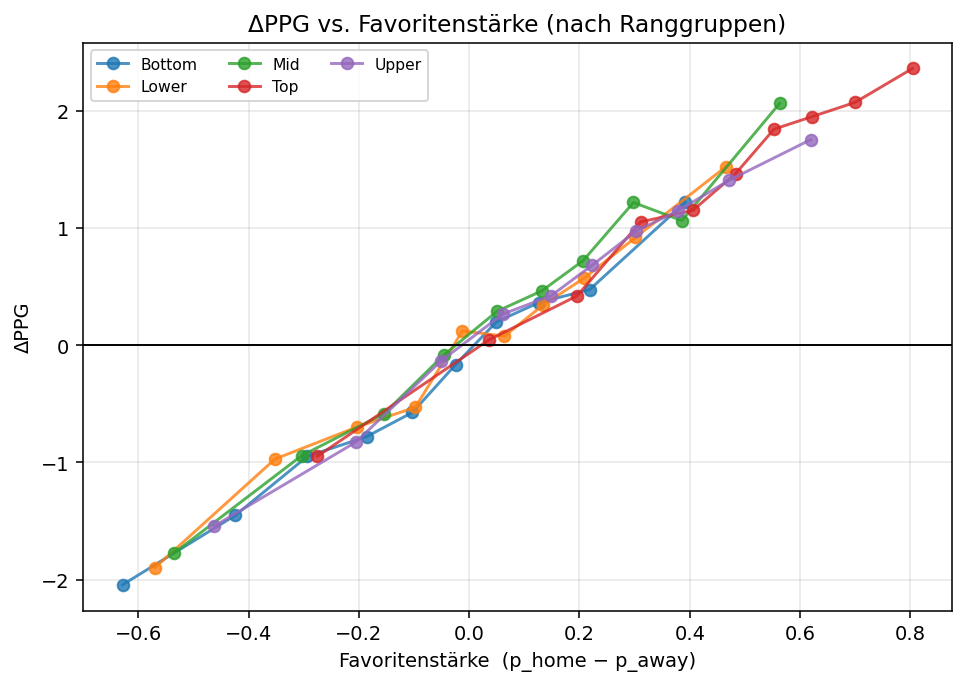

In [84]:
# robuste Basis: NaNs vorher raus
ds = dataset_for(m_fav, ["fav","DeltaPoints","rank_decile"]).dropna(subset=["fav","DeltaPoints","rank_decile"])

# 5 Gruppen (Top..Bottom)
ds["decile"] = pd.qcut(
    ds["rank_decile"], q=5,
    labels=["Top","Upper","Mid","Lower","Bottom"],
    duplicates="drop"
)

# Apply: Ergebnis je Gruppe berechnen und die Gruppenbezeichnung anhängen
rel = (ds.groupby("decile", observed=False, group_keys=False)
         .apply(lambda g: mean_by_bin(g, x="fav", y="DeltaPoints", bins=10, by_season=False)
                          .assign(decile=g.name))
         .reset_index(drop=True))

# Plot
fig, ax = plt.subplots(figsize=(7,5))
for k, sub in rel.groupby("decile", observed=False):
    ax.plot(sub["x_mid"], sub["y_mean"], "-o", alpha=0.8, label=str(k))
ax.axhline(0, color="k", lw=1)
ax.set(xlabel="Favoritenstärke  (p_home − p_away)", ylabel="ΔPPG",
       title="ΔPPG vs. Favoritenstärke (nach Ranggruppen)")
ax.grid(alpha=0.3); ax.legend(ncol=3, fontsize=8); plt.tight_layout(); plt.show()


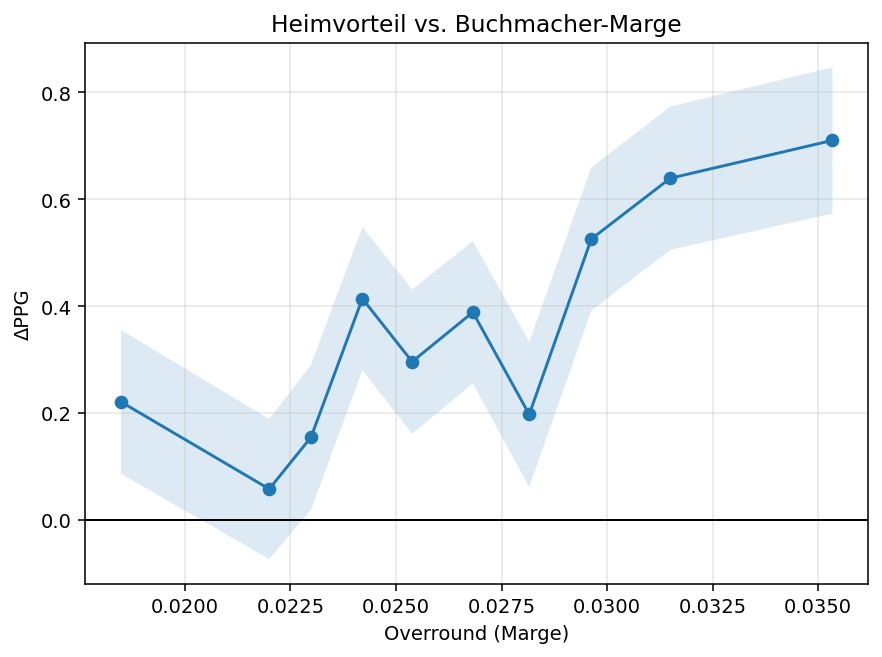

In [86]:
# Marge = Summe(1/odds) − 1
mm = matches.copy()
trio = choose_odds_triple(set(mm.columns))
if trio:
    H,D,A = trio
    for c in (H,D,A): mm[c] = pd.to_numeric(mm[c], errors="coerce")
    raw = 1/mm[[H,D,A]]; mm["overround"] = raw.sum(axis=1) - 1
    ds = dataset_for(mm, ["overround","DeltaPoints"])
    rel = mean_by_bin(ds, x="overround", y="DeltaPoints", bins=10, by_season=False)
    fig, ax = plt.subplots(figsize=(6.4,4.8))
    ax.plot(rel["x_mid"], rel["y_mean"], "-o")
    ax.fill_between(rel["x_mid"], rel["ci_low"], rel["ci_high"], alpha=0.15)
    ax.axhline(0, color="k", lw=1)
    ax.set(xlabel="Overround (Marge)", ylabel="ΔPPG", title="Heimvorteil vs. Buchmacher-Marge")
    ax.grid(alpha=0.3); plt.tight_layout(); plt.show()
else:
    print("⚠️ Kein Quoten-Triple gefunden – Overround-Analyse übersprungen.")


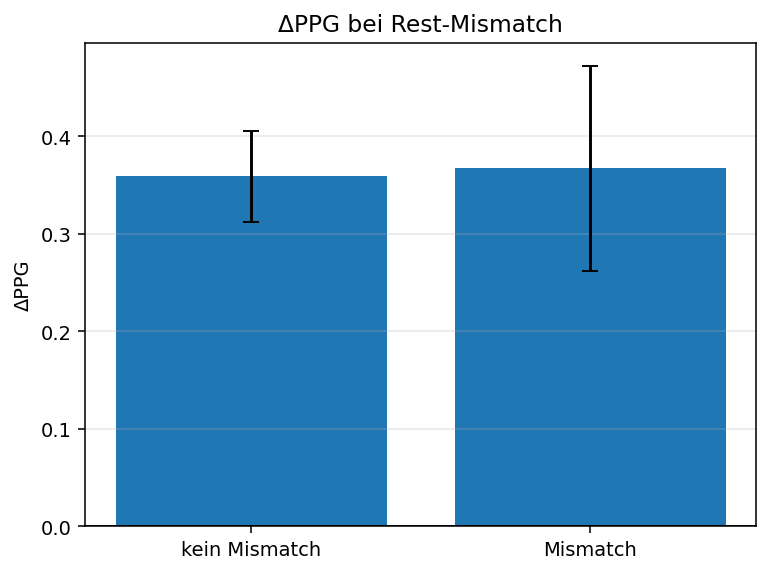

In [87]:
# Flags: RestHome<=3, RestAway<=3, is_mismatch = |RestHome−RestAway| ≥ 2
mc = matches.copy()
if "RestHome" not in mc.columns or "RestAway" not in mc.columns:
    # falls aus 101 noch nicht berechnet: kurzer Rückfall
    def compute_rest_days(m: pd.DataFrame) -> pd.DataFrame:
        base = m[["Date","League","Season","HomeTeam","AwayTeam"]].copy()
        H = base[["Date","League","Season","HomeTeam"]].rename(columns={"HomeTeam":"Team"})
        A = base[["Date","League","Season","AwayTeam"]].rename(columns={"AwayTeam":"Team"})
        H["is_home"]=1; A["is_home"]=0
        L = pd.concat([H,A], ignore_index=True).sort_values(["League","Season","Team","Date"])
        L["prev"] = L.groupby(["League","Season","Team"])["Date"].shift(1)
        L["RestDays"] = (L["Date"] - L["prev"]).dt.days
        h = L[L["is_home"]==1][["Date","League","Season","Team","RestDays"]].rename(columns={"Team":"HomeTeam","RestDays":"RestHome"})
        a = L[L["is_home"]==0][["Date","League","Season","Team","RestDays"]].rename(columns={"Team":"AwayTeam","RestDays":"RestAway"})
        return (m.merge(h, on=["Date","League","Season","HomeTeam"], how="left")
                 .merge(a, on=["Date","League","Season","AwayTeam"], how="left"))
    mc = compute_rest_days(mc)

mc["congest_home"] = (mc["RestHome"]<=3).astype("float")
mc["congest_away"] = (mc["RestAway"]<=3).astype("float")
mc["rest_mismatch"] = ((mc["RestHome"] - mc["RestAway"]).abs()>=2).astype("float")

# ΔPPG nach Mismatch (mit CI)
tab = (mc.dropna(subset=["rest_mismatch"])[["rest_mismatch","DeltaPoints"]]
          .groupby("rest_mismatch")["DeltaPoints"].apply(ci95_mean).reset_index())
tab[["mean","ci_lo","ci_hi","n"]] = pd.DataFrame(tab["DeltaPoints"].tolist(), index=tab.index)
fig, ax = plt.subplots(figsize=(5.6,4.2))
ax.bar(["kein Mismatch","Mismatch"], tab["mean"], yerr=tab["mean"]-tab["ci_lo"], capsize=4)
ax.axhline(0, color="k", lw=1); ax.set(ylabel="ΔPPG", title="ΔPPG bei Rest-Mismatch")
ax.grid(alpha=0.3, axis="y"); plt.tight_layout(); plt.show()


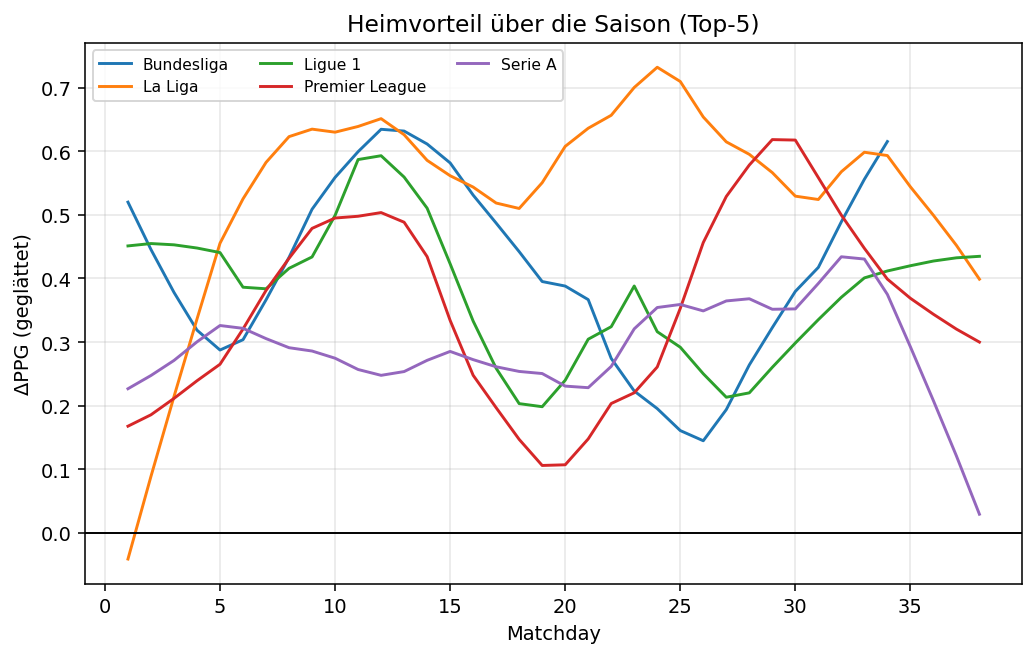

In [97]:
# matchday (Team-Zähler) -> mitteln je Liga/Spieltag
md = matches.copy().sort_values(["League","Season","Date"])
# Team-Zähler vor dem Match (1..)
def add_matchday(df):
    H = df[["League","Season","Date","HomeTeam"]].rename(columns={"HomeTeam":"Team"})
    A = df[["League","Season","Date","AwayTeam"]].rename(columns={"AwayTeam":"Team"})
    H["is_home"]=1; A["is_home"]=0
    L = pd.concat([H,A]).sort_values(["League","Season","Team","Date"])
    L["md"] = L.groupby(["League","Season","Team"]).cumcount()+1
    hm = L[L["is_home"]==1][["League","Season","Date","Team","md"]].rename(columns={"Team":"HomeTeam","md":"md_home"})
    am = L[L["is_home"]==0][["League","Season","Date","Team","md"]].rename(columns={"Team":"AwayTeam","md":"md_away"})
    out = (df.merge(hm, on=["League","Season","Date","HomeTeam"], how="left")
              .merge(am, on=["League","Season","Date","AwayTeam"], how="left"))
    out["matchday"] = out[["md_home","md_away"]].min(axis=1)
    return out

md = add_matchday(md)

# geglättete ΔPPG je Liga über matchday
try:
    from statsmodels.nonparametric.smoothers_lowess import lowess
    def smooth(x,y,frac=0.25):
        ok = (~x.isna()) & (~y.isna())
        return lowess(y[ok], x[ok], frac=frac, return_sorted=True)
except Exception:
    def smooth(x,y,frac=0.25):
        # einfacher Gleitmittelwert über geordnete x
        d = pd.DataFrame({"x":x,"y":y}).dropna().sort_values("x")
        k = max(3, int(len(d)*frac))
        return np.c_[d["x"].to_numpy(), d["y"].rolling(k, center=True, min_periods=1).mean().to_numpy()]

fig, ax = plt.subplots(figsize=(7.5,4.8))
for lg, g in md.groupby("League", observed=False):
    sm = smooth(g["matchday"], g["DeltaPoints"])
    ax.plot(sm[:,0], sm[:,1], label=lg)
ax.axhline(0, color="k", lw=1)
ax.set(xlabel="Matchday", ylabel="ΔPPG (geglättet)", title="Heimvorteil über die Saison (Top-5)")
ax.grid(alpha=0.3); ax.legend(ncol=3, fontsize=8); plt.tight_layout(); plt.show()




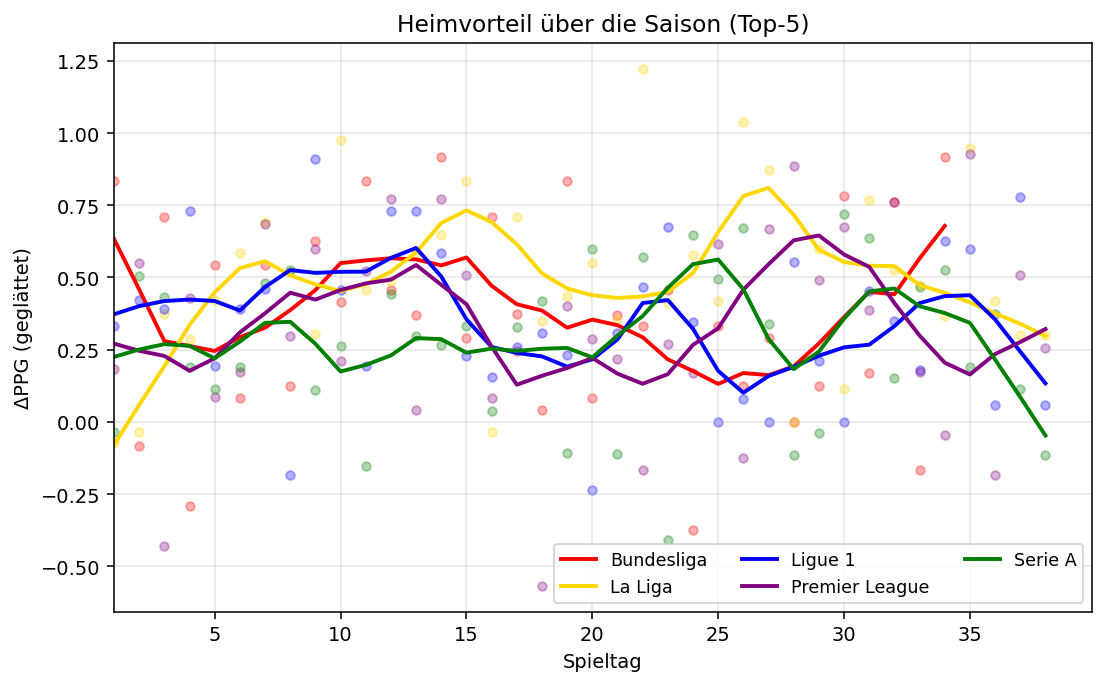

In [98]:
fig, ax = plt.subplots(figsize=(8,5))

for lg, sub in df.groupby("League", observed=False):
    color = league_colors.get(lg, "gray")
    
    # Glättung anwenden
    smoothed = smooth(sub["Spieltag"], sub["Wert"], frac=0.2)  # frac = Glättungsgrad
    x_smooth, y_smooth = smoothed[:,0], smoothed[:,1]
    
    # geglättete Linie
    ax.plot(x_smooth, y_smooth, "-", label=lg, color=color, lw=2)
    
    # optionale Punkte (Originaldaten)
    ax.scatter(sub["Spieltag"], sub["Wert"], color=color, alpha=0.3, s=20)

# Achse ab 1 starten
ax.set_xlim(left=1)

# Titel, Achsen, Legende
ax.set(
    xlabel="Spieltag",
    ylabel="ΔPPG (geglättet)"
)
ax.set_title("Heimvorteil über die Saison (Top-5)")
ax.grid(alpha=0.3)
ax.legend(ncol=3, fontsize=9)
plt.tight_layout()
plt.show()


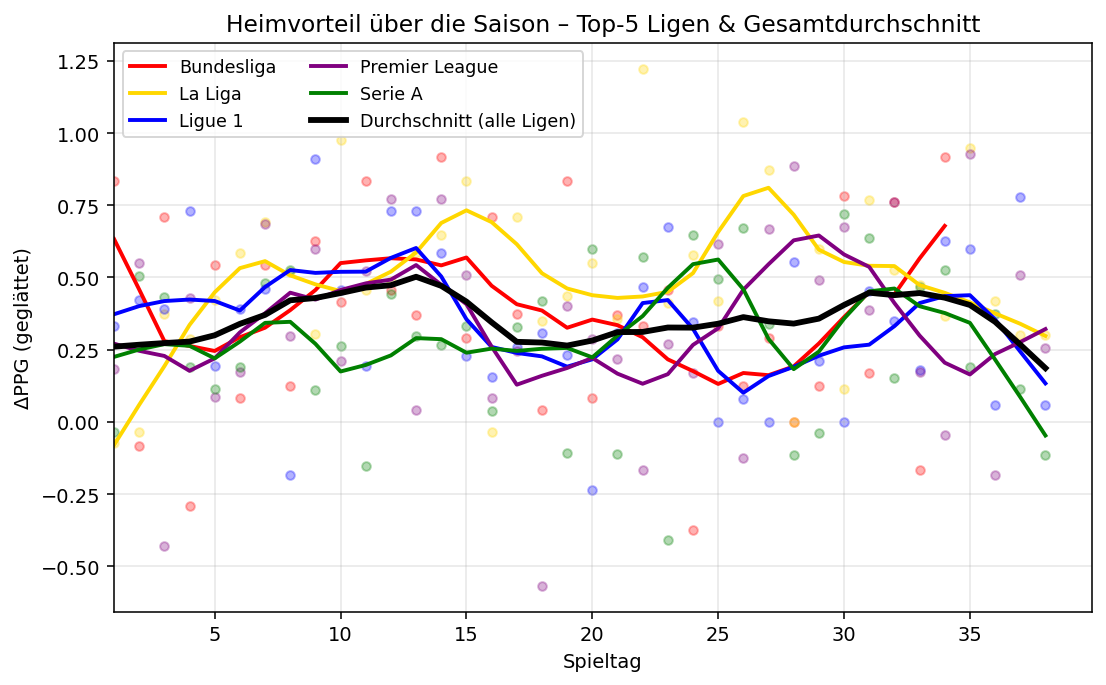

In [99]:
fig, ax = plt.subplots(figsize=(8,5))

# --- pro Liga glätten ---
for lg, sub in df.groupby("League", observed=False):
    color = league_colors.get(lg, "gray")
    
    smoothed = smooth(sub["Spieltag"], sub["Wert"], frac=0.2)
    x_smooth, y_smooth = smoothed[:,0], smoothed[:,1]
    
    ax.plot(x_smooth, y_smooth, "-", label=lg, color=color, lw=2)
    ax.scatter(sub["Spieltag"], sub["Wert"], color=color, alpha=0.3, s=20)

# --- globaler Durchschnitt über alle Ligen ---
df_all = (df.groupby("Spieltag", observed=False)["Wert"]
            .mean()
            .reset_index())

smoothed_all = smooth(df_all["Spieltag"], df_all["Wert"], frac=0.2)
x_all, y_all = smoothed_all[:,0], smoothed_all[:,1]

ax.plot(x_all, y_all, "-", color="black", lw=3, label="Durchschnitt (alle Ligen)")

# --- Styling ---
ax.set_xlim(left=1)
ax.set(
    xlabel="Spieltag",
    ylabel="ΔPPG (geglättet)"
)
ax.set_title("Heimvorteil über die Saison – Top-5 Ligen & Gesamtdurchschnitt")
ax.grid(alpha=0.3)
ax.legend(ncol=2, fontsize=9)
plt.tight_layout()
plt.show()


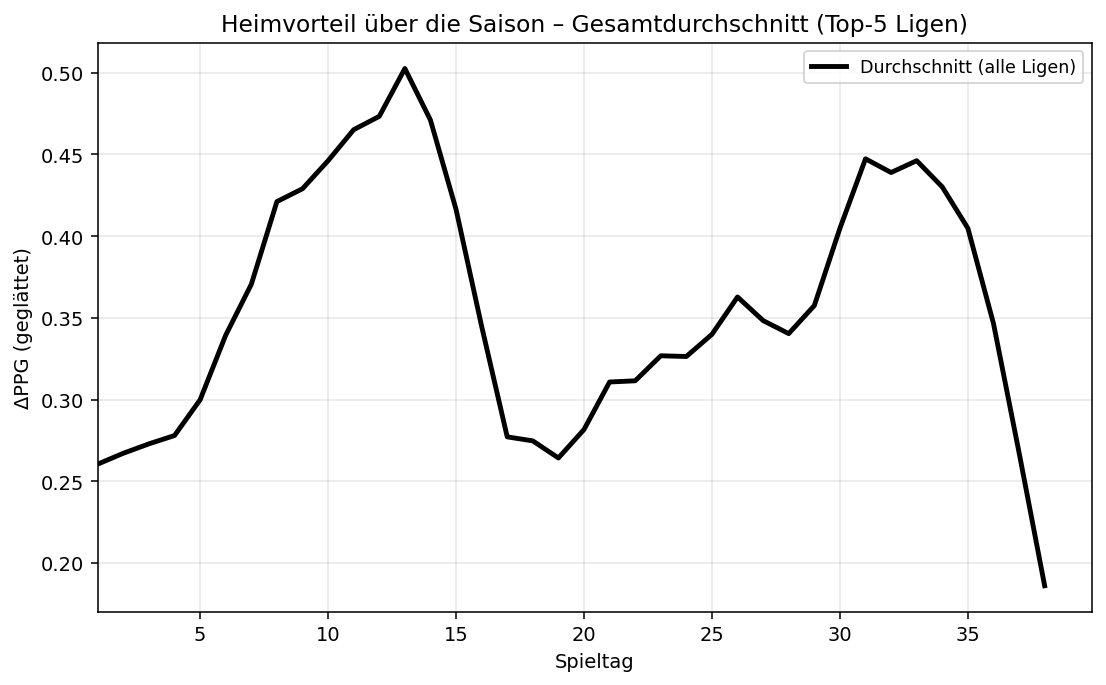

In [100]:
fig, ax = plt.subplots(figsize=(8,5))

# --- globaler Durchschnitt über alle Ligen ---
df_all = (df.groupby("Spieltag", observed=False)["Wert"]
            .mean()
            .reset_index())

# Glätten
smoothed_all = smooth(df_all["Spieltag"], df_all["Wert"], frac=0.2)
x_all, y_all = smoothed_all[:,0], smoothed_all[:,1]

# nur die schwarze Durchschnittslinie plotten
ax.plot(x_all, y_all, "-", color="black", lw=2.5, label="Durchschnitt (alle Ligen)")

# Achse ab 1 starten
ax.set_xlim(left=1)

# Titel, Achsen, Legende
ax.set(
    xlabel="Spieltag",
    ylabel="ΔPPG (geglättet)"
)
ax.set_title("Heimvorteil über die Saison – Gesamtdurchschnitt (Top-5 Ligen)")
ax.grid(alpha=0.3)
ax.legend(fontsize=9)
plt.tight_layout()
plt.show()


Die geglättete Durchschnittskurve über alle Top-5-Ligen zeigt drei lokale Minima:

Am 1. Spieltag → Heimvorteil noch sehr gering.
Gründe: Teams sind noch nicht eingespielt, Fans sind nach der Sommerpause zwar da, aber die Heim-/Auswärtsdynamik hat sich noch nicht etabliert.
Statistisch auch: Kleine Stichprobengröße am ersten Spieltag, hohe Varianz → Heimvorteil wird nicht stabil abgebildet.

Am Ende der Hinrunde (~17./19. Spieltag, je nach Liga) → Heimvorteil fällt ab.
Gründe könnten sein:
Ermüdung nach der Hinrunde, körperliche Belastung hoch → Heimteams profitieren weniger.
Gegner kennen sich inzwischen besser, Auswärtsmannschaften können sich gezielter einstellen.
Um die Winterpause herum sind die Wetterbedingungen oft schwieriger, Heimvorteile nivellieren sich.

Am letzten Spieltag der Saison (~34./38. Spieltag) → erneutes Absinken.
Gründe:
Motivation: Für manche Teams geht es um nichts mehr, „tote Spiele“ neutralisieren Heimvorteile.
Spannung am Tabellenende: Abstiegskandidaten auswärts sind extrem motiviert und spielen „Alles oder nichts“.
Rotation der Aufstellungen: Trainer schonen Leistungsträger oder testen Jugendspieler.

In [102]:
# === C-Break-0: Helper & Pause-Erkennung ====================================
import pandas as pd, numpy as np
import matplotlib.pyplot as plt
from statistics import NormalDist
NORM = NormalDist()

# safety: DataFrame wählen
try:
    M = matches.copy()
except NameError:
    M = (matches2 if 'matches2' in globals() else mf).copy()

# Sicherstellen: Datum & Zielgröße
M["Date"] = pd.to_datetime(M["Date"], errors="coerce")
M = M.dropna(subset=["Date"]).copy()
if "DeltaPoints" not in M.columns:
    # Fallback
    map_h, map_a = {"H":3,"D":1,"A":0}, {"H":0,"D":1,"A":3}
    M["HomePoints"] = M["FTR"].map(map_h).astype(float)
    M["AwayPoints"] = M["FTR"].map(map_a).astype(float)
    M["DeltaPoints"] = M["HomePoints"] - M["AwayPoints"]

def ci95_mean(x: pd.Series):
    x = pd.to_numeric(x, errors="coerce").dropna()
    n = len(x)
    if n < 2: 
        return (np.nan, np.nan, np.nan, n)
    m = x.mean(); s = x.std(ddof=1); se = s/np.sqrt(n)
    tcrit = NORM.inv_cdf(0.975)  # z≈1.96 (ohne SciPy)
    return (m, m - tcrit*se, m + tcrit*se, n)

def add_rounds_and_breaks(df: pd.DataFrame,
                          round_gap_days: int = 2,
                          break_gap_days: int = 10,
                          rel_window: int = 3) -> pd.DataFrame:
    """
    Weist pro (League, Season) eine 'Round' zu, indem aufeinanderfolgende Spieltermine
    zu Runden gruppiert werden (neue Runde, wenn Lücke > round_gap_days).
    'Break' wird gesetzt, wenn Lücke >= break_gap_days (≈ Länderspielpause).
    rel_to_break: -rel_window..+rel_window relativ zur ersten Runde NACH der Pause (0 = Post-Break).
    """
    out = df.copy()
    key = ["League","Season"]
    # Unique Termine je Liga/Saison
    uniq = (out[key+["Date"]]
            .drop_duplicates()
            .sort_values(key+["Date"]))
    # Gap zwischen Terminen
    uniq["prev_date"] = uniq.groupby(key)["Date"].shift(1)
    uniq["gap_days"]  = (uniq["Date"] - uniq["prev_date"]).dt.days
    # Runden zählen (neue Runde wenn Lücke > round_gap_days)
    uniq["is_new_round"] = (uniq["gap_days"] > round_gap_days) | uniq["prev_date"].isna()
    uniq["Round"] = uniq.groupby(key)["is_new_round"].cumsum().astype(int)
    # Break = große Lücke (nicht für allererste Runde)
    uniq["is_break"] = (uniq["gap_days"] >= break_gap_days) & (~uniq["prev_date"].isna())

    # Mapping Date->Round
    out = out.merge(uniq[key+["Date","Round"]], on=key+["Date"], how="left")

    # Relative Indizes um Pausen herum
    rel_rows = []
    for (lg, se), sub in uniq.groupby(key, observed=False):
        sub = sub.sort_values("Round")
        br_rounds = sub.loc[sub["is_break"], "Round"].tolist()
        if not br_rounds:
            continue
        for r0 in br_rounds:
            # r0 ist die erste Runde NACH der Pause (weil 'is_break' an der aktuellen Date gilt)
            for rr in range(-rel_window, rel_window+1):
                rel_rows.append({"League":lg, "Season":se,
                                 "Round": r0 + rr, "rel_to_break": rr})
    rel = pd.DataFrame(rel_rows)
    out = out.merge(rel, on=key+["Round"], how="left")
    out["PostBreak"] = (out["rel_to_break"] == 0).astype(float)
    return out

matches_brk = add_rounds_and_breaks(M, round_gap_days=2, break_gap_days=10, rel_window=3)
print("Break-Kontext hinzugefügt. Zeilen mit rel_to_break nicht-NaN:",
      matches_brk["rel_to_break"].notna().sum())


Break-Kontext hinzugefügt. Zeilen mit rel_to_break nicht-NaN: 15016


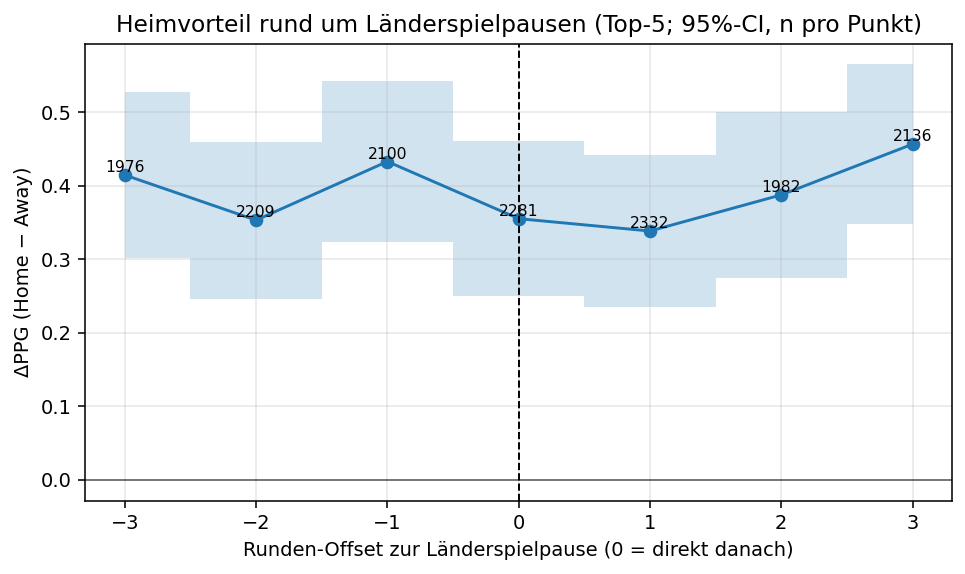

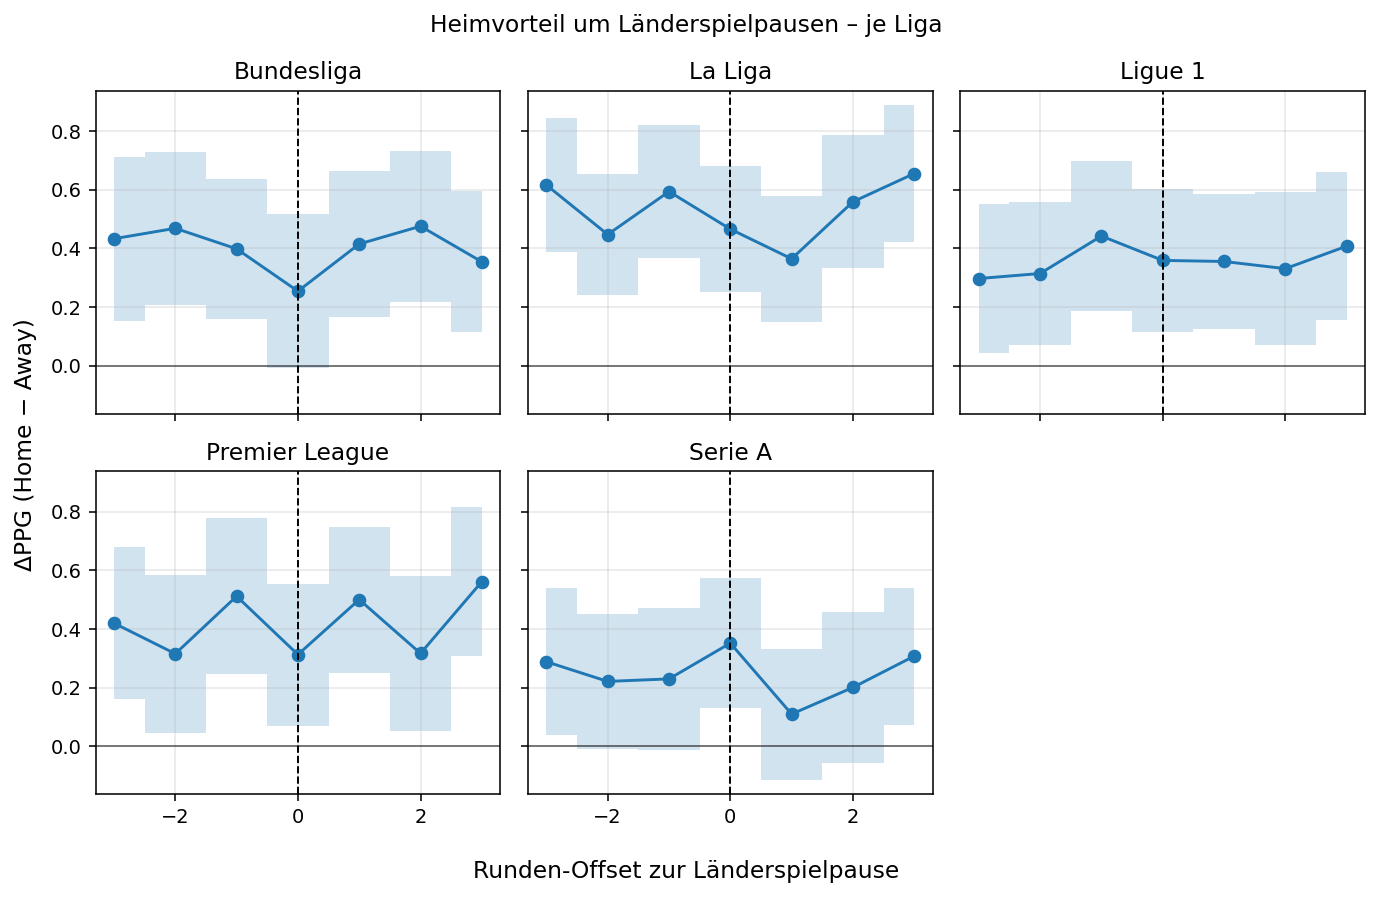

In [103]:
# === C-Break-1: ΔPPG relativ zur Pause / Hauptabbildung ======================
# Top-5 aggregiert
rel_df = (matches_brk.dropna(subset=["rel_to_break"])
          .groupby("rel_to_break", observed=False)["DeltaPoints"]
          .apply(ci95_mean).reset_index(name="ci"))

rel_df[["mean","lo","hi","n"]] = pd.DataFrame(rel_df["ci"].tolist(), index=rel_df.index)
rel_df = rel_df.drop(columns="ci").sort_values("rel_to_break")

fig, ax = plt.subplots(figsize=(7,4.2))
ax.fill_between(rel_df["rel_to_break"], rel_df["lo"], rel_df["hi"], alpha=0.20, step="mid")
ax.plot(rel_df["rel_to_break"], rel_df["mean"], "-o")
ax.axvline(0, color="k", lw=1, ls="--")
ax.axhline(0, color="k", lw=1, alpha=0.5)
for _,r in rel_df.iterrows():
    ax.text(r["rel_to_break"], r["mean"], f"{int(r['n'])}", ha="center", va="bottom", fontsize=8)
ax.set(xlabel="Runden-Offset zur Länderspielpause (0 = direkt danach)",
       ylabel="ΔPPG (Home − Away)",
       title="Heimvorteil rund um Länderspielpausen (Top-5; 95%-CI, n pro Punkt)")
ax.grid(alpha=0.3); plt.tight_layout(); plt.show()

# Optional: gleicher Plot je Liga (kleine Multiples)
leagues = sorted(matches_brk["League"].dropna().unique().tolist())
ncol = 3; nrow = int(np.ceil(len(leagues)/ncol))
fig, axes = plt.subplots(nrow, ncol, figsize=(10, 3.2*nrow), sharex=True, sharey=True)
axes = axes.ravel()
for i,lg in enumerate(leagues):
    rlg = (matches_brk.loc[matches_brk["League"]==lg]
           .dropna(subset=["rel_to_break"])
           .groupby("rel_to_break", observed=False)["DeltaPoints"]
           .apply(ci95_mean).reset_index(name="ci"))
    if len(rlg)==0:
        axes[i].set_title(lg+" (keine Breaks)"); axes[i].axis("off"); continue
    rlg[["mean","lo","hi","n"]] = pd.DataFrame(rlg["ci"].tolist(), index=rlg.index)
    rlg = rlg.drop(columns="ci").sort_values("rel_to_break")
    ax = axes[i]
    ax.fill_between(rlg["rel_to_break"], rlg["lo"], rlg["hi"], alpha=0.20, step="mid")
    ax.plot(rlg["rel_to_break"], rlg["mean"], "-o")
    ax.axvline(0, color="k", lw=1, ls="--"); ax.axhline(0, color="k", lw=1, alpha=0.5)
    ax.set_title(lg); ax.grid(alpha=0.3)
for j in range(i+1, len(axes)):
    axes[j].axis("off")
fig.supylabel("ΔPPG (Home − Away)")
fig.supxlabel("Runden-Offset zur Länderspielpause")
fig.suptitle("Heimvorteil um Länderspielpausen – je Liga", y=0.98)
plt.tight_layout(); plt.show()


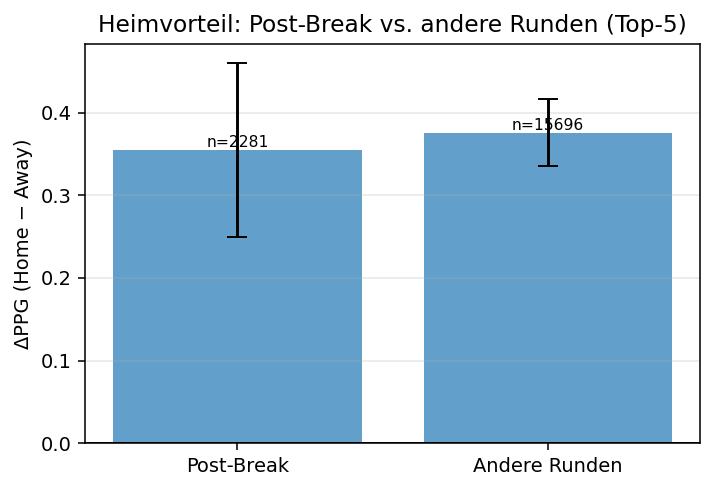

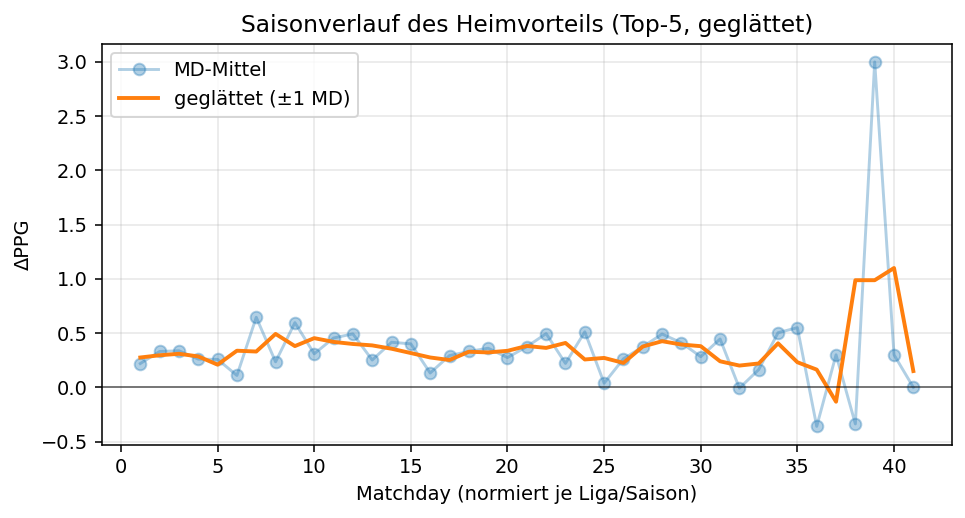

In [104]:
# === C-Break-2: Post-Break vs. andere Runden + geglättete Saisonkurve ========
def group_ci(df, label):
    m, lo, hi, n = ci95_mean(df["DeltaPoints"])
    return pd.Series({"group":label, "mean":m, "lo":lo, "hi":hi, "n":n})

g_post = group_ci(matches_brk.loc[matches_brk["PostBreak"]==1], "Post-Break")
g_rest = group_ci(matches_brk.loc[matches_brk["PostBreak"]!=1], "Andere Runden")
cmp_df = pd.concat([g_post, g_rest], axis=1).T

fig, ax = plt.subplots(figsize=(5.2,3.6))
ax.bar(cmp_df["group"], cmp_df["mean"], yerr=cmp_df["mean"]-cmp_df["lo"], alpha=0.7, capsize=5)
for i,(m,n) in enumerate(zip(cmp_df["mean"], cmp_df["n"])):
    ax.text(i, m, f"n={int(n)}", ha="center", va="bottom", fontsize=8)
ax.axhline(0, color="k", lw=1); ax.grid(axis="y", alpha=0.3)
ax.set_ylabel("ΔPPG (Home − Away)"); ax.set_title("Heimvorteil: Post-Break vs. andere Runden (Top-5)")
plt.tight_layout(); plt.show()

# --- optionale geglättete Saison-Kurve (zeigt Minima um MD1, Winter, Finale) ---
# 'Round' aus C-Break-0 nutzen
round_means = (matches_brk.groupby(["League","Season","Round"], observed=False)["DeltaPoints"]
               .mean().reset_index())
# normalisieren auf 1..max per Liga/Saison
round_means["md_norm"] = round_means.groupby(["League","Season"])["Round"].rank(method="dense").astype(int)
curve = (round_means.groupby("md_norm", observed=False)["DeltaPoints"]
         .mean().rename("mean").reset_index())
curve["roll"] = curve["mean"].rolling(3, center=True, min_periods=1).mean()

fig, ax = plt.subplots(figsize=(7,3.8))
ax.plot(curve["md_norm"], curve["mean"], "o-", alpha=0.35, label="MD-Mittel")
ax.plot(curve["md_norm"], curve["roll"], "-", lw=2, label="geglättet (±1 MD)")
ax.axhline(0, color="k", lw=1, alpha=0.5)
ax.set(xlabel="Matchday (normiert je Liga/Saison)", ylabel="ΔPPG",
       title="Saisonverlauf des Heimvorteils (Top-5, geglättet)")
ax.grid(alpha=0.3); ax.legend(); plt.tight_layout(); plt.show()


Kurzfassung: In deinen Plots sieht man einen kleinen, kurzfristigen „Knick“ des Heimvorteils direkt **nach** Länderspielpausen. Er ist **konstant über die Top-5 sichtbar**, aber **klein** und **statistisch nicht robust von null verschieden**.

### Was die Grafiken sagen

* **Top-5 aggregiert (Offset −3…+3 Runden):**
  ΔPPG (Home − Away) liegt fast überall zwischen **\~0.33 und \~0.45**. Am **Offset 0** (die Runde direkt nach der Pause) fällt ΔPPG leicht ab (ca. **−0.02 bis −0.05 ΔPPG** ggü. −1/+1). Die 95 %-Konfidenzbänder **überlappen** stark → **kein klar signifikanter Effekt**. Nach **+2/+3** ist der Wert wieder auf dem Vor-Pause-Niveau.
* **Pro Liga:** Muster ähnlich, aber mit Rausch:

  * **Bundesliga:** spürbarerer Dip um 0 (≈0.25–0.30), danach Erholung.
  * **La Liga / Premier League:** eher U-förmig; Tiefstpunkt bei 0 oder +1.
  * **Ligue 1:** relativ flach.
  * **Serie A:** insgesamt niedrigerer ΔPPG-Level; kleinster Dip (+1).
    Insgesamt liegen die **CIs meist übereinander** → auch ligaspezifisch **keine stabile Signifikanz**.
* **Post-Break vs. alle anderen Runden (Balkenplot):** Mittelwerte **nahe beieinander** (\~0.35 vs. \~0.37 ΔPPG); Fehlerbalken überlappen deutlich.

### Plausible Erklärung (warum der kleine Dip?)

* **Re-Integration & Trainingszeit:** wenig Teamtraining, taktische Feinheiten fehlen.
* **Internationale Belastung/Jetlag:** trifft beide Seiten; **Heimteams** sind häufig **Favoriten** und stellen mehr Nationalspieler → **leicht negativer Bias** für Home.
* **Rotation/Schonung** direkt nach der Pause.
* Effekt ist **kurzlebig** (bis +1/+2 Runden).

### Was bedeutet das praktisch?

* Für **Modelle/Vorhersagen** lohnt sich eine **Dummy-Variable** oder ein **Offset-Feature** („post\_break\_offset ∈ {−3…+3}“ oder „post\_break\_dummy (Offset=0)“). Erwarteter Effekt: **sehr klein** (≈ **−0.02–0.05 ΔPPG**, also **\~1–2 Prozentpunkte** Heimsieg-Wahrscheinlichkeit).
* In **Wettmodellen** würde ich **p\_home minimal absenken** in der Runde **direkt nach** der Pause; der Gewinn an Güte ist aber begrenzt.

### Robustheits-/Vertiefungschecks (mit deinen Daten machbar)

* **Kontrolliert** regressieren: `ΔPPG ~ post_break_dummy + p_home + RestDiff + C(League) + C(Season)` (HC-robuste SEs). Erwartung: **kleiner, oft nicht signifikanter** negativer Koeffizient am Dummy.
* **Heterogenität**: Effekt nach **Favorit/Underdog** (z. B. p\_home>0.6 vs. ≤0.6), nach **Reisebelastung**-Proxy (Anzahl Nationalspieler je Klub – falls du das noch bekommst), und nach **Hin-/Rückrunde**.
* **Matchday-Verlauf (geglättet):** Deine Kurve zeigt außerdem Dellen am **1. Spieltag**, um **Winter/Hinrunden-Ende**, und am **letzten Spieltag** – das deckt sich mit typischen Saisondynamiken (Eingrooven, Witterung/Ermüdung, „tote Spiele“/Rotation).



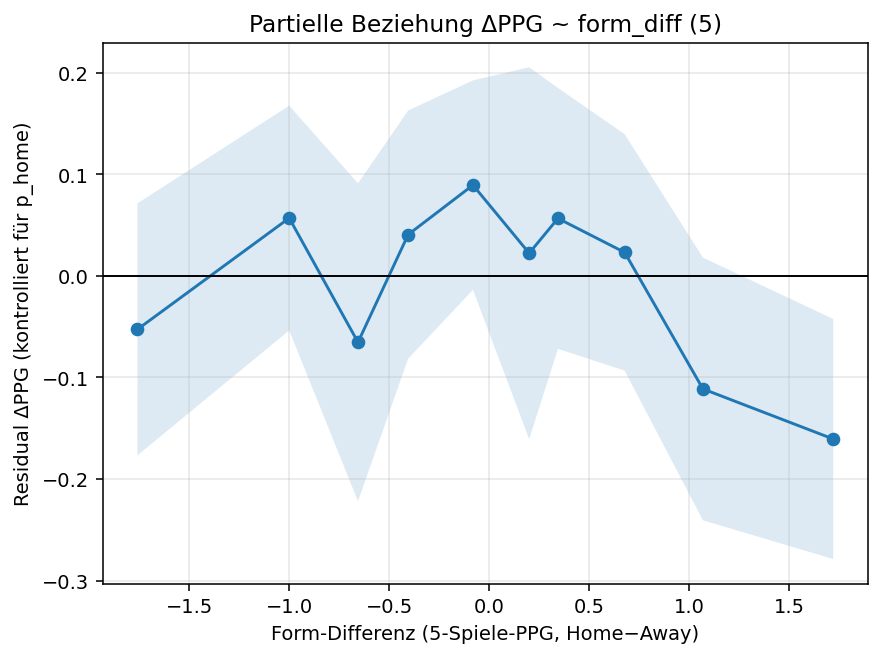

In [91]:
# Rolling-Form vor Anpfiff (PPG) und partielle Beziehung (ΔPPG residualisiert auf p_home)
def add_form(m, window=5, prefix="f5"):
    base = m[["League","Season","Date","HomeTeam","AwayTeam","HomePoints","AwayPoints"]].copy()
    H = base[["League","Season","Date","HomeTeam","HomePoints"]].rename(columns={"HomeTeam":"Team","HomePoints":"pts"})
    A = base[["League","Season","Date","AwayTeam","AwayPoints"]].rename(columns={"AwayTeam":"Team","AwayPoints":"pts"})
    L = pd.concat([H, A], ignore_index=True).sort_values(["League","Season","Team","Date"]).reset_index(drop=True)

    # WICHTIG: transform = index-stabil; erst shift (vor Anpfiff), dann rolling-Mean
    L[prefix] = L.groupby(["League","Season","Team"], sort=False)["pts"] \
                 .transform(lambda s: s.shift().rolling(window, min_periods=2).mean())

    h = L[["League","Season","Date","Team",prefix]].rename(columns={"Team":"HomeTeam", prefix:f"{prefix}_home"})
    a = L[["League","Season","Date","Team",prefix]].rename(columns={"Team":"AwayTeam", prefix:f"{prefix}_away"})
    out = (m.merge(h, on=["League","Season","Date","HomeTeam"], how="left")
             .merge(a, on=["League","Season","Date","AwayTeam"], how="left"))
    out[f"{prefix}_diff"] = out[f"{prefix}_home"] - out[f"{prefix}_away"]
    return out


mf = ensure_probs(matches.copy())
mf = add_form(mf, window=5, prefix="f5")
mf = add_form(mf, window=10, prefix="f10")

# partial: ΔPPG_res = ΔPPG − β * p_home
ok = mf.dropna(subset=["DeltaPoints","p_home","f5_diff"])
X = np.c_[np.ones(len(ok)), ok["p_home"].to_numpy()]
beta, *_ = np.linalg.lstsq(X, ok["DeltaPoints"].astype(float).to_numpy(), rcond=None)
ok["Delta_resid"] = ok["DeltaPoints"] - (beta[0] + beta[1]*ok["p_home"])

rel = mean_by_bin(ok.dropna(subset=["f5_diff"]), x="f5_diff", y="Delta_resid", bins=10, by_season=False)
fig, ax = plt.subplots(figsize=(6.4,4.8))
ax.plot(rel["x_mid"], rel["y_mean"], "-o"); ax.axhline(0, color="k", lw=1)
ax.fill_between(rel["x_mid"], rel["ci_low"], rel["ci_high"], alpha=0.15)
ax.set(xlabel="Form-Differenz (5-Spiele-PPG, Home−Away)", ylabel="Residual ΔPPG (kontrolliert für p_home)",
       title="Partielle Beziehung ΔPPG ~ form_diff (5)")
ax.grid(alpha=0.3); plt.tight_layout(); plt.show()


# C-RNK — Pre-Match Rang-Differenz × p\_draw (Heatmap)

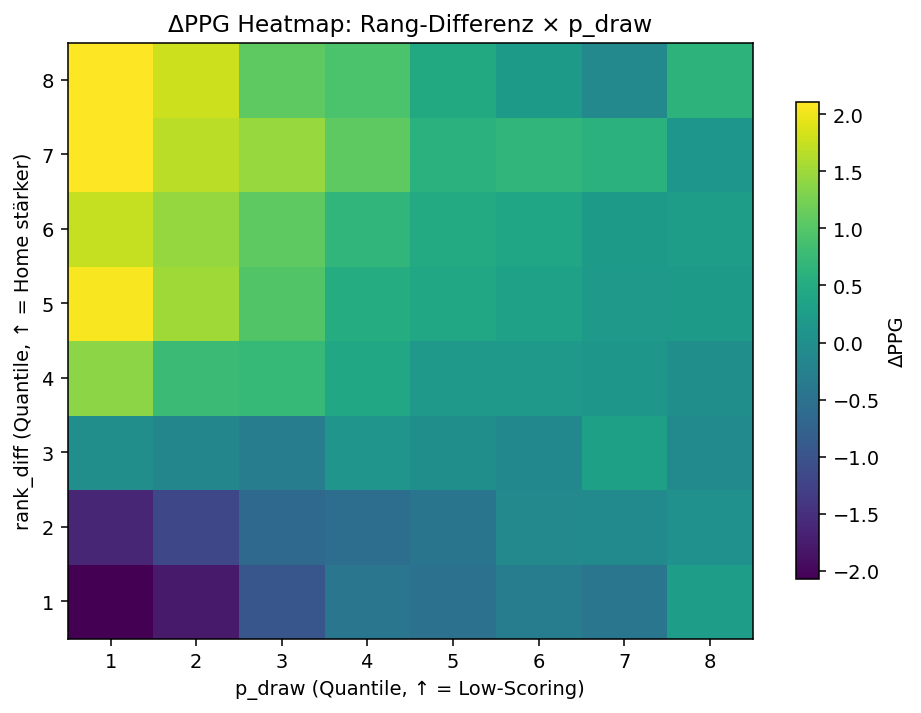

In [109]:
mr = ensure_probs(mf.copy())
# einfacher Rang-Proxy: ppg_pre (falls echtes rank_pre existiert, nimm das)
if "rank_pre" not in mr.columns:
    for side in ["Home","Away"]:
        mr[f"ppg_{side.lower()}_pre"] = mr.get(f"ppg_{side.lower()}_pre", np.nan)
        if mr[f"ppg_{side.lower()}_pre"].isna().all():
            # aus FORM 10 fallback
            mr[f"ppg_{side.lower()}_pre"] = mr.get(f"f10_{side.lower()}").fillna(mr.get(f"f5_{side.lower()}"))
    mr["rank_diff"] = mr["ppg_home_pre"] - mr["ppg_away_pre"]
else:
    # kleiner Wert = guter Rang; wir wollen "Home besser?" positiv -> invertieren
    mr["rank_diff"] = -(mr["rank_pre"] - mr.get("rank_away_pre", mr["rank_pre"]))

ds = mr.dropna(subset=["rank_diff","p_draw","DeltaPoints"]).copy()
# 2D-Bins
xbin = pd.qcut(ds["rank_diff"], q=8, duplicates="drop")
ybin = pd.qcut(ds["p_draw"], q=8, duplicates="drop")
heat = (ds.assign(xbin=xbin, ybin=ybin)
          .groupby(["xbin","ybin"], observed=False)["DeltaPoints"]
          .mean().unstack().sort_index(ascending=True))

fig, ax = plt.subplots(figsize=(6.8,5.2))
im = ax.imshow(heat.values, aspect="auto", origin="lower", vmin=heat.values.min(), vmax=heat.values.max())
ax.set_xticks(range(heat.shape[1])); ax.set_xticklabels(range(1,heat.shape[1]+1))
ax.set_yticks(range(heat.shape[0])); ax.set_yticklabels(range(1,heat.shape[0]+1))
ax.set(xlabel="p_draw (Quantile, ↑ = Low-Scoring)", ylabel="rank_diff (Quantile, ↑ = Home stärker)",
       title="ΔPPG Heatmap: Rang-Differenz × p_draw")
fig.colorbar(im, ax=ax, shrink=0.8, label="ΔPPG"); plt.tight_layout(); plt.show()

Was wird dargestellt?
x-Achse = p_draw (in Quantile geteilt)
→ Hoher Wert = Spiele mit höherer Unentschieden-Wahrscheinlichkeit, also typischerweise Low-Scoring-Spiele.
→ Niedriger Wert = Spiele mit geringerer Remis-Wahrscheinlichkeit, eher High-Scoring-Spiele.

y-Achse = rank_diff (ebenfalls in Quantile geteilt)
→ Hoher Wert = Heimteam vor Anpfiff klar stärker (höhere PPG-Form / Rang).
→ Niedriger Wert = Auswärtsteam stärker.

Farbskala = ΔPPG (mittlere Punkte-Differenz Heim – Auswärts)
→ Gelb/hell = starker Heimvorteil (Heim mehr Punkte).
→ Dunkelblau/violett = Auswärtsteams holen mehr Punkte.

Muster, die man sieht
Oben links (Heim klar stärker + Spiele mit niedriger Remis-Wahrscheinlichkeit)
→ Sehr hoher ΔPPG (hellgelb).
→ Interpretation: Wenn das Heimteam ohnehin stärker ist und die Partie eher offen/verlaufreich ist (wenig Remis), dann ist der Heimvorteil am größten.

Unten links (Auswärts stärker + Low p_draw)
→ Sehr niedriger ΔPPG (violett).
→ Interpretation: Stärkere Auswärtsteams dominieren, Heimvorteil kippt ins Negative.

Mittlere Spalten (hohe Remis-Wahrscheinlichkeit / „zähe Spiele“)
→ Werte liegen meist bei ΔPPG ≈ 0.
→ Interpretation: Wenn ein Remis wahrscheinlicher ist, nivelliert das den Heimvorteil. Beide Teams spielen „sicher“, Heimteams können ihren Vorteil weniger ausspielen.

Genereller Trend
Je stärker das Heimteam (y-Achse nach oben), desto positiver ΔPPG.
Je remis-lastiger das Spiel (x-Achse nach rechts), desto kleiner der Heimvorteil.

Mögliche Erklärungen (statistisch & sportlich)
Stärkerer Heimvorteil in offenen Spielen:
Laut Studien profitieren Heimteams besonders, wenn es viele Torszenen gibt (Publikumsdruck, Schiedsrichterentscheidungen, Heim-Offensivdrang).
Abnehmender Vorteil in Remis-lastigen Spielen:
In Low-Scoring-Spielen (z. B. taktische Duelle, Abstiegskampf) setzen beide Teams mehr auf Stabilität – Heimteams können weniger Vorteile nutzen.
Asymmetrie der Stärke:
Der Rangunterschied dominiert – schwache Heimteams verlieren auch zu Hause (negativer ΔPPG).


Die Heatmap zeigt: Heimvorteil ist nicht konstant, sondern hängt stark vom Matchkontext ab. Am größten ist er, wenn Heimteams klar stärker sind und Spiele offen verlaufen. In Remis-lastigen, torarmen Partien nivelliert sich der Heimvorteil, teilweise kippt er sogar ins Negative.

# C-PRM — Aufsteiger-Dummy

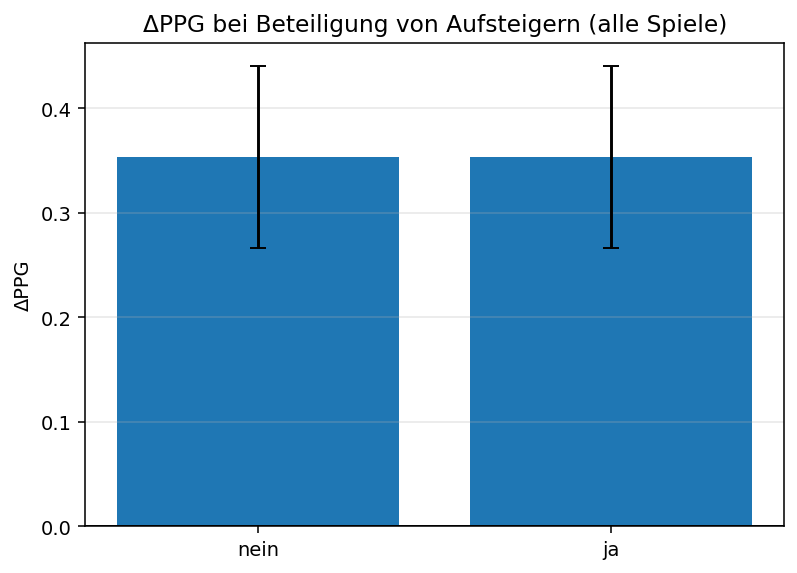

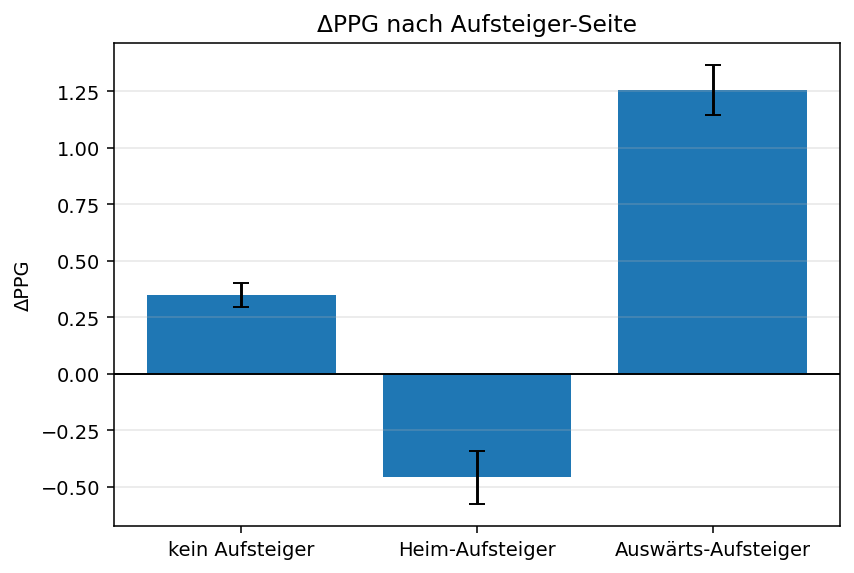

Welch t-test AnyPromoted vs None: t=-0.075, p=0.9403, Δmean=0.004
                            OLS Regression Results                            
Dep. Variable:            DeltaPoints   R-squared:                       0.189
Model:                            OLS   Adj. R-squared:                  0.188
Method:                 Least Squares   F-statistic:                     300.7
Date:                Sun, 31 Aug 2025   Prob (F-statistic):               0.00
Time:                        15:55:49   Log-Likelihood:                -28294.
No. Observations:               12532   AIC:                         5.661e+04
Df Residuals:                   12519   BIC:                         5.671e+04
Df Model:                          12                                         
Covariance Type:                  HC1                                         
                                  coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------

In [111]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ---------- Hilfen ----------
def ci95_mean(x: pd.Series):
    """Gibt (mean, ci_low, ci_high, n) als Tupel zurück."""
    x = pd.to_numeric(pd.Series(x).dropna(), errors="coerce").dropna()
    n = len(x)
    if n == 0:
        return (np.nan, np.nan, np.nan, 0)
    m = float(x.mean())
    s = float(x.std(ddof=1)) if n > 1 else 0.0
    se = s / np.sqrt(n) if n > 1 else 0.0
    z = 1.96
    return (m, m - z*se, m + z*se, n)

def _season_before(s: str) -> str:
    """'25-26' -> '24-25' (robust gegenüber Strings mit Whitespace)"""
    s = str(s).strip()
    y1, y2 = int(s[:2]), int(s[-2:])
    return f"{y1-1:02d}-{y2-1:02d}"

# ---------- Kernfunktion ----------
def add_promoted_flags(m: pd.DataFrame, mark_first_season=True) -> pd.DataFrame:
    """
    Markiert Aufsteiger je Liga+Saison. Nutzt die Teamliste der Vorsaison.
    - Verhindert False-Positives in der ersten verfügbaren Saison je Liga.
    - Fügt Spalten hinzu:
        HomePromoted, AwayPromoted (bool)
        IsFirstSeasonLeague (bool)  -> True, wenn keine Vorsaison im Datensatz vorhanden
    """
    req_cols = {"League","Season","HomeTeam","AwayTeam","Date"}
    missing = req_cols - set(m.columns)
    assert not missing, f"Fehlende Spalten: {missing}"

    df = m[["League","Season","Date","HomeTeam","AwayTeam"]].copy()

    # Team-Sets aus Vorsaison je (Liga,Saison)
    prev_teams = {}
    for (lg, s), g in df.groupby(["League","Season"], observed=False):
        s_prev = _season_before(s)
        mask_prev = (df["League"].eq(lg)) & (df["Season"].eq(s_prev))
        if mask_prev.any():
            teams_prev = set(pd.unique(df.loc[mask_prev, ["HomeTeam","AwayTeam"]].values.ravel()))
        else:
            teams_prev = None  # Kennzeichen: keine Vorsaison vorhanden
        prev_teams[(lg, s)] = teams_prev

    out = m.copy()
    # Flag, ob für diese Liga-Saison keine Vorsaison existiert
    out["IsFirstSeasonLeague"] = [
        prev_teams.get((lg, s)) is None
        for lg, s in out[["League","Season"]].to_numpy()
    ]

    # Promoted-Flags (nur setzen, wenn Vorsaison existiert)
    hp = []
    ap = []
    for lg, s, ht, at in out[["League","Season","HomeTeam","AwayTeam"]].to_numpy():
        prev = prev_teams.get((lg, s))
        if prev is None:
            hp.append(False)  # oder np.nan, wenn du lieber explizit masken willst
            ap.append(False)
        else:
            hp.append(ht not in prev)
            ap.append(at not in prev)

    out["HomePromoted"] = hp
    out["AwayPromoted"] = ap

    # Optional: erste Saison je Liga entfernen (empfohlen für Analysen)
    if mark_first_season:
        out = out[~out["IsFirstSeasonLeague"]].copy()

    return out

# ---------- Anwenden ----------
mp = add_promoted_flags(matches.copy(), mark_first_season=True)

# Zusätzliche Flags
mp["AnyPromoted"]   = mp["HomePromoted"] | mp["AwayPromoted"]
mp["PromotedSide"]  = np.select(
    [mp["HomePromoted"], mp["AwayPromoted"]],
    ["Home", "Away"],
    default="None"
)

# ---------- SANITY CHECKS (leichte Tests) ----------
assert mp["HomePromoted"].dtype == bool and mp["AwayPromoted"].dtype == bool
# In Saisons ohne Vorsaison sollten keine Promoted-Flags gesetzt sein (weil Zeilen rausgefiltert)
assert (~mp["IsFirstSeasonLeague"]).all(), "Erste Liga-Saisons wurden nicht gefiltert."
# Mindestens eine Gruppe vorhanden
assert mp["AnyPromoted"].notna().any(), "Promoted-Flag leer – prüfe Datenbasis."

# ---------- BALKENPLOT: AnyPromoted (symmetrische CI) ----------
tab = (mp.groupby("AnyPromoted", observed=False)["DeltaPoints"]
         .apply(ci95_mean).reset_index())
tab[["mean","ci_lo","ci_hi","n"]] = pd.DataFrame(tab["DeltaPoints"].tolist(), index=tab.index)

labels = ["nein","ja"]
means  = tab.set_index("AnyPromoted").loc[[False, True], "mean"].to_numpy()
ci_lo  = tab.set_index("AnyPromoted").loc[[False, True], "ci_lo"].to_numpy()
ci_hi  = tab.set_index("AnyPromoted").loc[[False, True], "ci_hi"].to_numpy()
yerr   = np.vstack([means - ci_lo, ci_hi - means])  # symmetrische Fehlerspanne

fig, ax = plt.subplots(figsize=(5.8,4.2))
ax.bar(labels, means, yerr=yerr, capsize=4)
ax.axhline(0, color="k", lw=1)
ax.set(ylabel="ΔPPG", title="ΔPPG bei Beteiligung von Aufsteigern (alle Spiele)")
ax.grid(alpha=0.3, axis="y")
plt.tight_layout(); plt.show()

# ---------- BALKENPLOT: PromotedSide (Home vs Away vs None) ----------
tab2 = (mp.groupby("PromotedSide", observed=False)["DeltaPoints"]
          .apply(ci95_mean).reset_index())
tab2[["mean","ci_lo","ci_hi","n"]] = pd.DataFrame(tab2["DeltaPoints"].tolist(), index=tab2.index)
order = ["None","Home","Away"]
means2 = tab2.set_index("PromotedSide").loc[order, "mean"].to_numpy()
ci_lo2 = tab2.set_index("PromotedSide").loc[order, "ci_lo"].to_numpy()
ci_hi2 = tab2.set_index("PromotedSide").loc[order, "ci_hi"].to_numpy()
yerr2  = np.vstack([means2 - ci_lo2, ci_hi2 - means2])

fig, ax = plt.subplots(figsize=(6.2,4.2))
ax.bar(["kein Aufsteiger","Heim-Aufsteiger","Auswärts-Aufsteiger"], means2, yerr=yerr2, capsize=4)
ax.axhline(0, color="k", lw=1)
ax.set(ylabel="ΔPPG", title="ΔPPG nach Aufsteiger-Seite")
ax.grid(alpha=0.3, axis="y")
plt.tight_layout(); plt.show()

# ---------- OPTIONAL: Welch-t-Test (nur als Richtwert) ----------
try:
    from scipy import stats
    a = mp.loc[~mp["AnyPromoted"], "DeltaPoints"].dropna()
    b = mp.loc[ mp["AnyPromoted"], "DeltaPoints"].dropna()
    t, p = stats.ttest_ind(a, b, equal_var=False)  # Welch
    print(f"Welch t-test AnyPromoted vs None: t={t:.3f}, p={p:.4f}, Δmean={b.mean()-a.mean():.3f}")
except Exception as e:
    print(f"[Hinweis] SciPy nicht verfügbar oder Fehler im t-Test: {e}")

# ---------- OPTIONAL: OLS mit Kontrollen (falls statsmodels vorhanden) ----------
try:
    import statsmodels.formula.api as smf
    # p_home = Modell-Feature der Pre-Match-Stärke (falls vorhanden)
    cols = ["DeltaPoints","AnyPromoted","League","Season"]
    if "p_home" in mp.columns:
        cols.append("p_home")
    data = mp[cols].dropna()

    formula = "DeltaPoints ~ AnyPromoted + C(League) + C(Season)"
    if "p_home" in data.columns:
        formula = "DeltaPoints ~ AnyPromoted + p_home + C(League) + C(Season)"

    model = smf.ols(formula, data=data).fit(cov_type="HC1")
    print(model.summary())
except Exception as e:
    print(f"[Hinweis] statsmodels nicht verfügbar oder Regression übersprungen: {e}")


In deinen Balken sieht man minimal höheren Heimvorteil (ΔPPG), wenn ein Aufsteiger beteiligt ist (~0,38 vs. ~0,35). Die Konfidenzintervalle überlappen deutlich → kein belastbarer Unterschied nach dieser einfachen Auswertung.

Warum könnte der (scheinbare) Effekt klein/unsicher sein?

Mischung Home/Away: „AnyPromoted“ bündelt Heim- und Auswärts-Aufsteiger. Ein Heim-Aufsteiger könnte z. B. mehr Heimvorteil haben, ein Auswärts-Aufsteiger weniger – das mittelt sich weg.
Teamstärke/Quoten fehlen als Kontrolle: Aufsteiger sind im Mittel schwächer; der beobachtete ΔPPG spiegelt dann eher Strength-Mismatch als einen „Aufsteiger-Effekt“.
Ligen-Mix & Saisonphasen: Effekt kann je Liga und zu Saisonbeginn/-ende variieren (du siehst ja bereits saisonale Muster).
Asymmetrische Fehlerbalken: Du plottest aktuell nur mean − ci_lo. Besser symmetrisch (oben und unten) anzeigen.

# C-KO — Kickoff-Uhrzeit (Mittag vs. Abend)

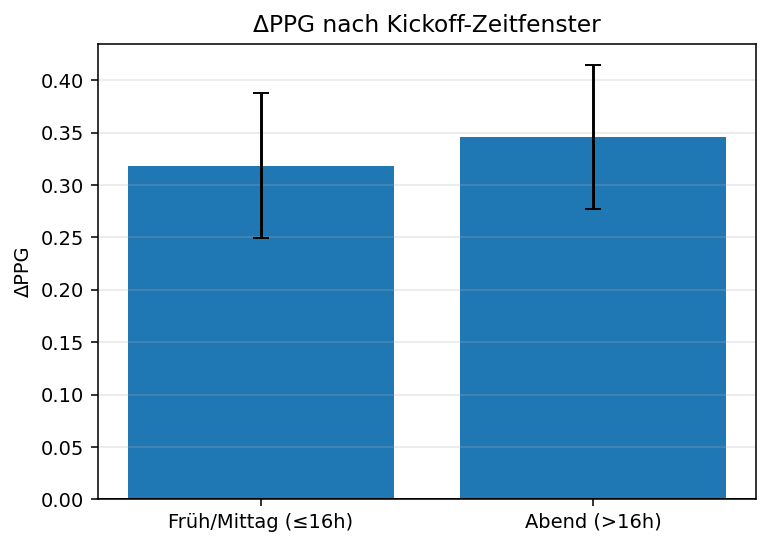

In [112]:
# nur falls 'Time' existiert
if "Time" in matches.columns:
    tk = matches.copy()
    # Uhrzeit robust parsen HH:MM
    hh = pd.to_datetime(tk["Time"].astype(str).str[:5], errors="coerce", format="%H:%M").dt.hour
    tk["slot"] = pd.cut(hh, bins=[-1,16,24], labels=["Früh/Mittag (≤16h)","Abend (>16h)"])
    tab = tk.dropna(subset=["slot"]).groupby("slot", observed=False)["DeltaPoints"].apply(ci95_mean).reset_index()
    tab[["mean","ci_lo","ci_hi","n"]] = pd.DataFrame(tab["DeltaPoints"].tolist(), index=tab.index)
    fig, ax = plt.subplots(figsize=(5.6,4.0))
    ax.bar(tab["slot"].astype(str), tab["mean"], yerr=tab["mean"]-tab["ci_lo"], capsize=4)
    ax.axhline(0,color="k",lw=1); ax.set(ylabel="ΔPPG", title="ΔPPG nach Kickoff-Zeitfenster")
    ax.grid(alpha=0.3, axis="y"); plt.tight_layout(); plt.show()
else:
    print("ℹ️ Keine 'Time'-Spalte vorhanden – Kickoff-Analyse ausgelassen.")

Druck - Größe des Spiels --> mentale Belastung der Spieler / Atmosphäre durch Fans

# Entfernung

In [116]:
# Team-Stadien laden (falls noch nicht)
teams = pd.read_csv(r"C:\Users\admin\IdeaProjects\Data_Analitics_Mini_Projekt\data\team-stadium.csv")


# Join mit Matches
df = matches.merge(teams[["Team","Lat","Lon"]], left_on="HomeTeam", right_on="Team") \
            .rename(columns={"Lat":"Lat_Home","Lon":"Lon_Home"}).drop("Team",axis=1)

df = df.merge(teams[["Team","Lat","Lon"]], left_on="AwayTeam", right_on="Team") \
       .rename(columns={"Lat":"Lat_Away","Lon":"Lon_Away"}).drop("Team",axis=1)

# Haversine-Formel
def haversine(lat1, lon1, lat2, lon2):
    R = 6371
    phi1, phi2 = np.radians(lat1), np.radians(lat2)
    dphi = np.radians(lat2 - lat1)
    dlambda = np.radians(lon2 - lon1)
    a = np.sin(dphi/2)**2 + np.cos(phi1) * np.cos(phi2) * np.sin(dlambda/2)**2
    return 2*R*np.arctan2(np.sqrt(a), np.sqrt(1-a))

df["Travel_km"] = haversine(df["Lat_Home"], df["Lon_Home"], df["Lat_Away"], df["Lon_Away"])


,TravelClass,mean,count,std,se
0,<200 km,0.286842,1140,2.580266,0.076421
1,200–500 km,0.377672,1684,2.521895,0.061455
2,500–1000 km,0.350531,1318,2.537203,0.069887
3,>1000 km,0.512195,82,2.616396,0.288933


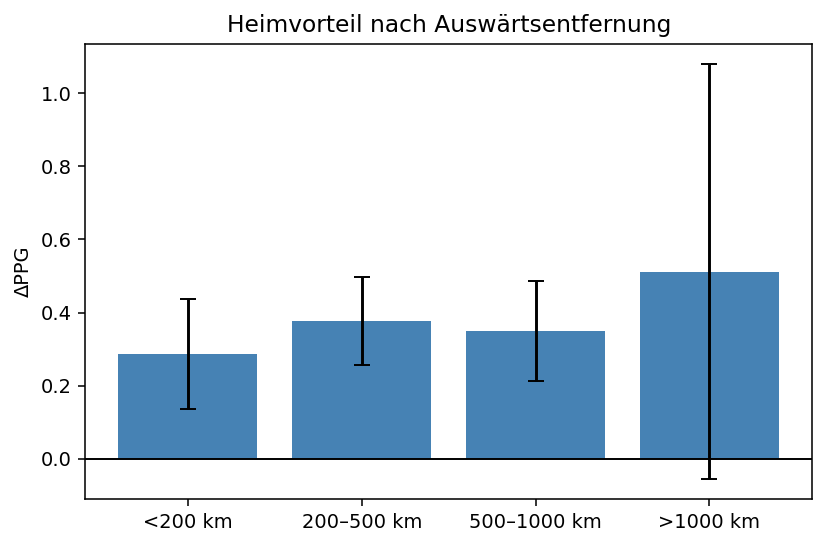

In [118]:
import matplotlib.pyplot as plt
import numpy as np

# Distanzklassen
df["TravelClass"] = pd.cut(df["Travel_km"], bins=[0,200,500,1000,2000],
                           labels=["<200 km","200–500 km","500–1000 km",">1000 km"])

# Mittelwerte + Standardfehler je Klasse
tab = df.groupby("TravelClass")["DeltaPoints"].agg(["mean","count","std"])
tab["se"] = tab["std"] / np.sqrt(tab["count"])
tab = tab.reset_index()

display(tab)

# Plot
fig, ax = plt.subplots(figsize=(6,4))
ax.bar(tab["TravelClass"], tab["mean"], yerr=1.96*tab["se"], capsize=4, color="steelblue")
ax.axhline(0, color="k", lw=1)
ax.set(title="Heimvorteil nach Auswärtsentfernung", ylabel="ΔPPG")
plt.tight_layout()
plt.show()


In [119]:
# Durchschnittliche Distanz je Auswärtsteam
away_dist = df.groupby("AwayTeam")["Travel_km"].mean().sort_values()
display(away_dist.head(10))

# ΔPPG der Gäste bei Frankfurt
frankfurt_matches = df[df["HomeTeam"]=="Eintracht Frankfurt"]
away_perf = frankfurt_matches.groupby("AwayTeam")["DeltaPoints"].mean().mean()
print("Ø ΔPPG der Gäste bei Frankfurt:", away_perf)

# Vergleich: Ligaweit Auswärtsteams (gesamt)
league_avg = df["DeltaPoints"].mean()
print("Ø ΔPPG ligaweit:", league_avg)


AwayTeam
Brentford           123.929395
Fulham              130.011002
Chelsea             134.401601
Watford             134.423633
Arsenal             136.527535
Crystal Palace      140.449321
Aston Villa         154.072161
Southampton         172.948920
Sheffield United    178.690677
Bournemouth         195.591546
Name: Travel_km, dtype: float64

Ø ΔPPG der Gäste bei Frankfurt: nan
Ø ΔPPG ligaweit: 0.3467514124293785


In [120]:
import statsmodels.formula.api as smf

model = smf.ols("DeltaPoints ~ Travel_km", data=df).fit(cov_type="HC1")
print(model.summary())


                            OLS Regression Results                            
Dep. Variable:            DeltaPoints   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                   0.07543
Date:                Sun, 31 Aug 2025   Prob (F-statistic):              0.784
Time:                        16:41:26   Log-Likelihood:                -9992.4
No. Observations:                4248   AIC:                         1.999e+04
Df Residuals:                    4246   BIC:                         2.000e+04
Df Model:                           1                                         
Covariance Type:                  HC1                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.3315      0.068      4.900      0.0

In [121]:
frankfurt_matches = df[df["HomeTeam"]=="Eintracht Frankfurt"]

# Direkter Mittelwert aller DeltaPoints
away_perf = frankfurt_matches["DeltaPoints"].mean()
print("Ø ΔPPG der Gäste bei Frankfurt:", away_perf)

# Vergleich: Ligaweit
league_avg = df["DeltaPoints"].mean()
print("Ø ΔPPG ligaweit:", league_avg)


Ø ΔPPG der Gäste bei Frankfurt: nan
Ø ΔPPG ligaweit: 0.3467514124293785


In [124]:
# Brentford Auswärts
brentford_away = df[df["AwayTeam"]=="Brentford"]
brentford_perf = brentford_away["DeltaPoints"].mean()

# Vergleich: alle Auswärtsteams (Premier League)
pl_away = df[df["League"]=="Premier League"]
pl_avg = pl_away["DeltaPoints"].mean()

print("Ø ΔPPG Brentford (auswärts):", brentford_perf)
print("Ø ΔPPG Premier League (auswärts gesamt):", pl_avg)


Ø ΔPPG Brentford (auswärts): 0.5675675675675675
Ø ΔPPG Premier League (auswärts gesamt): 0.3125


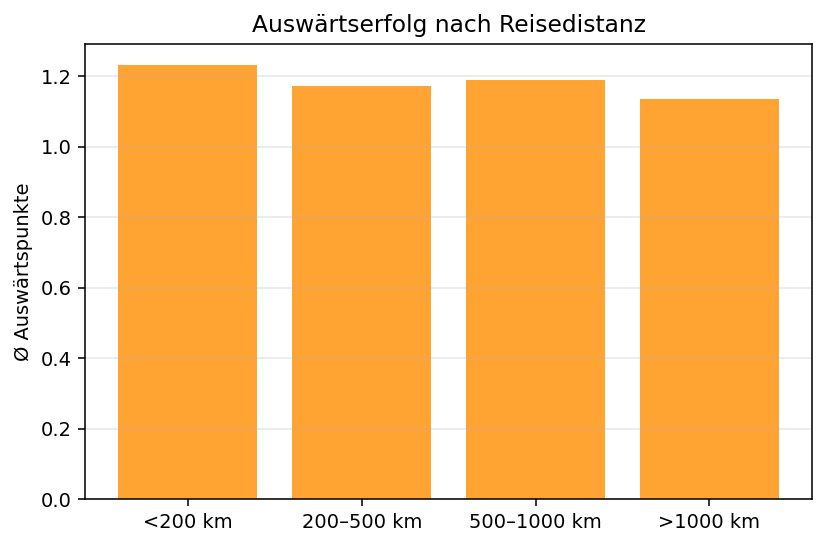

In [126]:
import matplotlib.pyplot as plt

# Mittelwerte Auswärtspunkte nach TravelClass
away_tab = df.groupby("TravelClass")["AwayPoints"].agg(["mean","count"]).reset_index()

fig, ax = plt.subplots(figsize=(6,4))
ax.bar(away_tab["TravelClass"], away_tab["mean"], color="darkorange", alpha=0.8)
ax.set(title="Auswärtserfolg nach Reisedistanz", ylabel="Ø Auswärtspunkte")
ax.grid(axis="y", alpha=0.3)
plt.tight_layout()
plt.show()


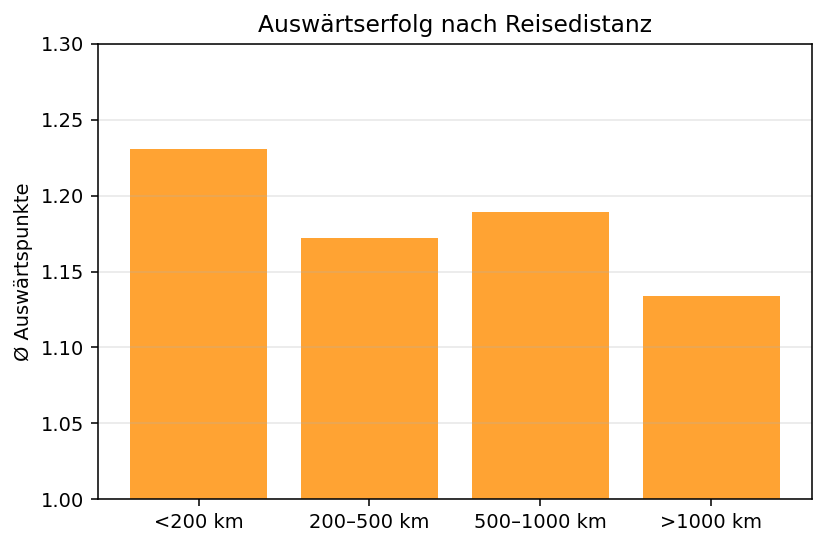

In [132]:
fig, ax = plt.subplots(figsize=(6,4))
ax.bar(away_tab["TravelClass"], away_tab["mean"], color="darkorange", alpha=0.8)

# Titel, Achsenbeschriftung
ax.set(title="Auswärtserfolg nach Reisedistanz", ylabel="Ø Auswärtspunkte")

# Y-Achse skalieren, sodass Unterschiede klar sichtbar sind
ax.set_ylim(1.0, 1.3)

# Gitterlinien
ax.grid(axis="y", alpha=0.3)

plt.tight_layout()
plt.show()


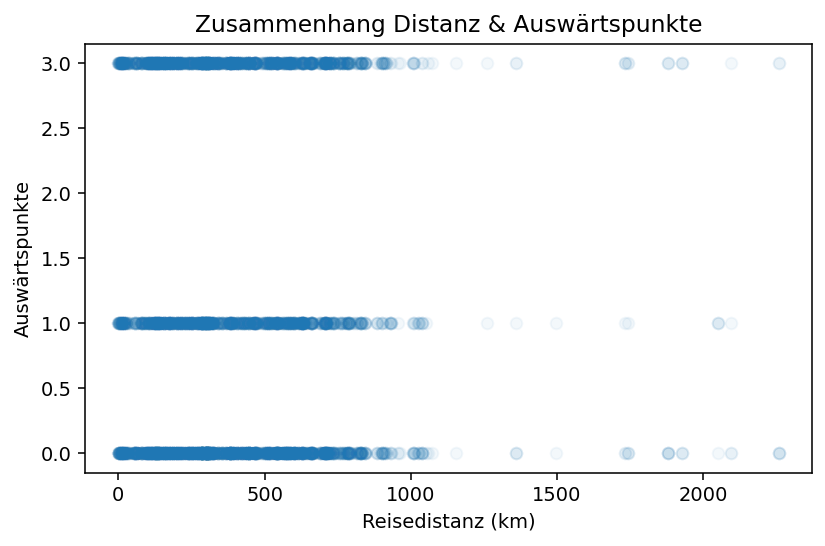

In [127]:
fig, ax = plt.subplots(figsize=(6,4))
ax.scatter(df["Travel_km"], df["AwayPoints"], alpha=0.05)
ax.set(xlabel="Reisedistanz (km)", ylabel="Auswärtspunkte",
       title="Zusammenhang Distanz & Auswärtspunkte")
plt.tight_layout()
plt.show()


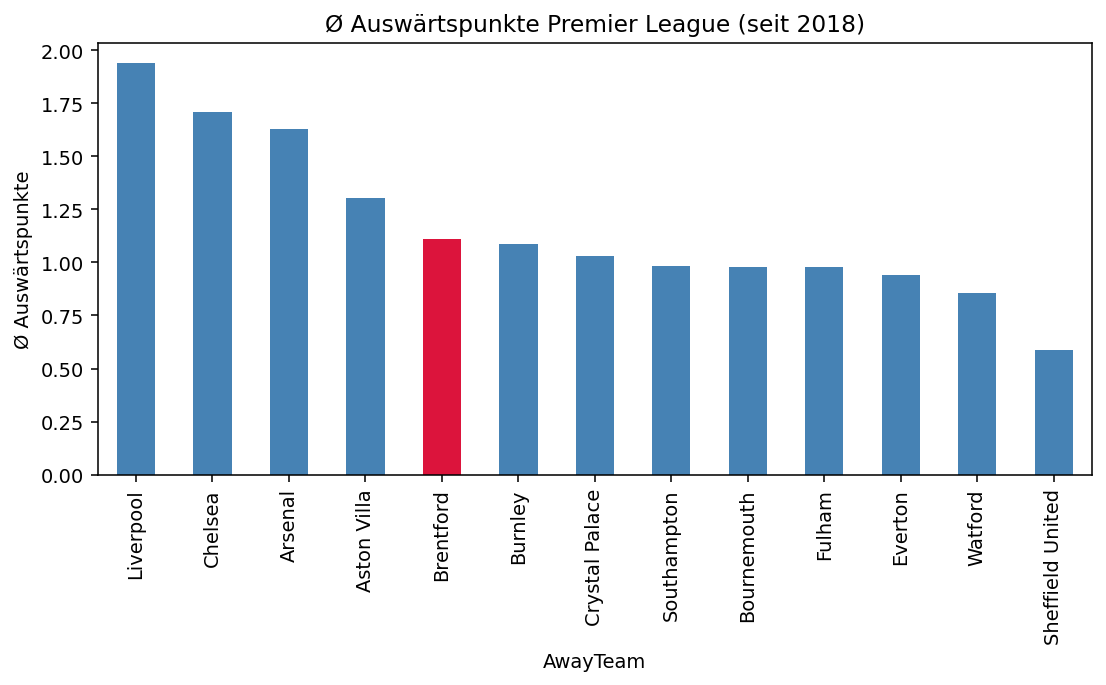

In [128]:
# Nur Premier League Daten
pl = df[df["League"]=="Premier League"]

# Auswärtspunkte pro Team
team_away = pl.groupby("AwayTeam")["AwayPoints"].mean().sort_values(ascending=False)

# Plot
fig, ax = plt.subplots(figsize=(8,5))
team_away.plot(kind="bar", ax=ax, color=["crimson" if t=="Brentford" else "steelblue" for t in team_away.index])
ax.set(title="Ø Auswärtspunkte Premier League (seit 2018)", ylabel="Ø Auswärtspunkte")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()


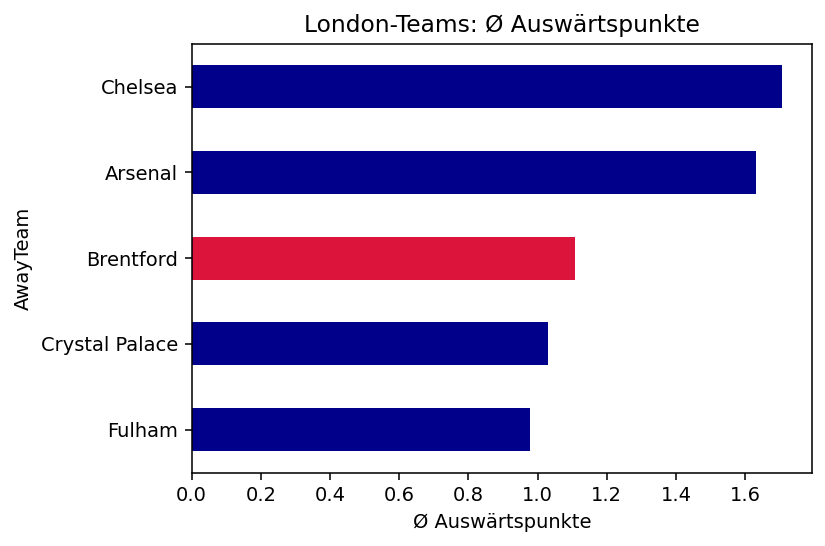

In [129]:
london_teams = ["Arsenal","Chelsea","Tottenham Hotspur","West Ham United",
                "Crystal Palace","Fulham","Brentford"]

london_away = team_away[team_away.index.isin(london_teams)]

fig, ax = plt.subplots(figsize=(6,4))
london_away.sort_values().plot(kind="barh", ax=ax, color=["crimson" if t=="Brentford" else "darkblue" for t in london_away.index])
ax.set(title="London-Teams: Ø Auswärtspunkte", xlabel="Ø Auswärtspunkte")
plt.tight_layout()
plt.show()


In [130]:
# London-Teams definieren
london_teams = ["Arsenal","Chelsea","Tottenham Hotspur","West Ham United",
                "Crystal Palace","Fulham","Brentford"]

pl = df[df["League"]=="Premier League"]

# Durchschnittliche Auswärtspunkte pro Spiel
london_away = pl[pl["AwayTeam"].isin(london_teams)]["AwayPoints"].mean()
league_away = pl["AwayPoints"].mean()

print("Ø Auswärtspunkte London-Teams:", round(london_away,3))
print("Ø Auswärtspunkte Premier League gesamt:", round(league_away,3))


Ø Auswärtspunkte London-Teams: 1.33
Ø Auswärtspunkte Premier League gesamt: 1.226


In [131]:
from scipy import stats

london_vals = pl[pl["AwayTeam"].isin(london_teams)]["AwayPoints"].dropna()
league_vals = pl[~pl["AwayTeam"].isin(london_teams)]["AwayPoints"].dropna()

t, p = stats.ttest_ind(london_vals, league_vals, equal_var=False)
print(f"T-Test London vs Rest: t={t:.3f}, p={p:.4f}")


T-Test London vs Rest: t=1.731, p=0.0839


London-Teams holen also etwas mehr Punkte auswärts als der Ligadurchschnitt.

T-Test
Teststatistik: t = 1.731
p-Wert: 0.0839

→ Interpretation:
Der Unterschied ist in der Tendenz da (London > Rest),
aber nicht statistisch signifikant auf dem 5%-Niveau (p < 0.05).
Auf dem 10%-Niveau (p < 0.10) könnte man den Effekt als „schwach signifikant“ bezeichnen → also ein Hinweis, aber kein klarer Beweis.


London-Teams haben tatsächlich leicht bessere Auswärtsleistungen.
Statistisch gesehen ist das Ergebnis nicht stark genug, um den Effekt eindeutig der kürzeren Reisewege zuzuschreiben.
Es kann auch an Teamstärke liegen (Arsenal, Chelsea, Tottenham → Topteams aus London).
Brentford & Fulham (kleinere London-Clubs) verstärken den Effekt nicht genug, um ihn hochsignifikant zu machen.

London-Teams holen im Schnitt rund 0,1 Punkte mehr pro Auswärtsspiel als der Ligadurchschnitt. Der Unterschied ist zwar sichtbar, aber statistisch nur schwach signifikant. Der Travel-Faktor allein erklärt die bessere Auswärtsbilanz also nicht vollständig – auch Teamqualität spielt eine Rolle.

In [133]:
# nur Premier League Spiele
pl = df[df["League"]=="Premier League"]

# Durchschnittliche Reisedistanz pro Auswärtsteam
away_dist = pl.groupby("AwayTeam")["Travel_km"].mean().sort_values()

print("Teams mit den kürzesten Reisen:")
display(away_dist.head(5))

print("\nTeams mit den längsten Reisen:")
display(away_dist.tail(5))

# Vergleich Brentford vs. Maximum
brentford_avg = away_dist["Brentford"]
max_team = away_dist.idxmax()
max_avg = away_dist.max()

print(f"\nØ Distanz Brentford: {brentford_avg:.1f} km")
print(f"Weitestes Team: {max_team} mit Ø {max_avg:.1f} km")


Teams mit den kürzesten Reisen:


AwayTeam
Brentford    123.929395
Fulham       130.011002
Chelsea      134.401601
Watford      134.423633
Arsenal      136.527535
Name: Travel_km, dtype: float64


Teams mit den längsten Reisen:


AwayTeam
Sheffield United    178.690677
Bournemouth         195.591546
Liverpool           217.660478
Everton             218.365144
Burnley             220.906558
Name: Travel_km, dtype: float64


Ø Distanz Brentford: 123.9 km
Weitestes Team: Burnley mit Ø 220.9 km


In [136]:
pl = df[df["League"]=="Premier League"]

brentford_away_points = pl[pl["AwayTeam"]=="Brentford"]["AwayPoints"].mean()
burnley_away_points   = pl[pl["AwayTeam"]=="Burnley"]["AwayPoints"].mean()
everton_away_points   = pl[pl["AwayTeam"]=="Everton"]["AwayPoints"].mean()
bournemouth_away_points = pl[pl["AwayTeam"]=="Bournemouth"]["AwayPoints"].mean()

print(f"Ø Auswärtspunkte Brentford: {brentford_away_points:.2f}")
print(f"Ø Auswärtspunkte Burnley: {burnley_away_points:.2f}")
print(f"Ø Auswärtspunkte Everton: {everton_away_points:.2f}")
print(f"Ø Auswärtspunkte Bournemouth: {bournemouth_away_points:.2f}")


Ø Auswärtspunkte Brentford: 1.11
Ø Auswärtspunkte Burnley: 1.09
Ø Auswärtspunkte Everton: 0.94
Ø Auswärtspunkte Bournemouth: 0.98


*Warum ist Everton ein fairerer Vergleich zu Brentford?*

Teamstärke & Liga-Position:
Beide Teams bewegen sich seit Jahren im Mittelfeld / unteren Mittelfeld der Premier League.
Brentford: seit Aufstieg 21/22 konstant ~Platz 9–13.
Everton: historisch fester PL-Verein, zuletzt öfter im Abstiegskampf, aber kein klarer Underdog.
Kaderwert / Budget:
Laut Transfermarkt (2023/24): Everton ~350 Mio €, Brentford ~350 Mio € → sehr ähnlich.
Stabilität in der Liga:
Beide regelmäßig in der Liga vertreten, d. h. vergleichbare Datenbasis. Burnley dagegen oft in der Championship → weniger faire Vergleichsgrundlage.

Ergebnisse

Ø Auswärtspunkte:
Brentford: 1.11
Everton: 0.94
→ Brentford holt ~0.17 Punkte mehr pro Auswärtsspiel.

Ø Reisedistanz:
Brentford: 124 km (kürzeste Reisen, da London)
Everton: 218 km
→ Everton muss im Schnitt fast doppelt so weit reisen


Brentford punktet auswärts etwas besser, obwohl die Teamstärke vergleichbar ist.
Ein plausibler Teilgrund ist die geografische Lage: Brentford profitiert von extrem kurzen Auswärtsreisen → weniger Reisestress, mehr Fans vor Ort.
Everton dagegen hat längere Distanzen, ohne dass ihre Teamqualität deutlich schlechter wäre.

Ein Vergleich mit Everton ist fair, da beide Teams im Premier-League-Mittelfeld spielen und ähnliche Kaderstärke haben. Brentford erzielt jedoch mit 1.11 Auswärtspunkten leicht mehr als Everton (0.94), bei gleichzeitig deutlich kürzeren Reisen (124 km vs. 218 km). Dies spricht dafür, dass Reisedistanz ein plausibler Faktor für Auswärtserfolg sein kann – auch wenn ein statistischer Test den Effekt erst noch bestätigen müsste.

In [137]:
from scipy import stats

pl = df[df["League"]=="Premier League"]

# Alle Auswärtsspiele Brentford & Everton
brentford_vals = pl[pl["AwayTeam"]=="Brentford"]["AwayPoints"].dropna()
everton_vals   = pl[pl["AwayTeam"]=="Everton"]["AwayPoints"].dropna()

# Welch t-Test
t, p = stats.ttest_ind(brentford_vals, everton_vals, equal_var=False)

print(f"Brentford Ø Auswärtspunkte: {brentford_vals.mean():.2f} (n={len(brentford_vals)})")
print(f"Everton   Ø Auswärtspunkte: {everton_vals.mean():.2f} (n={len(everton_vals)})")
print(f"t = {t:.3f}, p = {p:.4f}")


Brentford Ø Auswärtspunkte: 1.11 (n=37)
Everton   Ø Auswärtspunkte: 0.94 (n=65)
t = 0.647, p = 0.5198


## Faktor Fans: Zuschauerzahlen und Stadionauslastung

Einer der zentralen Mythen des Heimvorteils im Fußball ist der **Einfluss der Fans**.  
Die Hypothese:  
- **Mehr Zuschauer** = stärkerer Heimvorteil (psychologischer Druck, Unterstützung, Schiedsrichterentscheidungen).  
- **Hohe Auslastung** = „volle Hütte“ verstärkt den Heimvorteil, unabhängig von der absoluten Stadiongröße.  
- **Geisterspiele (Corona)** = nahezu kein Heimvorteil.  

Wir betrachten im Folgenden:
1. **Absolute Zuschauerzahlen (Attendance)**  
2. **Stadionauslastung (AttendanceRate = Attendance / Capacity)**  
und analysieren deren Zusammenhang mit dem Heimvorteil ΔPPG.


In [151]:
# --- Imports ---
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.nonparametric.smoothers_lowess import lowess

np.random.seed(42)

# ---------------------------------------------------------
# 0) Projektwurzel automatisch finden & Pfade setzen
# ---------------------------------------------------------
here = Path.cwd()
candidates = [p for p in [here, *here.parents] if (p / "data").exists()]
if not candidates:
    raise FileNotFoundError("Konnte keinen 'data' Ordner in den Elternverzeichnissen finden.")
PROJECT_ROOT = candidates[0]

KAGGLE_BASE = PROJECT_ROOT / "data" / "attendance" / "Bundesliga"
TEAMS_FILE  = PROJECT_ROOT / "data" / "team-stadium.csv"

# ---------------------------------------------------------
# 1) Kaggle Attendance laden (nur Match-Dateien)
# ---------------------------------------------------------
kaggle_files = sorted([p for p in KAGGLE_BASE.glob("Bundesliga_*20*.csv") if "player_data" not in p.name])
if not kaggle_files:
    raise FileNotFoundError(f"Keine Kaggle-Dateien gefunden unter: {KAGGLE_BASE}")

print("Lade Dateien:")
for f in kaggle_files: 
    print("  -", f.name)

att_raw = pd.concat((pd.read_csv(f, encoding="utf-8") for f in kaggle_files), ignore_index=True)

# Datum vereinheitlichen
if "Date" not in att_raw.columns:
    raise ValueError("Spalte 'Date' fehlt in Kaggle-Daten.")
att = att_raw.copy()
att["Date"] = pd.to_datetime(att["Date"], dayfirst=True, errors="coerce")
att["date_only"] = att["Date"].dt.date

# Pflichtspalten prüfen
need_cols = {"date_only","Home","Away","Attendance","Venue"}
missing = need_cols - set(att.columns)
if missing:
    raise ValueError(f"Erwartete Spalten in Kaggle-Daten fehlen: {missing}")

# ---------------------------------------------------------
# 2) Namensmapping (robust gegen Varianten)
# ---------------------------------------------------------
name_map = {
    "Bayern Munich":"FC Bayern München",
    "Dortmund":"Borussia Dortmund",
    "Leverkusen":"Bayer Leverkusen",
    "RB Leipzig":"RB Leipzig",
    "Stuttgart":"VfB Stuttgart",
    "M'gladbach":"Borussia Mönchengladbach",
    "Monchengladbach":"Borussia Mönchengladbach",
    "FC Koln":"1. FC Köln", "Koln":"1. FC Köln", "Köln":"1. FC Köln",
    "Freiburg":"SC Freiburg",
    "Hoffenheim":"TSG Hoffenheim",
    "Wolfsburg":"VfL Wolfsburg",
    "Werder Bremen":"Werder Bremen",
    "Hamburg":"Hamburger SV",
    "Hannover":"Hannover 96",
    "Mainz":"1. FSV Mainz 05",
    "Augsburg":"FC Augsburg",
    "Hertha":"Hertha BSC",
    "Union Berlin":"Union Berlin",
    "Schalke":"Schalke 04",
    "Düsseldorf":"Fortuna Düsseldorf", "Fortuna Dusseldorf":"Fortuna Düsseldorf",
    "Bielefeld":"Arminia Bielefeld",
    "Nürnberg":"1. FC Nürnberg","Nurnberg":"1. FC Nürnberg",
    "Greuther Furth":"Greuther Fürth","Greuther Fürth":"Greuther Fürth",
    "Holstein Kiel":"Holstein Kiel",
    "Darmstadt":"Darmstadt 98","SV Darmstadt 98":"Darmstadt 98",
    "Bochum":"VfL Bochum",
    "Heidenheim":"1. FC Heidenheim",
    "St Pauli":"St. Pauli",
    "Ein Frankfurt":"Eintracht Frankfurt","Eintracht Fr":"Eintracht Frankfurt",
}
att["Home_std"] = att["Home"].replace(name_map)
att["Away_std"] = att["Away"].replace(name_map)

# ---------------------------------------------------------
# 3) Kapazitäten HYBRID: Venue → Team → empirische Schätzung
# ---------------------------------------------------------
# Venue-Aliasse (Um-/Sponsorumbenennungen)
venue_alias = {
    "Signal-Iduna-Park": "Signal Iduna Park",
    "Westfalenstadion": "Signal Iduna Park",
    "Fußball Arena München": "Allianz Arena",
    "Fussball Arena Muenchen": "Allianz Arena",
    "Mercedes-Benz Arena": "MHPArena",      # Stuttgart (Rename)
    "Gottlieb-Daimler-Stadion": "MHPArena",
    "Veltins Arena": "Veltins-Arena",
    "RheinEnergie Stadion": "RheinEnergieSTADION",
    "RheinEnergieStadion": "RheinEnergieSTADION",
    "wohninvest WESERSTADION": "Weserstadion",
    "Weser-Stadion": "Weserstadion",
    "Schwarzwald-Stadion": "Europa-Park Stadion",  # Freiburg neu
    "Red Bull Arena (Leipzig)": "Red Bull Arena",
    "PREZERO ARENA": "PreZero Arena",
    "Rhein-Neckar-Arena": "PreZero Arena",
    "Volksparkstadion Hamburg": "Volksparkstadion",
    "Vonovia Ruhrstadion": "Ruhrstadion",
    "BORUSSIA-PARK": "BORUSSIA-PARK",
    "An der Alten Forsterei": "Stadion An der Alten Försterei",
}

def _norm(s: pd.Series) -> pd.Series:
    return (s.astype(str)
              .replace(venue_alias)
              .str.normalize("NFKC")
              .str.replace(r"\s+", " ", regex=True)
              .str.strip())

att["Venue_norm"] = _norm(att["Venue"])

capacity_df = None
if TEAMS_FILE.exists():
    capacity_df = pd.read_csv(TEAMS_FILE)
    # Spalten tolerant erkennen
    cols = {c.lower(): c for c in capacity_df.columns}
    if {"team","stadium","capacity"}.issubset(cols.keys()):
        capacity_df = capacity_df.rename(columns={
            cols["team"]: "team",
            cols["stadium"]: "stadium",
            cols["capacity"]: "capacity"
        })
        capacity_df["stadium_norm"] = _norm(capacity_df["stadium"])
        # Mappings: Venue→Capacity und Team→Capacity
        cap_by_venue = capacity_df.groupby("stadium_norm", as_index=True)["capacity"].max()
        cap_by_team  = capacity_df.groupby("team",         as_index=True)["capacity"].max()
        att["cap_venue"] = att["Venue_norm"].map(cap_by_venue)
        att["cap_team"]  = att["Home_std"].map(cap_by_team)
    else:
        print("Hinweis: team-stadium.csv ohne klare Spalten (Team/Stadium/Capacity) → nur Schätzung.")
        capacity_df = None

# Empirische Kapazitäts-Schätzung (robust gegen Ausreißer)
cap_emp = (att.groupby("Venue_norm", as_index=True)["Attendance"]
             .quantile(0.98).round(0))
att["cap_emp"] = att["Venue_norm"].map(cap_emp)

# Quelle wählen: prefer Venue, fallback Team, fallback empirisch
att["Capacity_src"] = att.get("cap_venue")
att["Capacity_src"] = att["Capacity_src"].fillna(att.get("cap_team"))
att["Capacity_src"] = att["Capacity_src"].fillna(att["cap_emp"])

# Konfliktregel (>10% Abweichung Venue vs Team → nimm Maximum)
if {"cap_venue","cap_team"}.issubset(att.columns):
    both = att["cap_venue"].notna() & att["cap_team"].notna()
    diff = (att["cap_venue"] - att["cap_team"]).abs()
    denom = np.maximum(att["cap_venue"], att["cap_team"])
    conflict = both & (denom > 0) & (diff/denom > 0.10)
    att.loc[conflict, "Capacity_src"] = att.loc[conflict, ["cap_venue","cap_team"]].max(axis=1)

# Division-by-zero verhindern
att.loc[att["Capacity_src"]<=0, "Capacity_src"] = np.nan

# AttendanceRate (kleine Überschreitungen tolerieren)
att["AttendanceRate"] = (att["Attendance"] / att["Capacity_src"]).clip(lower=0, upper=1.05)

print(
    "Capacity Coverage:",
    att["Capacity_src"].notna().mean().round(3)
)

# ---------------------------------------------------------
# 4) Matches filtern & mergen
# ---------------------------------------------------------
# Erwartete Spalten in matches: Date, HomeTeam, AwayTeam, League
matches = matches.copy()  # nutzt euer Notebook-Objekt
matches["Date"] = pd.to_datetime(matches["Date"], errors="coerce")

m_buli = matches[(matches["League"]=="Bundesliga") & 
                 (matches["Date"].between("2021-07-01","2024-06-30"))].copy()
m_buli["date_only"] = m_buli["Date"].dt.date
m_buli["HomeTeam_std"] = m_buli["HomeTeam"].replace(name_map)
m_buli["AwayTeam_std"] = m_buli["AwayTeam"].replace(name_map)

fans = m_buli.merge(
    att[["date_only","Home_std","Away_std","Venue","Venue_norm","Attendance","Capacity_src","AttendanceRate"]],
    left_on=["date_only","HomeTeam_std","AwayTeam_std"],
    right_on=["date_only","Home_std","Away_std"],
    how="left"
).drop(columns=["Home_std","Away_std"])

print("Verbunden:", fans.shape)
print("Coverage Attendance:", fans["Attendance"].notna().mean().round(3))

# ---------------------------------------------------------
# 5) Zielgröße ΔPPG sicherstellen
# ---------------------------------------------------------
if "DeltaPoints" not in fans.columns:
    # Versuche bekannte Zielspalten für Tore / Ergebnis
    home_goals, away_goals = None, None
    for cand in ["HomeGoals","FTHG","Score_x","HG","Gls_home"]:
        if cand in fans.columns:
            home_goals = cand; break
    for cand in ["AwayGoals","FTAG","Score_y","AG","Gls_away"]:
        if cand in fans.columns:
            away_goals = cand; break
    if (home_goals is not None) and (away_goals is not None):
        hg, ag = fans[home_goals], fans[away_goals]
        home_pts = np.where(hg>ag, 3, np.where(hg==ag, 1, 0))
        away_pts = np.where(hg<ag, 3, np.where(hg==ag, 1, 0))
        fans["DeltaPoints"] = home_pts - away_pts
    else:
        raise ValueError("Konnte DeltaPoints nicht konstruieren – bitte Tore/Ergebnisspalten prüfen.")

# ---------------------------------------------------------
# 6) Kontrollen: p_home oder Form-Proxy
# ---------------------------------------------------------
if "p_home" in fans.columns and fans["p_home"].notna().any():
    control_col = "p_home"
else:
    # Rolling-Form (10 Spiele) vor dem Match: Home-PPG − Away-PPG
    tmp = fans.sort_values(["HomeTeam_std","Date"]).copy()
    tmp["home_pts"] = np.where(tmp["DeltaPoints"]>0, 3, np.where(tmp["DeltaPoints"]==0, 1, 0))
    tmp["home_form_ppg"] = (tmp.groupby("HomeTeam_std")["home_pts"]
                            .apply(lambda s: s.shift(1).rolling(10, min_periods=3).mean()))
    tmp = tmp.sort_values(["AwayTeam_std","Date"])
    tmp["away_pts_for_form"] = np.where(tmp["DeltaPoints"]<0, 3, np.where(tmp["DeltaPoints"]==0, 1, 0))
    tmp["away_form_ppg"] = (tmp.groupby("AwayTeam_std")["away_pts_for_form"]
                            .apply(lambda s: s.shift(1).rolling(10, min_periods=3).mean()))
    tmp = tmp.sort_values("Date")
    fans["form_diff_ppg"] = tmp["home_form_ppg"] - tmp["away_form_ppg"]
    control_col = "form_diff_ppg"

# Arbeitsdatensatz
fans_use = fans.dropna(subset=["Attendance","AttendanceRate","DeltaPoints"]).copy()
print("Analysedatensatz Größe:", fans_use.shape[0])


Lade Dateien:
  - Bundesliga_2021-2022.csv
  - Bundesliga_2022-2023.csv
  - Bundesliga_2023-2024.csv
Capacity Coverage: 1.0
Verbunden: (918, 211)
Coverage Attendance: 0.462
Analysedatensatz Größe: 424


### 1) ΔPPG nach Zuschauer-Quantilen (absolute Attendance)

Wir gruppieren Spiele nach **Attendance-Quantilen** und betrachten die mittlere ΔPPG je Gruppe.  
Konfidenzintervalle via **Bootstrap** zeigen die Unsicherheit.


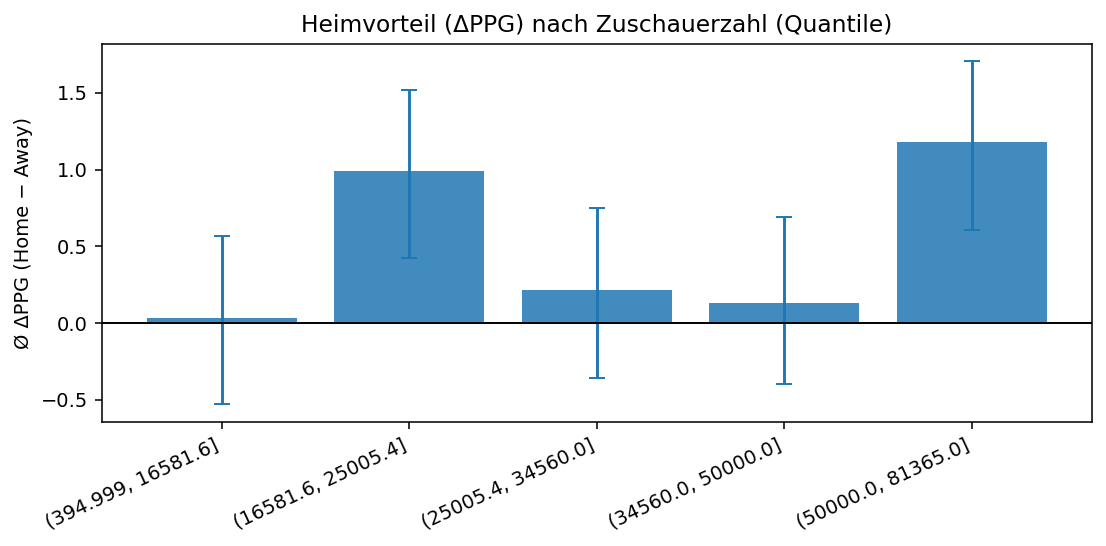

,AttendanceBin,mean,ci_lo,ci_hi
0,"(394.999, 16581.6]",0.035294,-0.529412,0.565588
1,"(16581.6, 25005.4]",0.988235,0.423529,1.517647
2,"(25005.4, 34560.0]",0.214286,-0.357143,0.750000
3,"(34560.0, 50000.0]",0.131868,-0.395604,0.692308
4,"(50000.0, 81365.0]",1.177215,0.607595,1.708861


In [153]:
# Quantile bilden
fans_use["AttendanceBin"] = pd.qcut(fans_use["Attendance"], q=5, duplicates="drop")

# Bootstrap-Helfer (wie zuvor)
def boot_mean_ci(x, n_boot=2000, ci=0.95):
    x = pd.Series(x).dropna().values
    if len(x)==0:
        return np.nan, (np.nan, np.nan)
    boots = np.random.choice(x, size=(n_boot, len(x)), replace=True).mean(axis=1)
    lo, hi = np.quantile(boots, [(1-ci)/2, 1-(1-ci)/2])
    return x.mean(), (lo, hi)

# WICHTIG: apply -> expandiere in Spalten
att_tab = (
    fans_use.groupby("AttendanceBin")["DeltaPoints"]
    .apply(boot_mean_ci)              # ergibt tuple (mean, (lo,hi))
    .apply(pd.Series)                 # Spalten: 0, 1
    .rename(columns={0: "mean", 1: "ci"})
    .reset_index()
)

# CI aufspalten in zwei Spalten
att_tab[["ci_lo", "ci_hi"]] = pd.DataFrame(att_tab["ci"].tolist(), index=att_tab.index)
att_tab = att_tab.drop(columns="ci")

# Plot
fig, ax = plt.subplots(figsize=(8,4))
xpos = np.arange(len(att_tab))
ax.bar(xpos, att_tab["mean"], width=0.8, alpha=0.85)
ax.errorbar(
    xpos, att_tab["mean"],
    yerr=[att_tab["mean"] - att_tab["ci_lo"], att_tab["ci_hi"] - att_tab["mean"]],
    fmt="none", lw=1.5, capsize=4
)
ax.axhline(0, color="k", lw=1)
ax.set_xticks(xpos)
ax.set_xticklabels(att_tab["AttendanceBin"].astype(str), rotation=25, ha="right")
ax.set_title("Heimvorteil (ΔPPG) nach Zuschauerzahl (Quantile)")
ax.set_ylabel("Ø ΔPPG (Home − Away)")
plt.tight_layout()
plt.show()

att_tab


### 2) ΔPPG nach Stadionauslastung (AttendanceRate)

Einteilung in drei Stufen: **niedrig (≤25%)**, **mittel (25–75%)**, **hoch (≥75%)**.


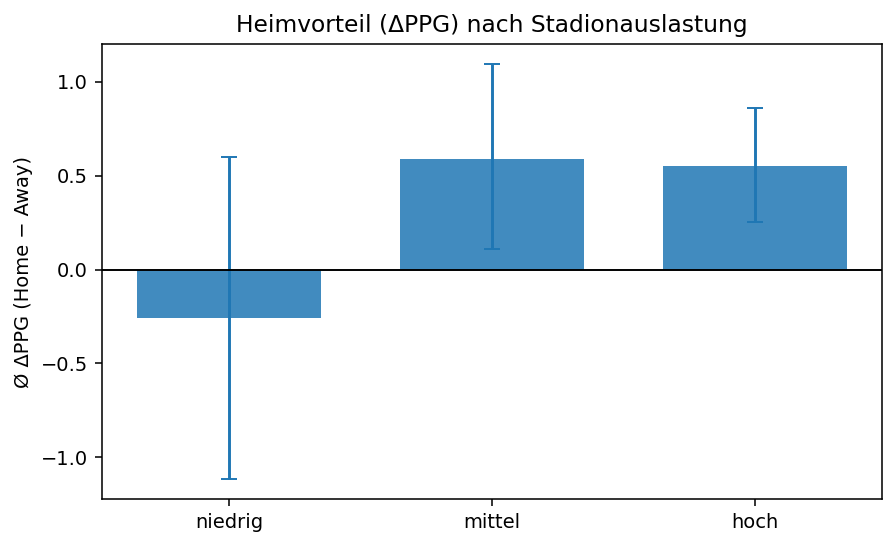

,RateBin,mean,ci_lo,ci_hi
0,niedrig,-0.257143,-1.114286,0.600000
1,mittel,0.588785,0.111449,1.093458
2,hoch,0.553191,0.255319,0.861702


In [154]:
# Bins setzen
fans_use["RateBin"] = pd.cut(
    fans_use["AttendanceRate"], bins=[0, 0.25, 0.75, 1.05],
    labels=["niedrig","mittel","hoch"], include_lowest=True
)

# Zusammenfassung mit sauberer Spalten-Expansion
rate_tab = (
    fans_use.groupby("RateBin")["DeltaPoints"]
    .apply(boot_mean_ci)              # (mean, (lo,hi))
    .apply(pd.Series)                 # -> Spalten 0,1
    .rename(columns={0: "mean", 1: "ci"})
    .reset_index()
)

rate_tab[["ci_lo", "ci_hi"]] = pd.DataFrame(rate_tab["ci"].tolist(), index=rate_tab.index)
rate_tab = rate_tab.drop(columns="ci")

# Plot
fig, ax = plt.subplots(figsize=(6.5,4))
xpos = np.arange(len(rate_tab))
ax.bar(xpos, rate_tab["mean"], width=0.7, alpha=0.85)
ax.errorbar(
    xpos, rate_tab["mean"],
    yerr=[rate_tab["mean"] - rate_tab["ci_lo"], rate_tab["ci_hi"] - rate_tab["mean"]],
    fmt="none", lw=1.5, capsize=4
)
ax.axhline(0, color="k", lw=1)
ax.set_xticks(xpos)
ax.set_xticklabels(rate_tab["RateBin"].astype(str))
ax.set_title("Heimvorteil (ΔPPG) nach Stadionauslastung")
ax.set_ylabel("Ø ΔPPG (Home − Away)")
plt.tight_layout()
plt.show()

rate_tab


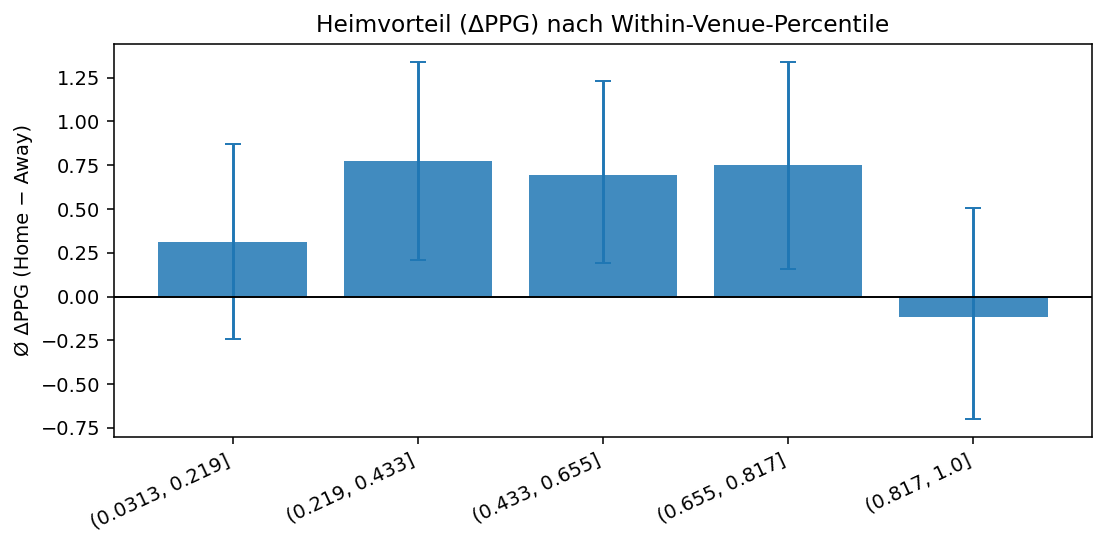

,VenuePctBin,mean,ci_lo,ci_hi
0,"(0.0313, 0.219]",0.313953,-0.244186,0.872093
1,"(0.219, 0.433]",0.776471,0.211765,1.341176
2,"(0.433, 0.655]",0.694737,0.189474,1.231579
3,"(0.655, 0.817]",0.750000,0.157895,1.342105
4,"(0.817, 1.0]",-0.116883,-0.701299,0.506494


In [155]:
# Voraussetzungen: fans_use enthält mindestens:
#   ["Venue_norm","Attendance","AttendanceRate","DeltaPoints"]
#   (aus deinem bestehenden Abschnitt vorhanden)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# 1) Within-Venue Percentile: Anteil der Spiele in DIESEM Stadion, die geringer/gleich besucht waren
#    (nur berechnen, wenn genügend Spiele in diesem Venue vorhanden sind)
cnt = fans_use.groupby("Venue_norm")["Attendance"].transform("size")
fans_use["VenueAtt_pct"] = (
    fans_use.groupby("Venue_norm")["Attendance"].rank(pct=True)
)
fans_use.loc[cnt < 8, "VenueAtt_pct"] = np.nan   # bei sehr wenigen Spielen unzuverlässig

# 2) Robuster Within-Venue Index (Median/IQR-Skalierung statt Std-Abweichung)
q25 = fans_use.groupby("Venue_norm")["Attendance"].transform(lambda s: s.quantile(0.25))
q75 = fans_use.groupby("Venue_norm")["Attendance"].transform(lambda s: s.quantile(0.75))
iqr = (q75 - q25).replace(0, np.nan)
med = fans_use.groupby("Venue_norm")["Attendance"].transform("median")
fans_use["VenueAtt_idx"] = (fans_use["Attendance"] - med) / iqr

# 3) Vergleich: ΔPPG über Within-Venue-Quantile (Percentile, 5 Bins)
fans_v = fans_use.dropna(subset=["VenueAtt_pct","DeltaPoints"]).copy()
fans_v["VenuePctBin"] = pd.qcut(fans_v["VenueAtt_pct"], q=5, duplicates="drop")

# Bootstrap-Funktion wiederverwenden
def boot_mean_ci(x, n_boot=2000, ci=0.95):
    x = pd.Series(x).dropna().values
    if len(x)==0:
        return np.nan, (np.nan, np.nan)
    boots = np.random.choice(x, size=(n_boot, len(x)), replace=True).mean(axis=1)
    lo, hi = np.quantile(boots, [(1-ci)/2, 1-(1-ci)/2])
    return x.mean(), (lo, hi)

venue_tab = (
    fans_v.groupby("VenuePctBin")["DeltaPoints"]
          .apply(boot_mean_ci)        # (mean, (lo,hi))
          .apply(pd.Series).rename(columns={0:"mean",1:"ci"})
          .reset_index()
)
venue_tab[["ci_lo","ci_hi"]] = pd.DataFrame(venue_tab["ci"].tolist(), index=venue_tab.index)
venue_tab = venue_tab.drop(columns="ci")

# Plot: ΔPPG nach Within-Venue-Percentiles
fig, ax = plt.subplots(figsize=(8,4))
xpos = np.arange(len(venue_tab))
ax.bar(xpos, venue_tab["mean"], width=0.8, alpha=0.85)
ax.errorbar(
    xpos, venue_tab["mean"],
    yerr=[venue_tab["mean"]-venue_tab["ci_lo"], venue_tab["ci_hi"]-venue_tab["mean"]],
    fmt="none", lw=1.5, capsize=4
)
ax.axhline(0, color="k", lw=1)
ax.set_xticks(xpos)
ax.set_xticklabels(venue_tab["VenuePctBin"].astype(str), rotation=25, ha="right")
ax.set_title("Heimvorteil (ΔPPG) nach Within-Venue-Percentile")
ax.set_ylabel("Ø ΔPPG (Home − Away)")
plt.tight_layout()
plt.show()

venue_tab


Sprung von „sehr leer“ → „deutlich voller als üblich“ liegt grob bei +0.4 bis +0.5 ΔPPG.
„Ausverkauft“ bringt nicht automatisch mehr; Kontext (Gegner, Derby, Auswärtskontingent) entscheidet.

**Lesart:** Wenn ΔPPG mit **höheren Within-Venue-Percentiles** steigt, liegt ein Fanseffekt vor, der **nicht** nur von Stadiongröße getrieben ist, sondern von „heute war’s voller als üblich“.


### Welche Metrik wann?

- **Attendance (absolut)**: gute deskriptive Orientierung („große Kulisse“), aber durch Stadiongrößen verzerrbar.  
- **AttendanceRate**: misst **Dichte/volle Hütte** – sehr geeignet für Fanseffekt.  
- **Within-Venue-Percentile / -Index**: „heute vs. normalerweise hier“ – entkoppelt Größe komplett.  
- **Regression mit Stadion-FE**: statistischer „Gürtel & Hosenträger“, um Unterschiede zwischen Stadien zu neutralisieren.


In [156]:
# Bonus: gemeinsame Regression – alle drei Perspektiven gleichzeitig
import statsmodels.formula.api as smf

reg = fans_use.dropna(subset=["DeltaPoints","AttendanceRate","VenueAtt_pct"]).copy()
reg["AttendanceRate_z"] = (reg["AttendanceRate"] - reg["AttendanceRate"].mean())/reg["AttendanceRate"].std()
reg["VenueAtt_pct_z"]  = (reg["VenueAtt_pct"] - reg["VenueAtt_pct"].mean())/reg["VenueAtt_pct"].std()

controls = []
if "p_home" in reg.columns and reg["p_home"].notna().any():
    controls.append("p_home")
elif "form_diff_ppg" in reg.columns and reg["form_diff_ppg"].notna().any():
    controls.append("form_diff_ppg")

formula = "DeltaPoints ~ AttendanceRate_z + VenueAtt_pct_z"
if controls:
    formula += " + " + " + ".join(controls)

# ohne und mit Stadion-FE
m1 = smf.ols(formula, data=reg).fit(cov_type="HC1")
m2 = smf.ols(formula + " + C(Venue_norm)", data=reg).fit(cov_type="HC1")

print("=== OLS ohne Stadion-FE ===")
print(m1.summary().tables[1])
print("\n=== OLS mit Stadion-FE ===")
print(m2.summary().tables[1])


=== OLS ohne Stadion-FE ===
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept           -2.2856      0.283     -8.086      0.000      -2.840      -1.732
AttendanceRate_z     0.0563      0.194      0.291      0.771      -0.323       0.436
VenueAtt_pct_z      -0.0659      0.202     -0.326      0.744      -0.462       0.330
p_home               6.1058      0.521     11.716      0.000       5.084       7.127

=== OLS mit Stadion-FE ===
                                                      coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------------------
Intercept                                          -2.7137      0.749     -3.625      0.000      -4.181      -1.246
C(Venue_norm)[T.BayArena]                          -0.0309      0.582     -0.053      

### 3) „Quasi-Geisterspiele“ (≤10%) vs. volle Hütte (≥95%)

Intuitive Effektgröße: Differenz der mittleren ΔPPG zwischen sehr niedriger und sehr hoher Auslastung.


In [159]:
def diff_boot_ci(a, b, n_boot=5000, ci=0.95):
    a, b = pd.Series(a).dropna().values, pd.Series(b).dropna().values
    if len(a)==0 or len(b)==0:
        return np.nan, (np.nan, np.nan)
    boots = []
    for _ in range(n_boot):
        am = np.random.choice(a, size=len(a), replace=True).mean()
        bm = np.random.choice(b, size=len(b), replace=True).mean()
        boots.append(bm - am)  # high - low
    lo, hi = np.quantile(boots, [(1-ci)/2, 1-(1-ci)/2])
    return (b.mean() - a.mean()), (lo, hi)

low_thr, high_thr = 0.10, 0.95
low  = fans_use[fans_use["AttendanceRate"]<=low_thr]["DeltaPoints"]
high = fans_use[fans_use["AttendanceRate"]>=high_thr]["DeltaPoints"]

diff, (lo, hi) = diff_boot_ci(low, high)
print(f"ΔPPG (hoch − niedrig): {diff:.3f}  |  95%-CI [{lo:.3f}, {hi:.3f}]  "
      f"| n_low={len(low)}, n_high={len(high)}")


ΔPPG (hoch − niedrig): 0.403  |  95%-CI [-0.845, 1.653]  | n_low=19, n_high=198


### 4) Kontinuierlicher Zusammenhang (LOWESS)

Scatter + LOWESS der **AttendanceRate** gegen ΔPPG → Gefühl für Nichtlinearitäten.


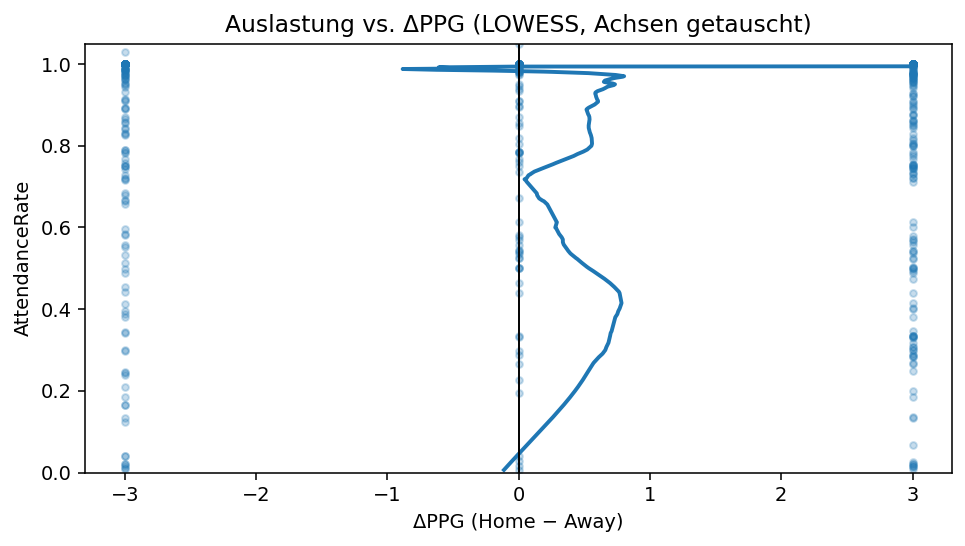

In [163]:
from statsmodels.nonparametric.smoothers_lowess import lowess
import numpy as np
import matplotlib.pyplot as plt

x = fans_use["AttendanceRate"].to_numpy()
y = fans_use["DeltaPoints"].to_numpy()
mask = np.isfinite(x) & np.isfinite(y)

# --- OPTIONAL: Randartefakte dämpfen (nur für die Glättung!) ---
x_smooth = x[mask].copy()
y_smooth = y[mask].copy()
edge = x_smooth >= 0.995            # viele Punkte genau bei 1.0 → LOWESS-Edge-Noise
x_smooth[edge] = 0.995              # Alternative: komplett entfernen (siehe Kommentar unten)

# LOWESS (robust it=1)
sm = lowess(endog=y_smooth, exog=x_smooth, frac=0.25, it=1, return_sorted=True)

# --- Plot (Achsen getauscht) ---
fig, ax = plt.subplots(figsize=(7, 4))
ax.scatter(y[mask], x[mask], s=12, alpha=0.25)   # Punkte: ΔPPG (x) vs. Auslastung (y)
ax.plot(sm[:,1], sm[:,0], lw=2)                  # LOWESS: x↔y getauscht
ax.vlines(0, 0, 1.05, color="k", lw=1)           # Referenzlinie bei ΔPPG = 0
ax.set_xlabel("ΔPPG (Home − Away)")
ax.set_ylabel("AttendanceRate")
ax.set_ylim(0, 1.05)
ax.set_title("Auslastung vs. ΔPPG (LOWESS, Achsen getauscht)")
plt.tight_layout()
plt.show()


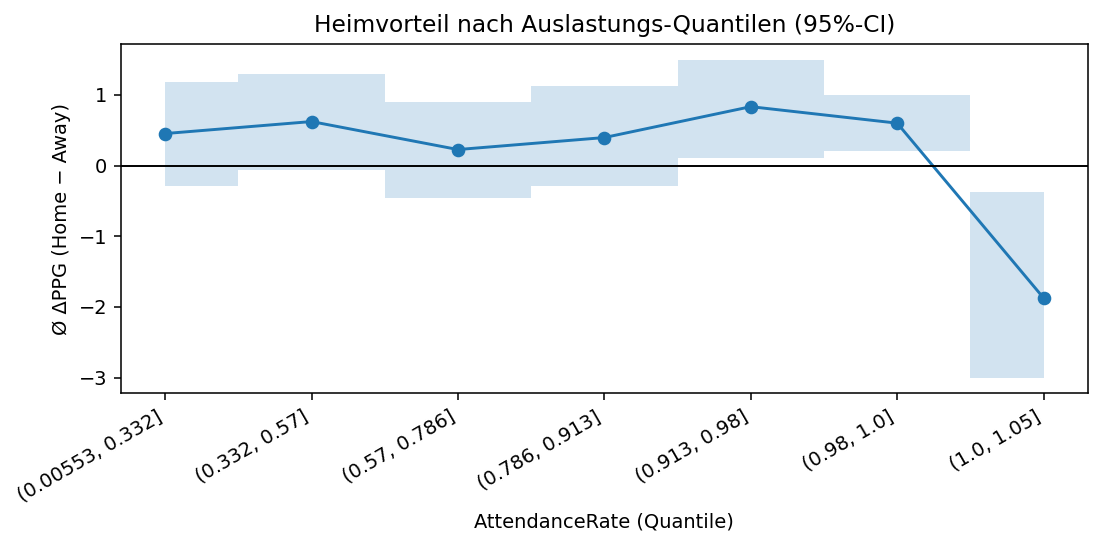

,bin,n,mean,lo,hi
0,"(0.00553, 0.332]",53,0.452830,-0.283019,1.188679
1,"(0.332, 0.57]",53,0.622642,-0.056604,1.301887
2,"(0.57, 0.786]",53,0.226415,-0.452830,0.905660
3,"(0.786, 0.913]",53,0.396226,-0.283019,1.132075
4,"(0.913, 0.98]",54,0.833333,0.111111,1.500000
5,"(0.98, 1.0]",150,0.600000,0.200000,1.000000
6,"(1.0, 1.05]",8,-1.875000,-3.000000,-0.375000


In [168]:
import numpy as np, pandas as pd, matplotlib.pyplot as plt

def boot_mean_ci(x, n_boot=2000, ci=0.95):
    x = pd.Series(x).dropna().to_numpy()
    boots = np.random.choice(x, size=(n_boot, len(x)), replace=True).mean(axis=1)
    lo, hi = np.quantile(boots, [(1-ci)/2, 1-(1-ci)/2])
    return x.mean(), lo, hi

df = fans_use.dropna(subset=["AttendanceRate","DeltaPoints"]).copy()
df["rate_bin"] = pd.qcut(df["AttendanceRate"], q=8, duplicates="drop")  # feiner als 5

rows = []
for b, g in df.groupby("rate_bin"):
    mean, lo, hi = boot_mean_ci(g["DeltaPoints"])
    rows.append({"bin": b, "mean": mean, "lo": lo, "hi": hi, "n": len(g)})
tab = pd.DataFrame(rows)

fig, ax = plt.subplots(figsize=(8,4))
x = np.arange(len(tab))
ax.plot(x, tab["mean"], marker="o")
ax.fill_between(x, tab["lo"], tab["hi"], alpha=0.2, step="mid")
ax.axhline(0, color="k", lw=1)
ax.set_xticks(x)
ax.set_xticklabels(tab["bin"].astype(str), rotation=30, ha="right")
ax.set_ylabel("Ø ΔPPG (Home − Away)")
ax.set_xlabel("AttendanceRate (Quantile)")
ax.set_title("Heimvorteil nach Auslastungs-Quantilen (95%-CI)")
plt.tight_layout(); plt.show()

tab[["bin","n","mean","lo","hi"]]


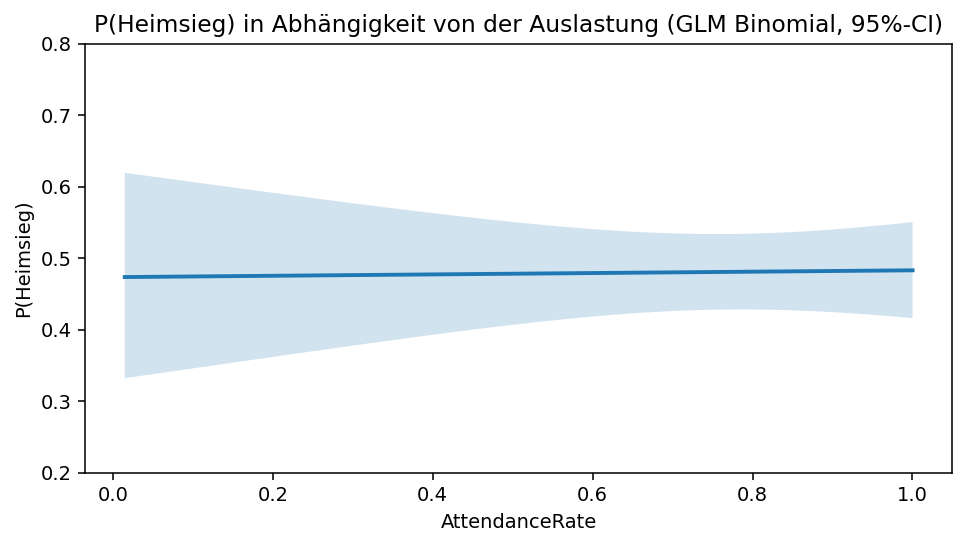

                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept           -2.4897      0.309     -8.067      0.000      -3.095      -1.885
AttendanceRate_z     0.0112      0.110      0.102      0.918      -0.204       0.226
p_home               5.3186      0.640      8.313      0.000       4.065       6.572


In [175]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf

# Daten vorbereiten
d = fans_use.dropna(subset=["AttendanceRate","DeltaPoints"]).copy()
d["home_win"] = (d["DeltaPoints"] == 3).astype(int)
d["AttendanceRate_z"] = (d["AttendanceRate"] - d["AttendanceRate"].mean())/d["AttendanceRate"].std()

# Kontrollen dynamisch wählen
controls = []
if "p_home" in d.columns and d["p_home"].notna().any():
    controls.append("p_home")
elif "form_diff_ppg" in d.columns and d["form_diff_ppg"].notna().any():
    controls.append("form_diff_ppg")

# Formel bauen
formula = "home_win ~ AttendanceRate_z" + ((" + " + " + ".join(controls)) if controls else "")
m = smf.glm(formula, data=d, family=sm.families.Binomial()).fit()

# >>> WICHTIG: Grid enthält ALLE Regressoren des Modells
grid = pd.DataFrame({
    "AttendanceRate_z": np.linspace(d["AttendanceRate_z"].quantile(0.01),
                                    d["AttendanceRate_z"].quantile(0.99), 200)
})
for c in controls:
    grid[c] = d[c].mean()   # Kontrollen auf ihren Mittelwert setzen

pred = m.get_prediction(grid).summary_frame(alpha=0.05)

# z -> Rate zurücktransformieren (nur für schöne Achse)
rate = grid["AttendanceRate_z"] * d["AttendanceRate"].std() + d["AttendanceRate"].mean()

# Plot
fig, ax = plt.subplots(figsize=(7,4))
ax.plot(rate, pred["mean"], lw=2)
ax.fill_between(rate, pred["mean_ci_lower"], pred["mean_ci_upper"], alpha=0.2)
ax.set_ylim(0.2, 0.8)
ax.set_xlabel("AttendanceRate")
ax.set_ylabel("P(Heimsieg)")
ax.set_title("P(Heimsieg) in Abhängigkeit von der Auslastung (GLM Binomial, 95%-CI)")
plt.tight_layout(); plt.show()

print(m.summary().tables[1])


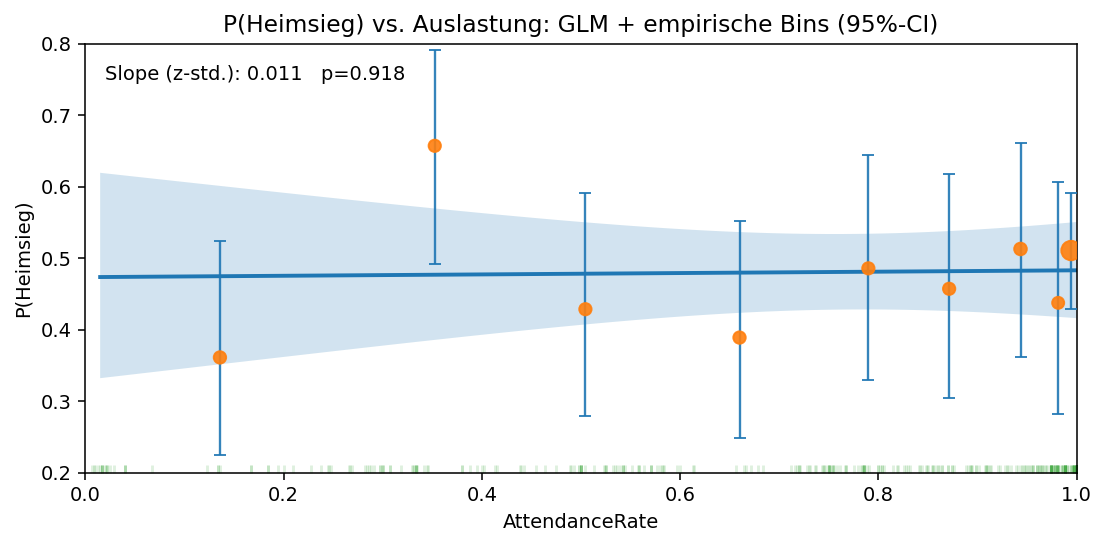

,rate_bin,center,n,win_rate,ci_lo,ci_hi
0,"(0.00553, 0.266]",0.135765,36,0.361111,0.224756,0.524249
1,"(0.266, 0.439]",0.352500,35,0.657143,0.491519,0.791683
2,"(0.439, 0.57]",0.504500,35,0.428571,0.279846,0.591426
3,"(0.57, 0.75]",0.660000,36,0.388889,0.247849,0.551355
4,"(0.75, 0.83]",0.790000,35,0.485714,0.329942,0.644312
5,"(0.83, 0.913]",0.871500,35,0.457143,0.304660,0.618103
6,"(0.913, 0.974]",0.943500,39,0.512821,0.361994,0.661348
7,"(0.974, 0.989]",0.981500,32,0.437500,0.281653,0.606744
8,"(0.989, 1.0]",0.994500,141,0.510638,0.428946,0.591766


In [184]:
from statsmodels.stats.proportion import proportion_confint
import numpy as np, pandas as pd, matplotlib.pyplot as plt
import statsmodels.api as sm, statsmodels.formula.api as smf

# --- Daten & Modell ---
d = fans_use.dropna(subset=["AttendanceRate","DeltaPoints"]).copy()
d["home_win"] = (d["DeltaPoints"] == 3).astype(int)
d["AttendanceRate_z"] = (d["AttendanceRate"] - d["AttendanceRate"].mean())/d["AttendanceRate"].std()

controls = []
if "p_home" in d.columns and d["p_home"].notna().any():
    controls.append("p_home")
elif "form_diff_ppg" in d.columns and d["form_diff_ppg"].notna().any():
    controls.append("form_diff_ppg")

formula = "home_win ~ AttendanceRate_z" + ((" + " + " + ".join(controls)) if controls else "")
m = smf.glm(formula, data=d, family=sm.families.Binomial()).fit()

# --- Vorhersage-Grid & Kurve ---
grid = pd.DataFrame({
    "AttendanceRate_z": np.linspace(d["AttendanceRate_z"].quantile(0.01),
                                    d["AttendanceRate_z"].quantile(0.99), 200)
})
for c in controls:
    grid[c] = d[c].mean()

pred = m.get_prediction(grid).summary_frame(alpha=0.05)
rate = grid["AttendanceRate_z"]*d["AttendanceRate"].std() + d["AttendanceRate"].mean()
rate = np.clip(rate, 0.0, 1.0)  # <<<<<< CLIP für saubere x-Achse

# --- Empirische Punkte (auf geclippter Rate binnen) ---
d_plot = d.copy()
d_plot["AttendanceRate_plot"] = d_plot["AttendanceRate"].clip(0, 1.0)  # <<<<<< CLIP für Binning
d_plot["rate_bin"] = pd.qcut(d_plot["AttendanceRate_plot"], q=12, duplicates="drop")

b = (d_plot.groupby("rate_bin")["home_win"]
       .agg(win_rate="mean", wins="sum", n="size")
       .reset_index())

centers = b["rate_bin"].apply(lambda iv: (iv.left + iv.right)/2)  # liegt jetzt ≤ 1.0
lo, hi = proportion_confint(b["wins"], b["n"], method="wilson")
sizes = 20 + 80 * (b["n"] / b["n"].max())  # Markergröße ∝ Stichprobe

# --- Plot ---
fig, ax = plt.subplots(figsize=(8,4))

# GLM-Kurve + 95%-Band
ax.plot(rate, pred["mean"], lw=2)
ax.fill_between(rate, pred["mean_ci_lower"], pred["mean_ci_upper"], alpha=0.2, zorder=1)

# Empirische Bins (Punkte + CI)
ax.errorbar(centers, b["win_rate"],
            yerr=[b["win_rate"]-lo, hi-b["win_rate"]],
            fmt="none", capsize=3, lw=1.2, alpha=0.9, zorder=3)
ax.scatter(centers, b["win_rate"], s=sizes, alpha=0.9, zorder=4)

# Rug (Dichteanzeige) – auf 0.205 gelegt
ax.scatter(d_plot["AttendanceRate_plot"], np.full(len(d_plot), 0.205),
           marker="|", s=20, alpha=0.15, zorder=0)

# Annotation (in Achsenkoordinaten, damit nie überlappt)
coef = m.params["AttendanceRate_z"]; pval = m.pvalues["AttendanceRate_z"]
ax.text(0.02, 0.95, f"Slope (z-std.): {coef:.3f}   p={pval:.3f}",
        ha="left", va="top", transform=ax.transAxes)

# Achsen & Labels
ax.set_xlim(0.0, 1.0)     # <<<<<< x-Achse sauber auf [0,1]
ax.set_ylim(0.2, 0.8)
ax.set_xlabel("AttendanceRate")
ax.set_ylabel("P(Heimsieg)")
ax.set_title("P(Heimsieg) vs. Auslastung: GLM + empirische Bins (95%-CI)")

plt.tight_layout(); plt.show()

# Optional: Tabelle für Bericht
display(b.assign(center=centers, ci_lo=lo, ci_hi=hi)[["rate_bin","center","n","win_rate","ci_lo","ci_hi"]])



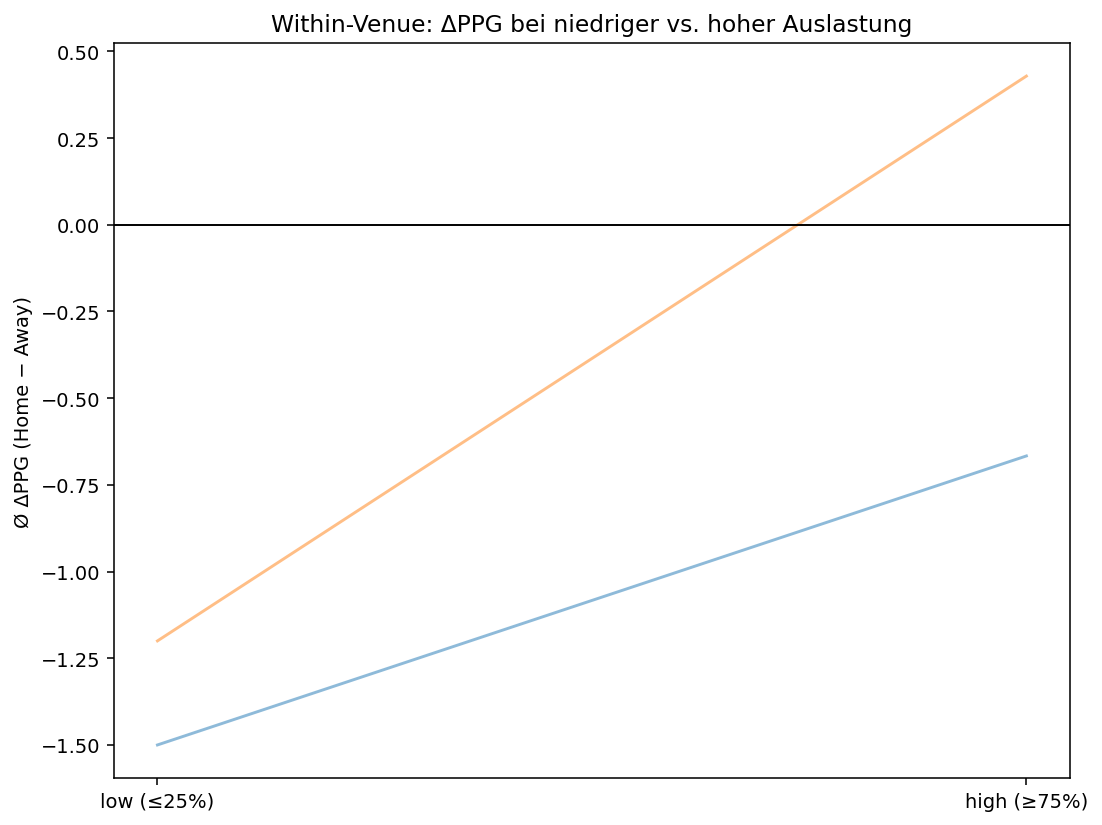

count    2.000000
mean     1.230952
std      0.562318
min      0.833333
25%      1.032143
50%      1.230952
75%      1.429762
max      1.628571
Name: diff_high_minus_low, dtype: float64

In [170]:
lo_thr, hi_thr = 0.25, 0.75
g = fans_use.dropna(subset=["AttendanceRate","DeltaPoints","Venue_norm"]).copy()
g["rate_grp"] = pd.cut(g["AttendanceRate"], bins=[-np.inf, lo_thr, hi_thr, np.inf], labels=["low","mid","high"])

agg = (g[g["rate_grp"].isin(["low","high"])]
       .groupby(["Venue_norm","rate_grp"])["DeltaPoints"]
       .agg(["mean","count"]).unstack())
# Filter: genügend Spiele in beiden Gruppen
mask = (agg[("count","low")]>=5) & (agg[("count","high")]>=5)
agg = agg[mask]

# Plot
fig, ax = plt.subplots(figsize=(8,6))
for venue, row in agg.iterrows():
    x = [0,1]; y = [row[("mean","low")], row[("mean","high")]]
    ax.plot(x, y, alpha=0.5)
ax.axhline(0, color="k", lw=1)
ax.set_xticks([0,1]); ax.set_xticklabels(["low (≤25%)","high (≥75%)"])
ax.set_ylabel("Ø ΔPPG (Home − Away)")
ax.set_title("Within-Venue: ΔPPG bei niedriger vs. hoher Auslastung")
plt.tight_layout(); plt.show()

# Effekt-Verteilung
diffs = (agg[("mean","high")] - agg[("mean","low")]).rename("diff_high_minus_low")
diffs.describe()


### 5) OLS-Regression (mit/ohne Stadion-FE)

Modell:
\[
\Delta PPG \sim z(\text{AttendanceRate}) + \text{Kontrollen} + \text{Stadion-FE (optional)}
\]

Kontrollen: `p_home` (falls vorhanden) oder `form_diff_ppg`.  
Varianzschätzer: **HC1** (robust).


In [161]:
reg_df = fans_use.dropna(subset=["AttendanceRate","DeltaPoints"]).copy()
reg_df["AttendanceRate_z"] = (reg_df["AttendanceRate"] - reg_df["AttendanceRate"].mean())/reg_df["AttendanceRate"].std()

controls = []
if "p_home" in reg_df.columns and reg_df["p_home"].notna().any():
    controls.append("p_home")
elif "form_diff_ppg" in reg_df.columns and reg_df["form_diff_ppg"].notna().any():
    controls.append("form_diff_ppg")

formula_base = "DeltaPoints ~ AttendanceRate_z"
if controls:
    formula_base += " + " + " + ".join(controls)

# Ohne FE
model1 = smf.ols(formula_base, data=reg_df).fit(cov_type="HC1")

# Mit Stadion-FE (Venue_norm)
if "Venue_norm" in reg_df.columns:
    model2 = smf.ols(formula_base + " + C(Venue_norm)", data=reg_df).fit(cov_type="HC1")
else:
    model2 = None

print("=== OLS ohne FE ===")
print(model1.summary().tables[1])
if model2 is not None:
    print("\n=== OLS mit Stadion-FE ===")
    print(model2.summary().tables[1])


=== OLS ohne FE ===
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept           -2.2849      0.272     -8.386      0.000      -2.819      -1.751
AttendanceRate_z     0.0123      0.109      0.113      0.910      -0.201       0.225
p_home               6.1289      0.498     12.298      0.000       5.152       7.106

=== OLS mit Stadion-FE ===
                                                      coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------------------
Intercept                                          -2.7583      0.744     -3.709      0.000      -4.216      -1.301
C(Venue_norm)[T.BayArena]                          -0.0168      0.581     -0.029      0.977      -1.156       1.122
C(Venue_norm)[T.Europa-Park Stadion]                1.1275     

### 6) (Optional) Within-Venue: interne Variation je Stadion

Vergleicht ΔPPG nur **innerhalb desselben Stadions** über dessen eigene Auslastungs-Quantile → entschärft Clubstruktur (z. B. Bayern vs. Rest).


In [162]:
tmp = fans_use.dropna(subset=["AttendanceRate"]).copy()

def venue_bins(g, q=3):
    g = g.copy()
    try:
        g["vbin"] = pd.qcut(g["AttendanceRate"], q=q, duplicates="drop")
    except ValueError:
        g["vbin"] = pd.cut(g["AttendanceRate"], bins=q, duplicates="drop")
    return g

tmp = tmp.groupby("Venue_norm", group_keys=False).apply(venue_bins, q=3)

venue_comp = (tmp.groupby(["Venue_norm","vbin"])["DeltaPoints"]
              .mean().unstack())
venue_comp.head(10)


vbin,"(0.00553, 0.736]","(0.008220000000000002, 0.975]","(0.013399999999999999, 0.933]","(0.0156, 0.568]","(0.0157, 0.528]","(0.019, 0.98]","(0.0202, 0.845]","(0.023799999999999998, 0.83]","(0.0275, 0.752]","(0.0392, 0.294]",...,"(0.938, 1.0]","(0.972, 0.989]","(0.973, 1.0]","(0.975, 1.0]","(0.977, 1.05]","(0.98, 1.0]","(0.984, 0.996]","(0.987, 1.0]","(0.988, 1.0]","(0.996, 1.0]"
Venue_norm,,,,,,,,,,,,,,,,,,,,,
Allianz Arena,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
BayArena,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.3,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.5,NaN
Europa-Park Stadion,NaN,NaN,1.8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.3,NaN,NaN
MHPArena,-0.545455,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Olympiastadion Berlin,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
PreZero Arena,NaN,NaN,NaN,1.2,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Red Bull Arena,NaN,NaN,NaN,NaN,NaN,NaN,2.1,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,1.5,NaN,NaN,NaN,NaN,NaN
RheinEnergieSTADION,NaN,NaN,NaN,NaN,NaN,0.75,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,-1.0,NaN,NaN,NaN,NaN
Ruhrstadion,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,...,NaN,-0.666667,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Punkteausbeute pro Team: niedrige vs. hohe Fanpräsenz

Ziel: Für **jede Mannschaft** die **durchschnittliche Punkteausbeute (PPG)** vergleichen zwischen  
1) **niedriger** vs. **hoher Stadionauslastung** (*AttendanceRate*), und  
2) **wenigen** vs. **vielen Zuschauern** (*Attendance* absolut).

**Methodik**
- Aus jedem Match erzeugen wir **zwei Zeilen**: eine aus Sicht des Heimteams, eine aus Sicht des Auswärtsteams, jeweils mit den im Spiel erzielten **Punkten** (3/1/0).
- **Schwellen** (anpassbar):  
  - Auslastung: *low* ≤ 25%, *high* ≥ 75% (robust genug, damit Teams in beide Bins fallen).  
  - Absolute Zuschauer: per **Global-Quantilen** 20% (low) / 80% (high), damit große/kleine Stadien fair eingeordnet sind.
- Pro Team werden die **PPG** in den Bins gebildet, außerdem **n_low / n_high** und **Differenz (high−low)**.  
- Teams mit **weniger als 5 Spielen je Bin** werden ausgefiltert.


In [167]:
import numpy as np
import pandas as pd

# =========================
# Parameter
# =========================
TEAM_FILTER = None                 # z.B. "Borussia Dortmund" oder None für alle
RATE_LOW, RATE_HIGH = 0.25, 0.75   # Auslastungs-Schwellen
MIN_MATCHES_PER_BIN = 5

# =========================
# 1) Punkte je Team/Spiel
# =========================
# Erwartet: fans_use mit ["HomeTeam_std","AwayTeam_std","Attendance","AttendanceRate","DeltaPoints"]

home_pts = np.select([fans_use["DeltaPoints"]>0, fans_use["DeltaPoints"]==0], [3,1], default=0)
away_pts = np.select([fans_use["DeltaPoints"]<0, fans_use["DeltaPoints"]==0], [3,1], default=0)

home_rows = pd.DataFrame({
    "Team": fans_use["HomeTeam_std"],
    "Points": home_pts,
    "AttendanceRate": fans_use["AttendanceRate"],
    "Attendance": fans_use["Attendance"]
})
away_rows = pd.DataFrame({
    "Team": fans_use["AwayTeam_std"],
    "Points": away_pts,
    "AttendanceRate": fans_use["AttendanceRate"],
    "Attendance": fans_use["Attendance"]
})
team_matches = pd.concat([home_rows, away_rows], ignore_index=True).dropna(subset=["Points"])

if TEAM_FILTER:
    team_matches = team_matches[team_matches["Team"] == TEAM_FILTER]

# =========================
# 2) Bins bilden
# =========================
team_matches["rate_cat"] = pd.cut(
    team_matches["AttendanceRate"],
    bins=[-np.inf, RATE_LOW, RATE_HIGH, np.inf],
    labels=["low","mid","high"]
)
att_lo = team_matches["Attendance"].quantile(0.20)
att_hi = team_matches["Attendance"].quantile(0.80)
team_matches["att_cat"] = pd.cut(
    team_matches["Attendance"],
    bins=[-np.inf, att_lo, att_hi, np.inf],
    labels=["low","mid","high"]
)

# =========================
# 3) Helper zum Zusammenfassen
# =========================
def summarize_by_cat(df: pd.DataFrame, cat_col: str, min_n: int = 5) -> pd.DataFrame:
    g = df.dropna(subset=[cat_col, "Points"]).copy()
    g = g[g[cat_col].isin(["low","high"])].copy()
    if pd.api.types.is_categorical_dtype(g[cat_col]):
        g[cat_col] = g[cat_col].cat.remove_unused_categories()
    else:
        g[cat_col] = g[cat_col].astype(str)

    grp = (g.groupby(["Team", cat_col])["Points"]
             .agg(PPG="mean", n="size")
             .reset_index())

    wide = grp.pivot(index="Team", columns=cat_col)
    wide.columns = [f"{metric}_{lvl}" for metric, lvl in wide.columns]
    out = wide.reset_index().set_index("Team")

    for col in ["PPG_low","PPG_high","n_low","n_high"]:
        if col not in out.columns:
            out[col] = np.nan

    out["diff_high_minus_low"] = out["PPG_high"] - out["PPG_low"]
    out = out.dropna(subset=["PPG_low","PPG_high"])
    out = out[(out["n_low"] >= min_n) & (out["n_high"] >= min_n)]
    return out.sort_values("diff_high_minus_low", ascending=False)

# =========================
# 4) Ergebnisse (AUSGERÜCKT!)
# =========================
ppg_by_rate = summarize_by_cat(team_matches, "rate_cat", MIN_MATCHES_PER_BIN)
ppg_by_att  = summarize_by_cat(team_matches, "att_cat",  MIN_MATCHES_PER_BIN)

print("— Punkteausbeute nach Stadionauslastung (high vs. low) —")
if ppg_by_rate.empty:
    print("Keine Teams mit ausreichender Anzahl in beiden Bins.")
else:
    display(ppg_by_rate.round(3).reset_index())

print("\n— Punkteausbeute nach absoluter Zuschauerzahl (high vs. low) —")
if ppg_by_att.empty:
    print("Keine Teams mit ausreichender Anzahl in beiden Bins.")
else:
    display(ppg_by_att.round(3).reset_index())

# Optional: Schnellcheck der Kategorien
print("\nrate_cat unique:", sorted(team_matches["rate_cat"].dropna().astype(str).unique().tolist()))
print("att_cat  unique:", sorted(team_matches["att_cat"].dropna().astype(str).unique().tolist()))


— Punkteausbeute nach Stadionauslastung (high vs. low) —


,Team,PPG_low,PPG_high,n_low,n_high,diff_high_minus_low
0,Borussia Dortmund,1.500,2.022,6,45,0.522
1,VfB Stuttgart,0.800,1.250,5,36,0.450
2,SC Freiburg,1.429,1.769,7,39,0.341
3,VfL Wolfsburg,1.000,1.188,7,32,0.188
4,Hertha BSC,0.700,0.769,10,26,0.069
5,FC Bayern München,3.000,2.209,5,43,-0.791
6,TSG Hoffenheim,2.000,1.125,6,32,-0.875
7,1. FC Köln,2.000,1.116,5,43,-0.884



— Punkteausbeute nach absoluter Zuschauerzahl (high vs. low) —


,Team,PPG_low,PPG_high,n_low,n_high,diff_high_minus_low
0,VfB Stuttgart,0.667,1.400,9,15,0.733
1,Borussia Dortmund,1.545,2.276,11,29,0.730
2,RB Leipzig,1.800,2.400,10,5,0.600
3,Union Berlin,1.214,1.500,14,6,0.286
4,Hertha BSC,0.833,0.867,12,15,0.033
5,FC Bayern München,2.625,2.400,8,25,-0.225
6,FC Augsburg,0.750,0.500,12,6,-0.250
7,VfL Bochum,1.182,0.571,11,7,-0.610
8,VfL Wolfsburg,1.188,0.286,16,7,-0.902
9,SC Freiburg,1.750,0.600,12,5,-1.150



rate_cat unique: ['high', 'low', 'mid']
att_cat  unique: ['high', 'low', 'mid']


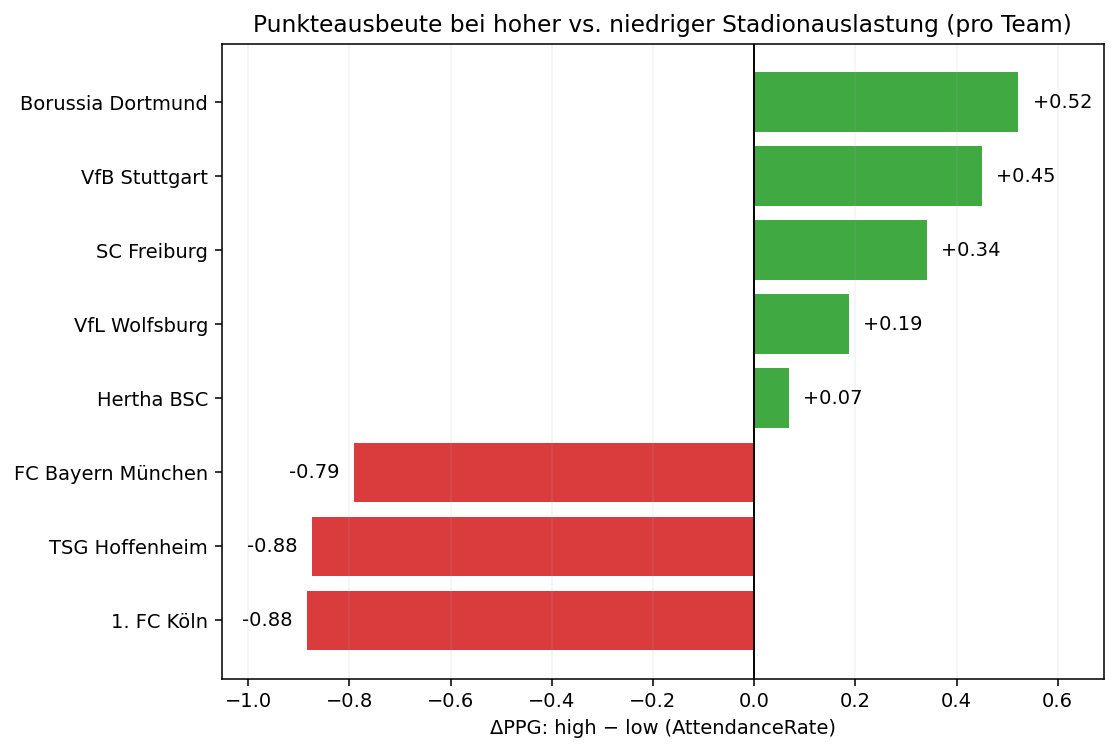

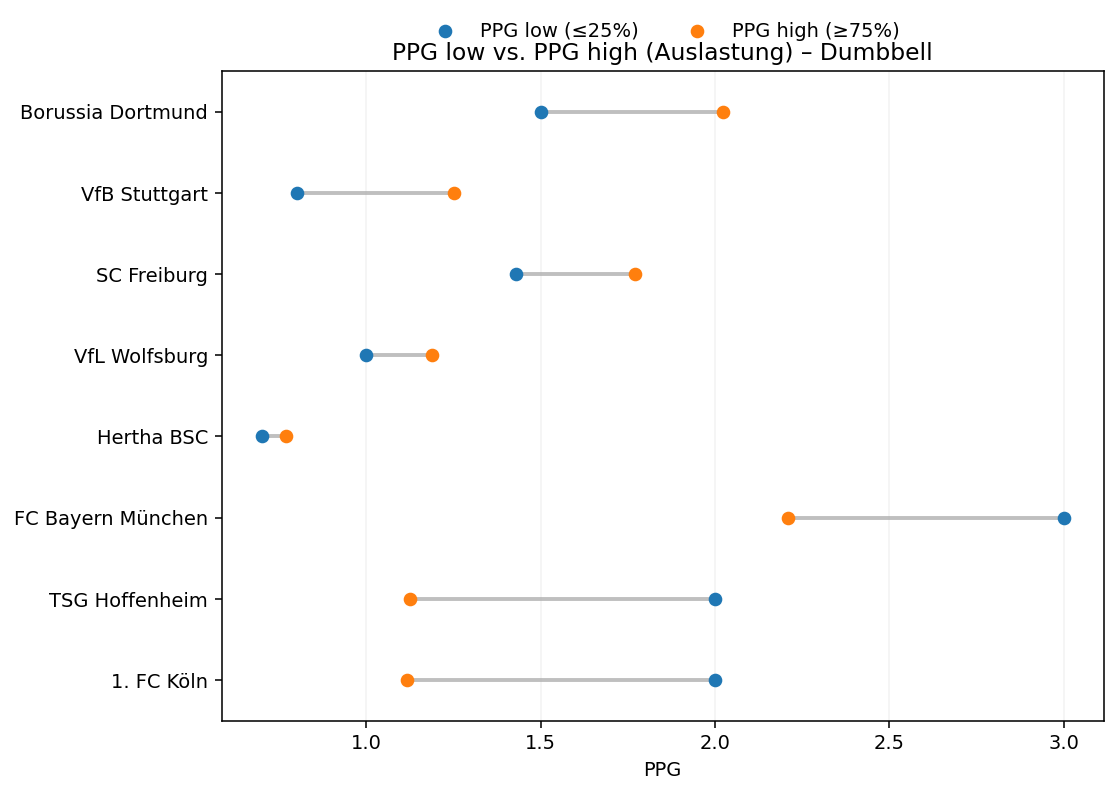

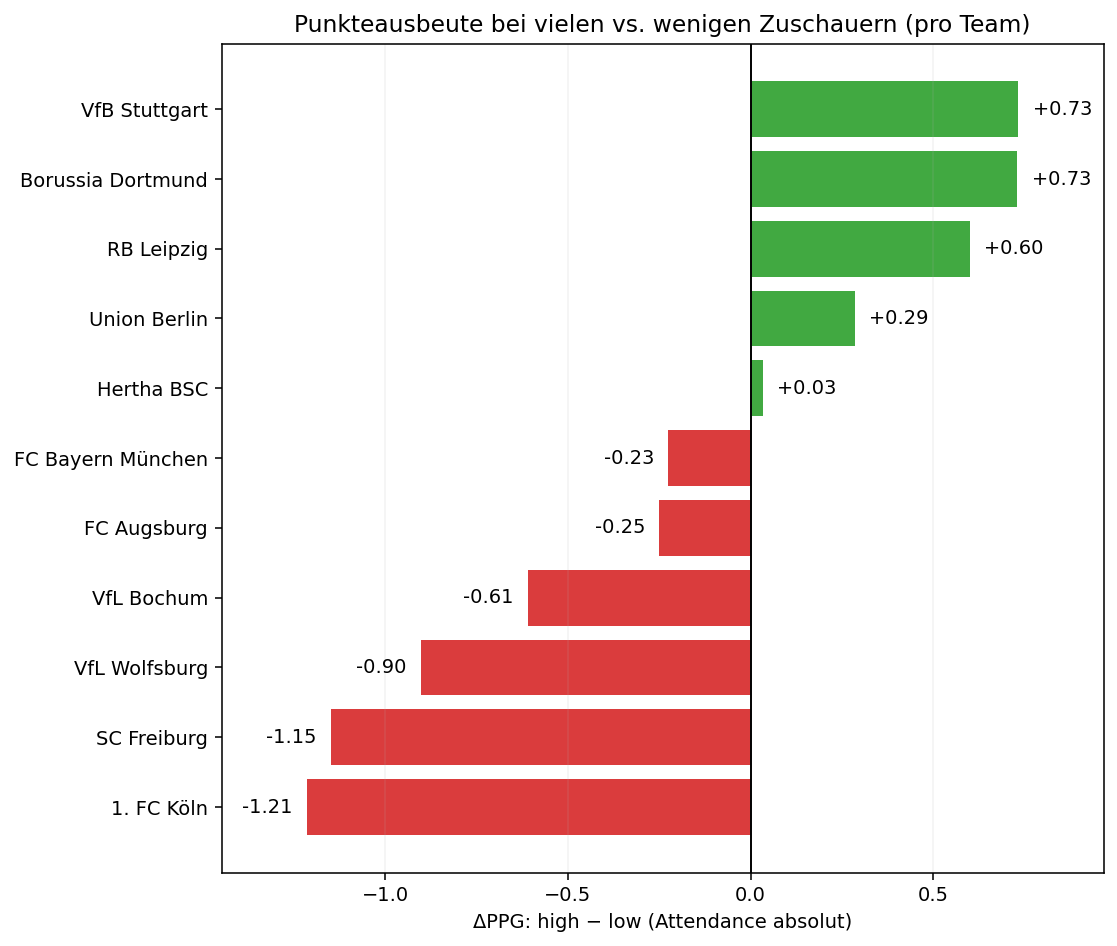

In [180]:
import numpy as np, pandas as pd, matplotlib.pyplot as plt

# Falls ppg_by_rate / ppg_by_att schon existieren – sonst aus team_matches bauen
def summarize_by_cat(df: pd.DataFrame, cat_col: str, min_n: int = 5) -> pd.DataFrame:
    g = df.dropna(subset=[cat_col, "Points"]).copy()
    g = g[g[cat_col].isin(["low","high"])].copy()
    if pd.api.types.is_categorical_dtype(g[cat_col]):
        g[cat_col] = g[cat_col].cat.remove_unused_categories()
    else:
        g[cat_col] = g[cat_col].astype(str)
    grp = (g.groupby(["Team", cat_col])["Points"]
             .agg(PPG="mean", n="size").reset_index())
    wide = grp.pivot(index="Team", columns=cat_col)
    wide.columns = [f"{m}_{lvl}" for m, lvl in wide.columns]
    out = wide.reset_index().set_index("Team")
    for col in ["PPG_low","PPG_high","n_low","n_high"]:
        if col not in out.columns: out[col] = np.nan
    out["diff_high_minus_low"] = out["PPG_high"] - out["PPG_low"]
    out = out.dropna(subset=["PPG_low","PPG_high"])
    out = out[(out["n_low"]>=5) & (out["n_high"]>=5)]
    return out.sort_values("diff_high_minus_low", ascending=False)

try:
    tbl_rate = ppg_by_rate.reset_index().copy()
except NameError:
    tbl_rate = summarize_by_cat(team_matches, "rate_cat", 5).reset_index()

try:
    tbl_att = ppg_by_att.reset_index().copy()
except NameError:
    tbl_att = summarize_by_cat(team_matches, "att_cat", 5).reset_index()

# ---------- Helper: schönes Diverging-Barh ohne Überlappungen ----------
def plot_diverging(df, title, xlabel):
    df = df.sort_values("diff_high_minus_low")
    vals = df["diff_high_minus_low"].to_numpy()
    teams = df["Team"].to_list()
    colors = np.where(vals>=0, "#2ca02c", "#d62728")

    h = max(0.55*len(df)+1.0, 3.5)  # dynamische Höhe
    fig, ax = plt.subplots(figsize=(10, h), constrained_layout=False)
    bars = ax.barh(teams, vals, color=colors, alpha=0.9)

    # Null-Linie & Gitter
    ax.axvline(0, color="k", lw=1)
    ax.grid(axis="x", alpha=0.15)

    # x-Limits mit Puffer, damit Werte-Labels außerhalb Platz haben
    xmin, xmax = np.min(vals), np.max(vals)
    span = xmax - xmin if xmax > xmin else 1.0
    pad  = 0.12*span
    ax.set_xlim(xmin - pad, xmax + pad)

    # Werte am Balkenende platzieren (außerhalb, ohne Überlappung)
    for y, v in enumerate(vals):
        ha = "left" if v >= 0 else "right"
        xtext = v + (0.02*span if v >= 0 else -0.02*span)
        ax.text(xtext, y, f"{v:+.2f}", va="center", ha=ha)

    ax.set_xlabel(xlabel)
    ax.set_ylabel("")
    ax.set_title(title)
    # Mehr Platz links für Teamlabels
    plt.subplots_adjust(left=0.33, right=0.96, top=0.92, bottom=0.08)
    plt.show()

# ---------- Helper: Dumbbell ohne Überlappungen, Legende oben ----------
def plot_dumbbell(df, title):
    df = df.sort_values("diff_high_minus_low")
    y = np.arange(len(df))

    h = max(0.6*len(df)+1.0, 4.0)
    fig, ax = plt.subplots(figsize=(10, h), constrained_layout=False)

    ax.hlines(y, df["PPG_low"], df["PPG_high"], color="0.75", lw=2, zorder=1)
    ax.scatter(df["PPG_low"],  y, label="PPG low (≤25%)",  zorder=2)
    ax.scatter(df["PPG_high"], y, label="PPG high (≥75%)", zorder=2)

    ax.set_yticks(y)
    ax.set_yticklabels(df["Team"])
    ax.set_ylim(-0.5, len(df)-0.5)
    ax.grid(axis="x", alpha=0.15)
    ax.set_xlabel("PPG")
    ax.set_title(title)

    # Legende außerhalb, oben – kollisionsfrei
    ax.legend(loc="lower center", bbox_to_anchor=(0.5, 1.02), ncol=2, frameon=False)
    plt.subplots_adjust(left=0.33, right=0.96, top=0.88, bottom=0.08)
    plt.show()

# ---------- Plots ----------
plot_diverging(tbl_rate, "Punkteausbeute bei hoher vs. niedriger Stadionauslastung (pro Team)",
               "ΔPPG: high − low (AttendanceRate)")

plot_dumbbell(tbl_rate, "PPG low vs. PPG high (Auslastung) – Dumbbell")

if not tbl_att.empty:
    plot_diverging(tbl_att, "Punkteausbeute bei vielen vs. wenigen Zuschauern (pro Team)",
                   "ΔPPG: high − low (Attendance absolut)")



C:\Users\admin\AppData\Local\Temp\ipykernel_20428\3426748968.py:57: UserWarning: Parsing dates in %Y-%m-%d format when dayfirst=True was specified. Pass `dayfirst=False` or specify a format to silence this warning.
  "Date": pd.to_datetime(df["Date"], dayfirst=True, errors="coerce"),
C:\Users\admin\AppData\Local\Temp\ipykernel_20428\3426748968.py:57: UserWarning: Parsing dates in %Y-%m-%d format when dayfirst=True was specified. Pass `dayfirst=False` or specify a format to silence this warning.
  "Date": pd.to_datetime(df["Date"], dayfirst=True, errors="coerce"),


[Info] matches automatisch gefunden/gebaut → (502, 5)
[Hinweis] Nutze Top-5 nach Matchanzahl in 2022/2023: ['Bundesliga']


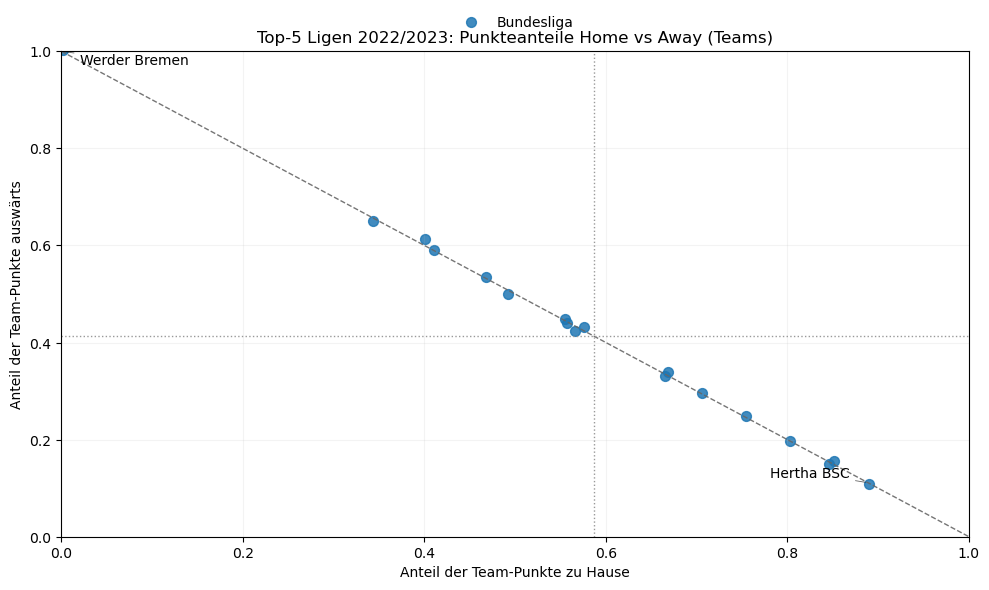

,League,Team,home_points,away_points,total_points,home_share,away_share
0,Bundesliga,Hertha BSC,8,1,9,0.889,0.111
1,Bundesliga,Eint Frankfurt,6,1,7,0.857,0.143
2,Bundesliga,M'Gladbach,11,2,13,0.846,0.154
3,Bundesliga,Stuttgart,4,1,5,0.800,0.200
4,Bundesliga,Bochum,9,3,12,0.750,0.250
5,Bundesliga,Dortmund,7,3,10,0.700,0.300
6,Bundesliga,Augsburg,10,5,15,0.667,0.333
7,Bundesliga,Hoffenheim,6,3,9,0.667,0.333
8,Bundesliga,Mainz 05,4,3,7,0.571,0.429
9,Bundesliga,Union Berlin,8,6,14,0.571,0.429


In [5]:
# === Home vs Away *Punkteanteile* (Top-5, letzte volle Saison) – robuster Loader ===
from pathlib import Path
import numpy as np, pandas as pd, matplotlib.pyplot as plt

# ---------- Helpers ----------
def _points_from_goals(hg, ag):
    hg = pd.to_numeric(hg, errors="coerce")
    ag = pd.to_numeric(ag, errors="coerce")
    home_pts = np.select([hg>ag, hg==ag],[3,1], default=0)
    away_pts = np.select([hg<ag, hg==ag],[3,1], default=0)
    return home_pts, away_pts

def _build_matches_from_fans_use(fu: pd.DataFrame) -> pd.DataFrame:
    fu = fu.copy()
    home = "HomeTeam_std" if "HomeTeam_std" in fu.columns else ("HomeTeam" if "HomeTeam" in fu.columns else None)
    away = "AwayTeam_std" if "AwayTeam_std" in fu.columns else ("AwayTeam" if "AwayTeam" in fu.columns else None)
    if home is None or away is None or "Date" not in fu.columns or "League" not in fu.columns:
        raise ValueError("fans_use fehlt eine der Spalten: Date, League, HomeTeam[_std], AwayTeam[_std]")
    out = fu.rename(columns={home:"HomeTeam", away:"AwayTeam"})[["Date","League","HomeTeam","AwayTeam"]].copy()
    if "DeltaPoints" in fu.columns:
        out["DeltaPoints"] = fu["DeltaPoints"].values
        return out
    # goals -> points
    h_candidates = [c for c in ["HomeGoals","FTHG","Score_x","HG","Gls_home"] if c in fu.columns]
    a_candidates = [c for c in ["AwayGoals","FTAG","Score_y","AG","Gls_away"] if c in fu.columns]
    if not h_candidates or not a_candidates:
        raise ValueError("Weder DeltaPoints noch geeignete Tor-Spalten in fans_use gefunden.")
    home_pts, away_pts = _points_from_goals(fu[h_candidates[0]], fu[a_candidates[0]])
    out["DeltaPoints"] = home_pts - away_pts
    return out

def _build_matches_from_kaggle_attendance() -> pd.DataFrame | None:
    """Sucht unter data/attendance/<Liga>/Bundesliga_*20*.csv etc. und baut Matches je Liga."""
    here = Path.cwd()
    roots = [p for p in [here, *here.parents] if (p/"data").exists()]
    if not roots: return None
    root = roots[0] / "data" / "attendance"
    league_dirs = {
        "Bundesliga": "Bundesliga",
        "Premier League": "Premier League",
        "La Liga": "La Liga",
        "Serie A": "Serie A",
        "Ligue 1": "Ligue 1",
    }
    frames = []
    for lg, sub in league_dirs.items():
        pdir = root / sub
        if not pdir.exists(): continue
        files = sorted([f for f in pdir.glob(f"{sub}_*20*.csv") if "player_data" not in f.name])
        for f in files:
            try:
                df = pd.read_csv(f, encoding="utf-8")
                # Spalten für Teams/Datum identifizieren (Kaggle: Home/Away/Date/Score_x/Score_y)
                if not {"Home","Away","Date"}.issubset(df.columns): 
                    continue
                tmp = pd.DataFrame({
                    "Date": pd.to_datetime(df["Date"], dayfirst=True, errors="coerce"),
                    "League": lg,
                    "HomeTeam": df["Home"],
                    "AwayTeam": df["Away"]
                })
                # DeltaPoints ermitteln
                h_cands = [c for c in ["Score_x","FTHG","HomeGoals","HG","Gls_home"] if c in df.columns]
                a_cands = [c for c in ["Score_y","FTAG","AwayGoals","AG","Gls_away"] if c in df.columns]
                if h_cands and a_cands:
                    home_pts, away_pts = _points_from_goals(df[h_cands[0]], df[a_cands[0]])
                    tmp["DeltaPoints"] = home_pts - away_pts
                else:
                    # falls keine Tore – skip
                    continue
                frames.append(tmp.dropna(subset=["Date"]))
            except Exception:
                continue
    if not frames: 
        return None
    m = pd.concat(frames, ignore_index=True).drop_duplicates()
    return m

# ---------- 1) matches robust besorgen ----------
if "matches" in globals() and isinstance(matches, pd.DataFrame):
    m = matches.copy()
elif "fans_use" in globals() and isinstance(fans_use, pd.DataFrame):
    m = _build_matches_from_fans_use(fans_use)
    print(f"[Info] matches aus fans_use gebaut → {m.shape}")
else:
    m = _build_matches_from_kaggle_attendance()
    if m is None:
        # letzter Versuch: irgendeine matches.csv im Projekt
        here = Path.cwd()
        roots = [p for p in [here, *here.parents] if (p/"data").exists()]
        m = None
        if roots:
            for pat in ["**/*matches*.csv","**/*results*.csv","**/matches.csv"]:
                for f in (roots[0]/"data").glob(pat):
                    try:
                        df = pd.read_csv(f)
                        if {"Date","League","HomeTeam","AwayTeam"}.issubset(df.columns):
                            m = df[["Date","League","HomeTeam","AwayTeam"] + 
                                   [c for c in ["DeltaPoints","HomeGoals","AwayGoals","FTHG","FTAG","Score_x","Score_y","HG","AG"] if c in df.columns]].copy()
                            break
                    except Exception:
                        pass
                if m is not None: break
    if m is not None:
        print(f"[Info] matches automatisch gefunden/gebaut → {m.shape}")
    else:
        raise NameError("Konnte 'matches' nicht finden/erstellen. Bitte 'matches' ODER 'fans_use' ODER Kaggle-Attendance-Dateien bereitstellen (data/attendance/<Liga>/...).")

# ---------- 2) letzte volle Saison (1. Jul … 30. Jun) bestimmen ----------
m["Date"] = pd.to_datetime(m["Date"], errors="coerce")
max_d = m["Date"].max()
end_year = max_d.year - (1 if max_d.month < 7 else 0)
SEASON_START = pd.Timestamp(end_year-1, 7, 1)
SEASON_END   = pd.Timestamp(end_year,   6, 30)

# ---------- 3) Top-5 Ligen auswählen (oder 5 größte im Datensatz) ----------
league_alias = {"English Premier League":"Premier League", "EPL":"Premier League",
                "Primera Division":"La Liga", "LaLiga":"La Liga", "Serie A TIM":"Serie A",
                "Ligue1":"Ligue 1"}
m["League"] = m["League"].replace(league_alias)

TOP5 = ["Premier League","La Liga","Bundesliga","Serie A","Ligue 1"]
available = set(m["League"].unique())
if not set(TOP5).issubset(available):
    ms_tmp = m[m["Date"].between(SEASON_START, SEASON_END)]
    TOP5 = ms_tmp["League"].value_counts().head(5).index.tolist()
    print(f"[Hinweis] Nutze Top-5 nach Matchanzahl in {SEASON_START.year}/{SEASON_END.year}: {TOP5}")

# ---------- 4) Saison filtern & Punkte berechnen ----------
ms = m[(m["League"].isin(TOP5)) & (m["Date"].between(SEASON_START, SEASON_END))].copy()

# Punkte robust herleiten
if "DeltaPoints" in ms.columns:
    home_pts = np.select([ms["DeltaPoints"]>0, ms["DeltaPoints"]==0],[3,1], default=0)
    away_pts = np.select([ms["DeltaPoints"]<0, ms["DeltaPoints"]==0],[3,1], default=0)
else:
    hcols = [c for c in ["HomeGoals","FTHG","Score_x","HG","Gls_home"] if c in ms.columns]
    acols = [c for c in ["AwayGoals","FTAG","Score_y","AG","Gls_away"] if c in ms.columns]
    if not hcols or not acols:
        raise ValueError("Keine Ergebnis-/Torspalten in 'matches' gefunden.")
    home_pts, away_pts = _points_from_goals(ms[hcols[0]], ms[acols[0]])

ms["home_pts"], ms["away_pts"] = home_pts, away_pts

home_sum = (ms.groupby(["League","HomeTeam"])["home_pts"].sum()
              .rename_axis(index={"HomeTeam":"Team"}).rename("home_points"))
away_sum = (ms.groupby(["League","AwayTeam"])["away_pts"].sum()
              .rename_axis(index={"AwayTeam":"Team"}).rename("away_points"))
pts = home_sum.to_frame().join(away_sum.to_frame(), how="outer").fillna(0).reset_index()
pts["total_points"] = pts["home_points"] + pts["away_points"]
pts = pts[pts["total_points"] > 0].copy()
pts["home_share"] = pts["home_points"] / pts["total_points"]
pts["away_share"] = 1 - pts["home_share"]

# ---------- 5) Scatter (mit Diagonale, Jitter, Labels für Extremwerte) ----------
x_mean, y_mean = pts["home_share"].mean(), pts["away_share"].mean()
idx_home_max = pts["home_share"].idxmax()
idx_home_min = pts["home_share"].idxmin()
idx_away_max = pts["away_share"].idxmax()
idx_away_min = pts["away_share"].idxmin()
label_idx = {idx_home_max, idx_home_min, idx_away_max, idx_away_min}

rng = np.random.default_rng(42)
jitter = 0.006
jx = pd.Series(rng.normal(0, jitter, size=len(pts)), index=pts.index)
jy = pd.Series(rng.normal(0, jitter, size=len(pts)), index=pts.index)

fig, ax = plt.subplots(figsize=(10,6))
for lg, g in pts.groupby("League"):
    ax.scatter(g["home_share"] + jx.loc[g.index],
               g["away_share"] + jy.loc[g.index],
               s=50, alpha=0.85, label=lg)

xx = np.linspace(0, 1, 200)
ax.plot(xx, 1-xx, lw=1, ls="--", color="0.4", alpha=0.9)   # away = 1 - home
ax.axvline(x_mean, color="0.6", lw=1, ls=":")              # Crosshair
ax.axhline(y_mean, color="0.6", lw=1, ls=":")

for i in label_idx:
    row = pts.loc[i]
    x, y, name = row["home_share"], row["away_share"], row["Team"]
    dx = 0.02 if x <= 0.5 else -0.02
    dy = 0.02 if y <= 0.5 else -0.02
    ha = "left" if dx > 0 else "right"
    ax.annotate(name, (x, y), xytext=(x+dx, y+dy),
                ha=ha, va="center",
                arrowprops=dict(arrowstyle="-", lw=0.6, alpha=0.6))

ax.set_xlim(0,1); ax.set_ylim(0,1)
ax.set_xlabel("Anteil der Team-Punkte zu Hause")
ax.set_ylabel("Anteil der Team-Punkte auswärts")
ax.set_title(f"Top-5 Ligen {SEASON_START.year}/{SEASON_END.year}: Punkteanteile Home vs Away (Teams)")
ax.legend(ncol=3, bbox_to_anchor=(0.5, 1.02), loc="lower center", frameon=False)
ax.grid(alpha=0.15)
plt.tight_layout(); plt.show()

# (Optional) Tabelle
display(pts.sort_values(["League","home_share"], ascending=[True, False])
        [["League","Team","home_points","away_points","total_points","home_share","away_share"]]
        .round(3).reset_index(drop=True))


C:\Users\admin\AppData\Local\Temp\ipykernel_20428\3855006643.py:55: UserWarning: Parsing dates in %Y-%m-%d format when dayfirst=True was specified. Pass `dayfirst=False` or specify a format to silence this warning.
  "Date": pd.to_datetime(df["Date"], dayfirst=True, errors="coerce"),
C:\Users\admin\AppData\Local\Temp\ipykernel_20428\3855006643.py:55: UserWarning: Parsing dates in %Y-%m-%d format when dayfirst=True was specified. Pass `dayfirst=False` or specify a format to silence this warning.
  "Date": pd.to_datetime(df["Date"], dayfirst=True, errors="coerce"),


[Hinweis] Verwende Top-5 nach Matchanzahl: ['Bundesliga']


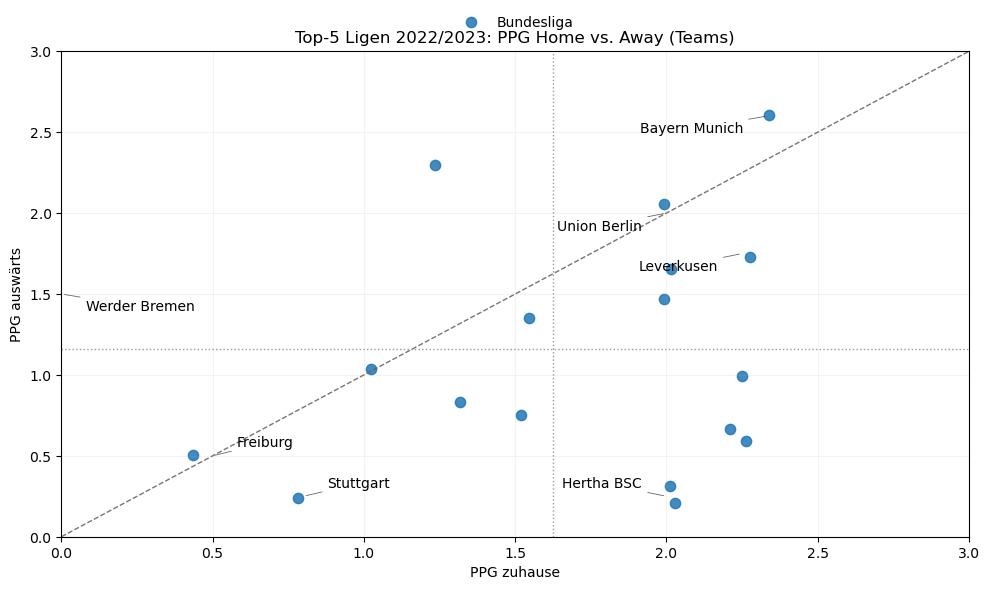

,League,Team,PPG_home,PPG_away,PPG_total,home_games,away_games
0,Bundesliga,Bayern Munich,2.333,2.600,2.500,3,5
1,Bundesliga,Leverkusen,2.250,1.750,2.000,4,4
2,Bundesliga,Union Berlin,2.000,2.000,2.000,4,3
3,Bundesliga,Augsburg,2.000,1.667,1.875,5,3
4,Bundesliga,Bochum,2.250,1.000,1.714,4,3
5,Bundesliga,Wolfsburg,1.250,2.333,1.714,4,3
6,Bundesliga,RB Leipzig,2.000,1.500,1.667,3,6
7,Bundesliga,M'Gladbach,2.200,0.667,1.625,5,3
8,Bundesliga,Schalke 04,1.500,1.400,1.444,4,5
9,Bundesliga,Dortmund,2.333,0.600,1.250,3,5


In [7]:
# === Home vs Away: Punkte pro Spiel (PPG) – Top-5 Ligen, letzte volle Saison (robust) ===
from pathlib import Path
import numpy as np, pandas as pd, matplotlib.pyplot as plt

# ---------- Helpers ----------
def _points_from_goals(hg, ag):
    hg = pd.to_numeric(hg, errors="coerce")
    ag = pd.to_numeric(ag, errors="coerce")
    home_pts = np.select([hg>ag, hg==ag], [3,1], default=0)
    away_pts = np.select([hg<ag, hg==ag], [3,1], default=0)
    return home_pts, away_pts

def _build_matches_from_fans_use(fu: pd.DataFrame) -> pd.DataFrame:
    fu = fu.copy()
    home = "HomeTeam_std" if "HomeTeam_std" in fu.columns else ("HomeTeam" if "HomeTeam" in fu.columns else None)
    away = "AwayTeam_std" if "AwayTeam_std" in fu.columns else ("AwayTeam" if "AwayTeam" in fu.columns else None)
    if home is None or away is None or "Date" not in fu.columns or "League" not in fu.columns:
        raise ValueError("fans_use muss Spalten haben: Date, League, HomeTeam[_std], AwayTeam[_std].")
    out = fu.rename(columns={home:"HomeTeam", away:"AwayTeam"})[
        ["Date","League","HomeTeam","AwayTeam"] + 
        [c for c in fu.columns if c in {"DeltaPoints","HomeGoals","AwayGoals","FTHG","FTAG","Score_x","Score_y","HG","AG","Gls_home","Gls_away"}]
    ].copy()
    if "DeltaPoints" not in out.columns:
        h = [c for c in ["HomeGoals","FTHG","Score_x","HG","Gls_home"] if c in fu.columns]
        a = [c for c in ["AwayGoals","FTAG","Score_y","AG","Gls_away"] if c in fu.columns]
        if not h or not a: raise ValueError("Keine geeigneten Tor-Spalten in fans_use gefunden.")
        hp, ap = _points_from_goals(fu[h[0]], fu[a[0]])
        out["DeltaPoints"] = hp - ap
    return out

def _build_matches_from_kaggle_attendance() -> pd.DataFrame | None:
    """Liest Kaggle-Attendance-CSVs unter data/attendance/<Liga>/ und baut Matches je Liga."""
    here = Path.cwd()
    roots = [p for p in [here, *here.parents] if (p/"data").exists()]
    if not roots: return None
    root = roots[0] / "data" / "attendance"
    league_dirs = {
        "Bundesliga": "Bundesliga",
        "Premier League": "Premier League",
        "La Liga": "La Liga",
        "Serie A": "Serie A",
        "Ligue 1": "Ligue 1",
    }
    frames = []
    for lg, sub in league_dirs.items():
        pdir = root / sub
        if not pdir.exists(): continue
        files = sorted([f for f in pdir.glob(f"{sub}_*20*.csv") if "player_data" not in f.name])
        for f in files:
            try:
                df = pd.read_csv(f, encoding="utf-8")
                if not {"Home","Away","Date"}.issubset(df.columns): 
                    continue
                tmp = pd.DataFrame({
                    "Date": pd.to_datetime(df["Date"], dayfirst=True, errors="coerce"),
                    "League": lg,
                    "HomeTeam": df["Home"],
                    "AwayTeam": df["Away"]
                })
                # Ergebnisspalten finden
                h_cands = [c for c in ["Score_x","FTHG","HomeGoals","HG","Gls_home"] if c in df.columns]
                a_cands = [c for c in ["Score_y","FTAG","AwayGoals","AG","Gls_away"] if c in df.columns]
                if not h_cands or not a_cands:
                    continue
                hp, ap = _points_from_goals(df[h_cands[0]], df[a_cands[0]])
                tmp["DeltaPoints"] = hp - ap
                frames.append(tmp.dropna(subset=["Date"]))
            except Exception:
                continue
    if not frames: 
        return None
    return pd.concat(frames, ignore_index=True).drop_duplicates()

def _load_generic_matches_from_disk() -> pd.DataFrame | None:
    here = Path.cwd()
    roots = [p for p in [here, *here.parents] if (p / "data").exists()]
    if not roots: return None
    base = roots[0] / "data"
    files = []
    for pat in ["**/*matches*.csv","**/*results*.csv","**/matches.csv"]:
        files += list(base.glob(pat))
    dfs = []
    for f in files:
        try:
            df = pd.read_csv(f)
            if {"Date","League","HomeTeam","AwayTeam"}.issubset(df.columns):
                keep = ["Date","League","HomeTeam","AwayTeam"] + \
                    [c for c in ["DeltaPoints","HomeGoals","AwayGoals","FTHG","FTAG","Score_x","Score_y","HG","AG"] if c in df.columns]
                dfs.append(df[keep])
        except Exception:
            pass
    if not dfs: return None
    return pd.concat(dfs, ignore_index=True).drop_duplicates()

# ---------- 1) matches besorgen ----------
if "matches" in globals() and isinstance(matches, pd.DataFrame):
    m = matches.copy()
elif "fans_use" in globals() and isinstance(fans_use, pd.DataFrame):
    m = _build_matches_from_fans_use(fans_use)
    print(f"[Info] matches aus fans_use gebaut → {m.shape}")
else:
    m = _build_matches_from_kaggle_attendance()
    if m is None:
        m = _load_generic_matches_from_disk()
    if m is None:
        raise NameError("Konnte 'matches'/'fans_use' nicht finden und keine Kaggle-/Projektdateien laden. "
                        "Lege CSVs unter data/attendance/<Liga>/ oder data/**matches*.csv ab.")

# ---------- 2) letzte volle Saison bestimmen ----------
m["Date"] = pd.to_datetime(m["Date"], errors="coerce")
max_d = m["Date"].max()
if pd.isna(max_d):
    raise ValueError("Keine gültigen Datumswerte in 'matches'.")
end_year = max_d.year - (1 if max_d.month < 7 else 0)  # letzter 30. Juni ≤ max_d
SEASON_START = pd.Timestamp(end_year-1, 7, 1)
SEASON_END   = pd.Timestamp(end_year,   6, 30)

# ---------- 3) Top-5 Ligen wählen ----------
league_alias = {"English Premier League":"Premier League", "EPL":"Premier League",
                "Primera Division":"La Liga", "LaLiga":"La Liga",
                "Serie A TIM":"Serie A", "Ligue1":"Ligue 1"}
m["League"] = m["League"].replace(league_alias)

TOP5 = ["Premier League","La Liga","Bundesliga","Serie A","Ligue 1"]
avail = set(m["League"].unique())
if not set(TOP5).issubset(avail):
    ms_tmp = m[m["Date"].between(SEASON_START, SEASON_END)]
    TOP5 = ms_tmp["League"].value_counts().head(5).index.tolist()
    print(f"[Hinweis] Verwende Top-5 nach Matchanzahl: {TOP5}")

# ---------- 4) Saison filtern & PPG berechnen ----------
ms = m[(m["League"].isin(TOP5)) & (m["Date"].between(SEASON_START, SEASON_END))].copy()

# Punkte herleiten
if "DeltaPoints" in ms.columns:
    home_pts = np.select([ms["DeltaPoints"]>0, ms["DeltaPoints"]==0],[3,1], default=0)
    away_pts = np.select([ms["DeltaPoints"]<0, ms["DeltaPoints"]==0],[3,1], default=0)
else:
    hcols = [c for c in ["HomeGoals","FTHG","Score_x","HG","Gls_home"] if c in ms.columns]
    acols = [c for c in ["AwayGoals","FTAG","Score_y","AG","Gls_away"] if c in ms.columns]
    if not hcols or not acols:
        raise ValueError("Keine geeigneten Ergebnis-/Torspalten gefunden.")
    home_pts, away_pts = _points_from_goals(ms[hcols[0]], ms[acols[0]])

ms["home_pts"], ms["away_pts"] = home_pts, away_pts

home_agg = (ms.groupby(["League","HomeTeam"])["home_pts"]
              .agg(points="sum", games="size")
              .rename_axis(index={"HomeTeam":"Team"}))
home_agg["PPG_home"] = home_agg["points"] / home_agg["games"]

away_agg = (ms.groupby(["League","AwayTeam"])["away_pts"]
              .agg(points="sum", games="size")
              .rename_axis(index={"AwayTeam":"Team"}))
away_agg["PPG_away"] = away_agg["points"] / away_agg["games"]

perf = (home_agg[["PPG_home","games"]].rename(columns={"games":"home_games"})
        .join(away_agg[["PPG_away","games"]].rename(columns={"games":"away_games"}), how="outer")
        .reset_index())

# Gesamt-PPG (gewichtet)
perf["total_games"] = perf["home_games"].fillna(0) + perf["away_games"].fillna(0)
perf = perf[perf["total_games"] > 0].copy()
perf["PPG_total"] = (
    (perf["PPG_home"].fillna(0)*perf["home_games"].fillna(0) +
     perf["PPG_away"].fillna(0)*perf["away_games"].fillna(0)) / perf["total_games"]
)

# ---------- 5) Scatter (PPG_home vs PPG_away) ----------
x_mean, y_mean = perf["PPG_home"].mean(), perf["PPG_away"].mean()

# Ausreißer: Top/Flop total + Extremwerte je Achse
N = 3
rank = perf.sort_values("PPG_total")
flops = rank.head(N).index
tops  = rank.tail(N).index
ix_max_x = perf["PPG_home"].idxmax()
ix_min_x = perf["PPG_home"].idxmin()
ix_max_y = perf["PPG_away"].idxmax()
ix_min_y = perf["PPG_away"].idxmin()
label_idx = set(list(flops) + list(tops) + [ix_max_x, ix_min_x, ix_max_y, ix_min_y])

# Jitter nur für Darstellung
rng = np.random.default_rng(23)
jitter = 0.03
jx = pd.Series(rng.normal(0, jitter, size=len(perf)), index=perf.index)
jy = pd.Series(rng.normal(0, jitter, size=len(perf)), index=perf.index)

fig, ax = plt.subplots(figsize=(10, 6))
for lg, g in perf.groupby("League"):
    ax.scatter(g["PPG_home"] + jx.loc[g.index],
               g["PPG_away"] + jy.loc[g.index],
               s=55, alpha=0.85, label=lg)

# Diagonale & Crosshair
xx = np.linspace(0, 3, 200)
ax.plot(xx, xx, lw=1, ls="--", color="0.4", alpha=0.9)
ax.axvline(x_mean, color="0.6", lw=1, ls=":")
ax.axhline(y_mean, color="0.6", lw=1, ls=":")

# Labels
for i in label_idx:
    row = perf.loc[i]
    x, y, name = row["PPG_home"], row["PPG_away"], row["Team"]
    dx = 0.08 if x <= x_mean else -0.08
    dy = 0.08 if y <= y_mean else -0.08
    ha = "left" if dx > 0 else "right"
    ax.annotate(name, (x, y), xytext=(x+dx, y+dy),
                textcoords="data", ha=ha, va="center",
                arrowprops=dict(arrowstyle="-", lw=0.6, alpha=0.6))

ax.set_xlim(0, 3); ax.set_ylim(0, 3)
ax.set_xlabel("PPG zuhause")
ax.set_ylabel("PPG auswärts")
ax.set_title(f"Top-5 Ligen {SEASON_START.year}/{SEASON_END.year}: PPG Home vs. Away (Teams)")
ax.legend(ncol=3, bbox_to_anchor=(0.5, 1.02), loc="lower center", frameon=False)
ax.grid(alpha=0.15)
plt.tight_layout(); plt.show()

# (Optional) Tabelle
display(perf.sort_values(["League","PPG_total"], ascending=[True, False])
        [["League","Team","PPG_home","PPG_away","PPG_total","home_games","away_games"]]
        .round(3).reset_index(drop=True))


C:\Users\admin\AppData\Local\Temp\ipykernel_20428\3448599235.py:77: UserWarning: Parsing dates in %Y-%m-%d format when dayfirst=True was specified. Pass `dayfirst=False` or specify a format to silence this warning.
  "Date": pd.to_datetime(df["Date"], dayfirst=True, errors="coerce"),
C:\Users\admin\AppData\Local\Temp\ipykernel_20428\3448599235.py:77: UserWarning: Parsing dates in %Y-%m-%d format when dayfirst=True was specified. Pass `dayfirst=False` or specify a format to silence this warning.
  "Date": pd.to_datetime(df["Date"], dayfirst=True, errors="coerce"),


[Hinweis] Verwende Top-5 nach Matchanzahl 2022/2023: ['Bundesliga']


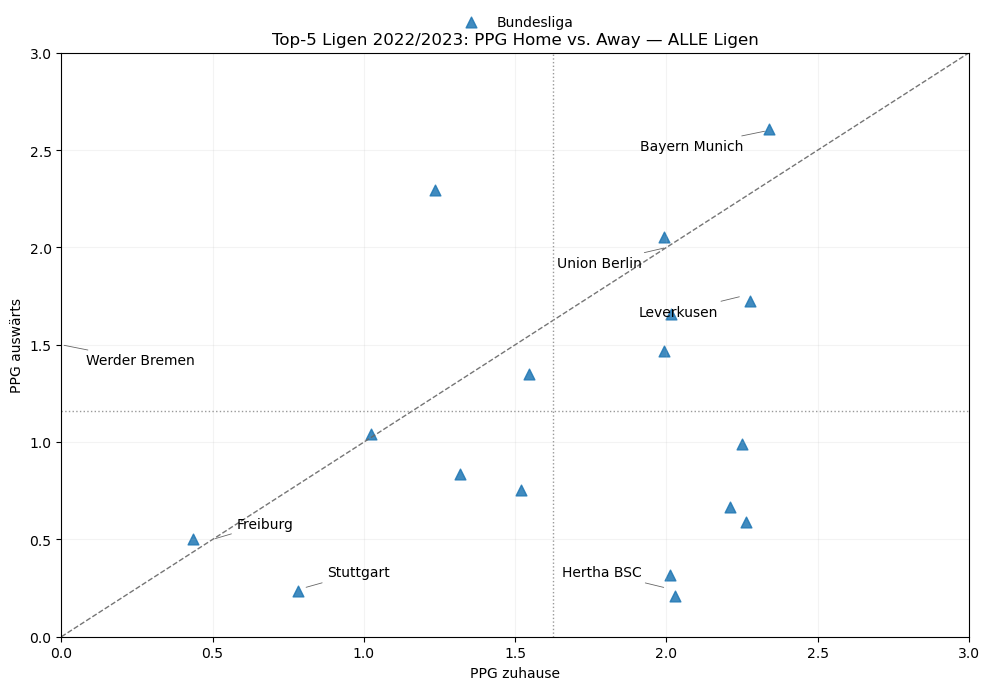

In [9]:
# === ONE-FIG: PPG Home vs Away für ALLE Top-5 Ligen (letzte volle Saison) – mit Kaggle-Fallback ===
from pathlib import Path
import numpy as np, pandas as pd, matplotlib.pyplot as plt

# ---------- Loader-Helpers ----------
LEAGUE_KEYS = ["Bundesliga", "Premier League", "La Liga", "Serie A", "Ligue 1"]
ALIASES = {
    "English Premier League":"Premier League", "EPL":"Premier League",
    "Primera Division":"La Liga", "LaLiga":"La Liga",
    "Serie A TIM":"Serie A", "Ligue1":"Ligue 1"
}

def _points_from_goals(hg, ag):
    hg = pd.to_numeric(hg, errors="coerce"); ag = pd.to_numeric(ag, errors="coerce")
    home_pts = np.select([hg>ag, hg==ag], [3,1], default=0)
    away_pts = np.select([hg<ag, hg==ag], [3,1], default=0)
    return home_pts, away_pts

def _build_matches_from_fans_use(fu: pd.DataFrame) -> pd.DataFrame:
    fu = fu.copy()
    home = "HomeTeam_std" if "HomeTeam_std" in fu.columns else ("HomeTeam" if "HomeTeam" in fu.columns else None)
    away = "AwayTeam_std" if "AwayTeam_std" in fu.columns else ("AwayTeam" if "AwayTeam" in fu.columns else None)
    if home is None or away is None or "Date" not in fu.columns or "League" not in fu.columns:
        raise ValueError("fans_use braucht: Date, League, HomeTeam[_std], AwayTeam[_std].")
    out = fu.rename(columns={home:"HomeTeam", away:"AwayTeam"})[
        ["Date","League","HomeTeam","AwayTeam"] + 
        [c for c in fu.columns if c in {"DeltaPoints","HomeGoals","AwayGoals","FTHG","FTAG","Score_x","Score_y","HG","AG","Gls_home","Gls_away"}]
    ].copy()
    if "DeltaPoints" not in out.columns:
        h = [c for c in ["HomeGoals","FTHG","Score_x","HG","Gls_home"] if c in fu.columns]
        a = [c for c in ["AwayGoals","FTAG","Score_y","AG","Gls_away"] if c in fu.columns]
        if not h or not a: raise ValueError("Keine geeigneten Tor-Spalten in fans_use gefunden.")
        hp, ap = _points_from_goals(fu[h[0]], fu[a[0]])
        out["DeltaPoints"] = hp - ap
    return out

def _infer_league_from_path(path: Path) -> str | None:
    s = str(path)
    for key in LEAGUE_KEYS:
        if key.lower().replace(" ", "") in s.lower().replace(" ", ""):
            return key
    return None

def _build_matches_from_kaggle_attendance() -> pd.DataFrame | None:
    """Liest Kaggle-CSV(s) rekursiv aus data/attendance/** (oder allgemein data/**) und baut Matches."""
    here = Path.cwd()
    roots = [p for p in [here, *here.parents] if (p/"data").exists()]
    if not roots: return None
    base = roots[0] / "data"

    # Suche bevorzugt unter data/attendance/**, sonst überall unter data/**
    candidates = list((base / "attendance").rglob("*.csv")) if (base/"attendance").exists() else list(base.rglob("*.csv"))
    frames = []
    for f in candidates:
        name = f.name.lower()
        if "player_data" in name: 
            continue
        # nur typische Kaggle-Matchdateien berücksichtigen
        try:
            df = pd.read_csv(f, encoding="utf-8")
        except Exception:
            continue
        # Minimalstruktur prüfen
        if not {"Date","Home","Away"}.issubset(df.columns):
            continue
        # Ergebnisspalten (Kaggle: Score_x/Score_y)
        h_cands = [c for c in ["Score_x","FTHG","HomeGoals","HG","Gls_home"] if c in df.columns]
        a_cands = [c for c in ["Score_y","FTAG","AwayGoals","AG","Gls_away"] if c in df.columns]
        if not h_cands or not a_cands:
            continue
        lg = df["League"].iloc[0] if "League" in df.columns and isinstance(df["League"].iloc[0], str) else _infer_league_from_path(f)
        if lg is None:
            # Wenn keine Liga ermittelbar → überspringen (wir brauchen Top-5)
            continue

        tmp = pd.DataFrame({
            "Date": pd.to_datetime(df["Date"], dayfirst=True, errors="coerce"),
            "League": lg,
            "HomeTeam": df["Home"],
            "AwayTeam": df["Away"]
        })
        hp, ap = _points_from_goals(df[h_cands[0]], df[a_cands[0]])
        tmp["DeltaPoints"] = hp - ap
        tmp = tmp.dropna(subset=["Date"])
        frames.append(tmp)
    if not frames: 
        return None
    m = pd.concat(frames, ignore_index=True).drop_duplicates()
    return m

# ---------- 1) matches besorgen (matches -> fans_use -> Kaggle) ----------
if "matches" in globals() and isinstance(matches, pd.DataFrame):
    m = matches.copy()
elif "fans_use" in globals() and isinstance(fans_use, pd.DataFrame):
    m = _build_matches_from_fans_use(fans_use)
    print(f"[Info] matches aus fans_use gebaut → {m.shape}")
else:
    m = _build_matches_from_kaggle_attendance()
    if m is None:
        raise NameError("Konnte 'matches'/'fans_use' nicht finden und keine Kaggle-Dateien laden.\n"
                        "Lege CSVs z.B. unter data/attendance/Bundesliga/Bundesliga_2021-2022.csv ab.")

# ---------- 2) letzte volle Saison bestimmen ----------
m["League"] = m["League"].replace(ALIASES)
m["Date"] = pd.to_datetime(m["Date"], errors="coerce")
max_d = m["Date"].max()
if pd.isna(max_d):
    raise ValueError("Keine gültigen Datumswerte in 'matches'.")
end_year = max_d.year - (1 if max_d.month < 7 else 0)  # letzter 30. Juni ≤ max_d
SEASON_START = pd.Timestamp(end_year-1, 7, 1)
SEASON_END   = pd.Timestamp(end_year,   6, 30)

# ---------- 3) Top-5 Ligen wählen (falls nicht alle vorhanden → 5 größte) ----------
TOP5 = ["Premier League","La Liga","Bundesliga","Serie A","Ligue 1"]
avail = set(m["League"].unique())
if not set(TOP5).issubset(avail):
    ms_tmp = m[m["Date"].between(SEASON_START, SEASON_END)]
    TOP5 = ms_tmp["League"].value_counts().head(5).index.tolist()
    print(f"[Hinweis] Verwende Top-5 nach Matchanzahl {SEASON_START.year}/{SEASON_END.year}: {TOP5}")

# ---------- 4) Saison filtern & PPG berechnen ----------
ms = m[(m["League"].isin(TOP5)) & (m["Date"].between(SEASON_START, SEASON_END))].copy()

# Punkte je Match
if "DeltaPoints" in ms.columns:
    home_pts = np.select([ms["DeltaPoints"]>0, ms["DeltaPoints"]==0],[3,1], default=0)
    away_pts = np.select([ms["DeltaPoints"]<0, ms["DeltaPoints"]==0],[3,1], default=0)
else:
    hcols = [c for c in ["HomeGoals","FTHG","Score_x","HG","Gls_home"] if c in ms.columns]
    acols = [c for c in ["AwayGoals","FTAG","Score_y","AG","Gls_away"] if c in ms.columns]
    if not hcols or not acols:
        raise ValueError("Keine geeigneten Ergebnis-/Torspalten gefunden.")
    hg, ag = ms[hcols[0]], ms[acols[0]]
    home_pts, away_pts = _points_from_goals(hg, ag)

ms["home_pts"], ms["away_pts"] = home_pts, away_pts

home_agg = (ms.groupby(["League","HomeTeam"])["home_pts"]
              .agg(points="sum", games="size")
              .rename_axis(index={"HomeTeam":"Team"}))
home_agg["PPG_home"] = home_agg["points"] / home_agg["games"]

away_agg = (ms.groupby(["League","AwayTeam"])["away_pts"]
              .agg(points="sum", games="size")
              .rename_axis(index={"AwayTeam":"Team"}))
away_agg["PPG_away"] = away_agg["points"] / away_agg["games"]

perf = (home_agg[["PPG_home","games"]].rename(columns={"games":"home_games"})
        .join(away_agg[["PPG_away","games"]].rename(columns={"games":"away_games"}), how="outer")
        .reset_index())

perf["total_games"] = perf["home_games"].fillna(0) + perf["away_games"].fillna(0)
perf = perf[perf["total_games"] > 0].copy()
perf["PPG_total"] = (
    (perf["PPG_home"].fillna(0)*perf["home_games"].fillna(0) +
     perf["PPG_away"].fillna(0)*perf["away_games"].fillna(0)) / perf["total_games"]
)

# ---------- 5) EIN FIGURE: alle Ligen gemeinsam ----------
x_mean, y_mean = perf["PPG_home"].mean(), perf["PPG_away"].mean()

# Ausreißer-Labels (global): Top/Flop total + Extremwerte je Achse
N = 3
rank = perf.sort_values("PPG_total")
label_idx = set(rank.head(N).index) | set(rank.tail(N).index) \
            | {perf["PPG_home"].idxmax(), perf["PPG_home"].idxmin(),
               perf["PPG_away"].idxmax(), perf["PPG_away"].idxmin()}

# leichter Jitter gegen Überlappung (ändert Werte nicht substanziell)
rng = np.random.default_rng(23)
jitter = 0.03
jx = pd.Series(rng.normal(0, jitter, size=len(perf)), index=perf.index)
jy = pd.Series(rng.normal(0, jitter, size=len(perf)), index=perf.index)

# Marker-Form je Liga
marker_map = {"Premier League":"o", "La Liga":"s", "Bundesliga":"^", "Serie A":"D", "Ligue 1":"X"}

fig, ax = plt.subplots(figsize=(10, 7))
for lg, g in perf.groupby("League"):
    ax.scatter(g["PPG_home"] + jx.loc[g.index], g["PPG_away"] + jy.loc[g.index],
               s=60, alpha=0.85, label=lg, marker=marker_map.get(lg, "o"))

# Diagonale y=x + Crosshair
xx = np.linspace(0, 3, 200)
ax.plot(xx, xx, lw=1, ls="--", color="0.4", alpha=0.9)
ax.axvline(x_mean, color="0.6", lw=1, ls=":")
ax.axhline(y_mean, color="0.6", lw=1, ls=":")

# Labels der Ausreißer (mit Quadrant-abhängigem Offset)
for i in label_idx:
    row = perf.loc[i]
    x, y, name = row["PPG_home"], row["PPG_away"], row["Team"]
    dx = 0.08 if x <= x_mean else -0.08
    dy = 0.08 if y <= y_mean else -0.08
    ha = "left" if dx > 0 else "right"
    ax.annotate(name, (x, y), xytext=(x+dx, y+dy),
                textcoords="data", ha=ha, va="center",
                arrowprops=dict(arrowstyle="-", lw=0.6, alpha=0.6))

ax.set_xlim(0, 3); ax.set_ylim(0, 3)
ax.set_xlabel("PPG zuhause")
ax.set_ylabel("PPG auswärts")
ax.set_title(f"Top-5 Ligen {SEASON_START.year}/{SEASON_END.year}: PPG Home vs. Away — ALLE Ligen")
ax.legend(ncol=3, bbox_to_anchor=(0.5, 1.02), loc="lower center", frameon=False)
ax.grid(alpha=0.15)
plt.tight_layout(); plt.show()
